In [ ]:
# LIBRERIAS

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# Function to display images
def mostrar_imagen(imagen, titulo="Imagen"):
    # Convert from BGR to RGB for correct display with matplotlib
    if len(imagen.shape) == 3 and imagen.shape[2] == 3:
        imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    else:
        imagen_rgb = imagen  # Already grayscale or binary
        
    plt.figure(figsize=(10, 8))
    plt.title(titulo)
    plt.imshow(imagen_rgb, cmap='gray' if len(imagen.shape) == 2 else None)
    plt.axis('off')
    plt.show()

# Function to obtain binary image
def obtener_imagen_binaria(imagen, umbral=200):
    """
    Converts an image to binary format for easier processing.
    
    Args:
        imagen: Input image (BGR format)
        umbral: Threshold value for binarization
        
    Returns:
        Binary image (white objects on black background)
    """
    # Convert to grayscale
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold to get binary image
    _, binaria = cv2.threshold(gris, umbral, 255, cv2.THRESH_BINARY_INV)
    
    return binaria

In [ ]:
# Function to detect circles in the binary image
def detectar_circulos(imagen_binaria, min_circularidad=0.7, min_ancho=15, max_ancho=40, min_alto=15, max_alto=40):
    """
    Detects circles in a binary image that could represent answer options.
    
    Args:
        imagen_binaria: Binary image with white objects on black background
        min_circularidad: Minimum circularity value to consider a contour as a circle
        min_ancho, max_ancho, min_alto, max_alto: Size constraints for the circles
        
    Returns:
        List of detected circles with their coordinates and radius
    """
    # Find contours in the binary image
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # List to store detected circles
    circulos = []
    
    # Process each contour
    for contorno in contornos:
        # Calculate area and perimeter
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        
        # Calculate circularity
        if perimetro > 0:
            circularidad = 4 * np.pi * area / (perimetro * perimetro)
            
            # If it's approximately circular
            if circularidad > min_circularidad:
                x, y, w, h = cv2.boundingRect(contorno)
                
                # Filter by size
                if min_ancho < w < max_ancho and min_alto < h < max_alto:
                    centro_x = x + w//2
                    centro_y = y + h//2
                    radio = max(w, h) // 2
                    circulos.append((centro_x, centro_y, radio, contorno))
    
    return circulos

# Function to visualize detected circles
def visualizar_circulos(imagen_original, circulos):
    """
    Creates a visualization of the detected circles on the original image.
    
    Args:
        imagen_original: Original image
        circulos: List of detected circles (x, y, radius, contour)
        
    Returns:
        Image with circles drawn on it
    """
    # Create a copy of the original image
    imagen_con_circulos = imagen_original.copy()
    
    # Draw each circle
    for cx, cy, r, _ in circulos:
        cv2.circle(imagen_con_circulos, (cx, cy), r, (0, 255, 0), 2)
        cv2.circle(imagen_con_circulos, (cx, cy), 2, (0, 0, 255), -1)  # Center point
    
    return imagen_con_circulos

In [ ]:
# Function to group circles into questions (rows of 5 options)
def agrupar_circulos_en_preguntas(circulos, tolerancia_y=15):
    """
    Groups detected circles into rows of 5, each representing a question.
    
    Args:
        circulos: List of detected circles (x, y, radius, contour)
        tolerancia_y: Vertical tolerance to consider circles in the same row
        
    Returns:
        Dictionary with question numbers as keys and lists of circles as values
    """
    if not circulos:
        return {}
    
    # Sort circles by y-coordinate (vertically)
    circulos_ordenados = sorted(circulos, key=lambda c: c[1])
    
    # Group circles into rows based on y-coordinate
    filas = []
    fila_actual = [circulos_ordenados[0]]
    y_actual = circulos_ordenados[0][1]
    
    for circulo in circulos_ordenados[1:]:
        if abs(circulo[1] - y_actual) <= tolerancia_y:
            # Same row
            fila_actual.append(circulo)
        else:
            # New row
            if len(fila_actual) > 0:
                filas.append(fila_actual)
            fila_actual = [circulo]
            y_actual = circulo[1]
    
    # Add the last row if not empty
    if len(fila_actual) > 0:
        filas.append(fila_actual)
    
    # Sort each row by x-coordinate (horizontally)
    for i in range(len(filas)):
        filas[i] = sorted(filas[i], key=lambda c: c[0])
    
    # Create dictionary of questions
    preguntas = {}
    for i, fila in enumerate(filas):
        if len(fila) == 5:  # Only consider rows with exactly 5 circles (A, B, C, D, E options)
            preguntas[i + 1] = fila  # Question numbers start from 1
    
    return preguntas

# Function to visualize questions
def visualizar_preguntas(imagen_original, preguntas):
    """
    Creates a visualization of the grouped circles (questions) on the original image.
    
    Args:
        imagen_original: Original image
        preguntas: Dictionary with question numbers and their circles
        
    Returns:
        Image with questions visualized
    """
    # Create a copy of the original image
    imagen_con_preguntas = imagen_original.copy()
    
    # Colors for different questions
    colores = [
        (255, 0, 0),    # Blue
        (0, 255, 0),    # Green
        (0, 0, 255),    # Red
        (255, 255, 0),  # Cyan
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Yellow
        (128, 0, 0),    # Dark blue
        (0, 128, 0),    # Dark green
        (0, 0, 128),    # Dark red
        (128, 128, 0),  # Dark cyan
    ]
    
    # Draw each question with a different color
    for num_pregunta, circulos in preguntas.items():
        color = colores[(num_pregunta - 1) % len(colores)]
        
        # Draw each circle in the question
        for i, (cx, cy, r, _) in enumerate(circulos):
            cv2.circle(imagen_con_preguntas, (cx, cy), r, color, 2)
            
            # Add option letter (A, B, C, D, E)
            opcion = chr(65 + i)  # ASCII: A=65, B=66, etc.
            cv2.putText(imagen_con_preguntas, f"{num_pregunta}-{opcion}", 
                       (cx - r, cy - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return imagen_con_preguntas

In [ ]:
# Function to determine which circles are marked (filled in)
def detectar_circulos_marcados(imagen, preguntas, umbral_marcado=150):
    """
    Determines which circles are marked (filled in) for each question.
    
    Args:
        imagen: Original image
        preguntas: Dictionary with question numbers and their circles
        umbral_marcado: Threshold to consider a circle as marked
        
    Returns:
        Dictionary with question numbers as keys and lists of marked options as values
    """
    # Convert image to grayscale
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Dictionary to store marked options for each question
    respuestas = {}
    
    # Options labels
    opciones = ['A', 'B', 'C', 'D', 'E']
    
    # Check each question
    for num_pregunta, circulos in preguntas.items():
        respuestas[num_pregunta] = []
        
        # Check each option in the question
        for i, (cx, cy, r, _) in enumerate(circulos):
            # Create a mask for the circle
            mask = np.zeros(gris.shape, dtype=np.uint8)
            cv2.circle(mask, (cx, cy), r, 255, -1)
            
            # Calculate the mean intensity inside the circle
            mean_val = cv2.mean(gris, mask=mask)[0]
            
            # If the mean intensity is below the threshold, consider it marked
            if mean_val < umbral_marcado:
                respuestas[num_pregunta].append(opciones[i])
    
    return respuestas

# Function to visualize marked answers
def visualizar_respuestas(imagen_original, preguntas, respuestas):
    """
    Creates a visualization of the marked answers on the original image.
    
    Args:
        imagen_original: Original image
        preguntas: Dictionary with question numbers and their circles
        respuestas: Dictionary with question numbers and marked options
        
    Returns:
        Image with marked answers visualized
    """
    # Create a copy of the original image
    imagen_con_respuestas = imagen_original.copy()
    
    # Options labels
    opciones = ['A', 'B', 'C', 'D', 'E']
    
    # Draw each question
    for num_pregunta, circulos in preguntas.items():
        # Get marked options for this question
        opciones_marcadas = respuestas.get(num_pregunta, [])
        
        # Draw each circle in the question
        for i, (cx, cy, r, _) in enumerate(circulos):
            # Determine if this option is marked
            is_marked = opciones[i] in opciones_marcadas
            
            # Set color based on whether the option is marked
            color = (0, 255, 0) if is_marked else (0, 0, 255)  # Green if marked, red if not
            
            # Draw the circle
            cv2.circle(imagen_con_respuestas, (cx, cy), r, color, 2)
            
            # Add option label
            cv2.putText(imagen_con_respuestas, f"{num_pregunta}-{opciones[i]}", 
                       (cx - r, cy - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return imagen_con_respuestas


In [ ]:
# Define the correct answers
respuestas_correctas = {
    1: 'A', 2: 'A', 3: 'B', 4: 'A', 5: 'D',
    6: 'B', 7: 'B', 8: 'C', 9: 'B', 10: 'A',
    11: 'D', 12: 'A', 13: 'C', 14: 'C', 15: 'D',
    16: 'B', 17: 'A', 18: 'C', 19: 'C', 20: 'D',
    21: 'B', 22: 'A', 23: 'C', 24: 'C', 25: 'C'
}

# Function to compare detected answers with correct answers
def evaluar_respuestas(respuestas_detectadas, respuestas_correctas):
    """
    Compares detected answers with correct answers and calculates the score.
    
    Args:
        respuestas_detectadas: Dictionary with detected answers
        respuestas_correctas: Dictionary with correct answers
        
    Returns:
        Dictionary with evaluation results
    """
    correctas = 0
    incorrectas = 0
    no_contestadas = 0
    puntaje = 0
    
    # Details of each question's evaluation
    detalles = {}
    
    # Check each question
    for num_pregunta, respuesta_correcta in respuestas_correctas.items():
        # Get detected answer for this question
        opciones_marcadas = respuestas_detectadas.get(num_pregunta, [])
        
        if not opciones_marcadas:
            # No answer detected
            no_contestadas += 1
            resultado = "No contestada"
            # No points for unanswered questions
        elif len(opciones_marcadas) == 1 and opciones_marcadas[0] == respuesta_correcta:
            # Correct answer
            correctas += 1
            resultado = "Correcta"
            puntaje += 4  # 4 points for correct answer
        else:
            # Incorrect answer
            incorrectas += 1
            resultado = "Incorrecta"
            puntaje -= 1  # -1 point for incorrect answer
        
        # Store details for this question
        detalles[num_pregunta] = {
            "respuesta_correcta": respuesta_correcta,
            "respuesta_marcada": opciones_marcadas,
            "resultado": resultado
        }
    
    # Ensure score is not negative
    puntaje = max(0, puntaje)
    
    return {
        "correctas": correctas,
        "incorrectas": incorrectas,
        "no_contestadas": no_contestadas,
        "puntaje": puntaje,
        "puntaje_maximo": len(respuestas_correctas) * 4,
        "detalles": detalles
    }



In [ ]:
for i in range(1,6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png"

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect circles
            circulos_detectados = detectar_circulos(binaria)
            print(f"Detected {len(circulos_detectados)} circles")
            
            # Group circles into questions
            preguntas = agrupar_circulos_en_preguntas(circulos_detectados)
            print(f"Grouped into {len(preguntas)} questions")
            
            # Detect marked circles
            respuestas = detectar_circulos_marcados(imagen, preguntas)
            
            # Print detected answers
            print("\nDetected answers:")
            for num_pregunta, opciones_marcadas in sorted(respuestas.items()):
                print(f"Question {num_pregunta}: {', '.join(opciones_marcadas) if opciones_marcadas else 'None marked'}")
            
            # Visualize answers
            imagen_con_respuestas = visualizar_respuestas(imagen, preguntas, respuestas)
            mostrar_imagen(imagen_con_respuestas, "Marked Answers")
            
            print("Image processing completed successfully.")

                        # Print detected answers
            print("\nDetected answers:")
            for num_pregunta, opciones_marcadas in sorted(respuestas.items()):
                print(f"Question {num_pregunta}: {', '.join(opciones_marcadas) if opciones_marcadas else 'None marked'}")
            
            # Evaluate answers
            resultados = evaluar_respuestas(respuestas, respuestas_correctas)
            
            # Print evaluation results
            print("\nEvaluation results:")
            print(f"Correct answers: {resultados['correctas']}")
            print(f"Incorrect answers: {resultados['incorrectas']}")
            print(f"Unanswered questions: {resultados['no_contestadas']}")
            print(f"Score: {resultados['puntaje']} / {resultados['puntaje_maximo']}")
            
            # Print detailed results if needed
            print("\nDetailed results:")
            for num_pregunta, detalle in sorted(resultados['detalles'].items()):
                marcada = ', '.join(detalle['respuesta_marcada']) if detalle['respuesta_marcada'] else 'None'
                print(f"Question {num_pregunta}: Correct={detalle['respuesta_correcta']}, Marked={marcada}, Result={detalle['resultado']}")
                

In [ ]:
# Function to detect rectangles in the binary image
def detectar_rectangulos(imagen_binaria, min_area=1000, max_area=100000, threshold_ratio=0.7):
    """
    Detects rectangles in a binary image.
    
    Args:
        imagen_binaria: Binary image with white objects on black background
        min_area: Minimum area for a contour to be considered
        max_area: Maximum area for a contour to be considered
        threshold_ratio: Minimum ratio of width/height or height/width to consider a contour rectangular
        
    Returns:
        List of tuples (x, y, w, h) representing the rectangles
    """
    # Find contours in the binary image
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # List to store detected rectangles
    rectangulos = []
    
    # Process each contour
    for contorno in contornos:
        # Calculate area
        area = cv2.contourArea(contorno)
        
        # Filter by area
        if min_area < area < max_area:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contorno)
            
            # Calculate aspect ratio
            aspect_ratio = float(w) / h if h > 0 else 0
            
            # Approximate the contour to a polygon
            epsilon = 0.04 * cv2.arcLength(contorno, True)
            approx = cv2.approxPolyDP(contorno, epsilon, True)
            
            # Check if it's approximately rectangular (4-sided) or has a good aspect ratio
            if len(approx) == 4 or aspect_ratio > threshold_ratio or aspect_ratio < (1/threshold_ratio):
                rectangulos.append((x, y, w, h))
    
    return rectangulos

# Function to visualize detected rectangles
def visualizar_rectangulos(imagen_original, rectangulos):
    """
    Creates a visualization of the detected rectangles on the original image.
    
    Args:
        imagen_original: Original image
        rectangulos: List of tuples (x, y, w, h) representing the rectangles
        
    Returns:
        Image with rectangles drawn on it
    """
    # Create a copy of the original image
    imagen_con_rectangulos = imagen_original.copy()
    
    # Draw each rectangle
    for i, (x, y, w, h) in enumerate(rectangulos):
        # Use different colors for different rectangles
        color = (0, 255, 0)  # Green by default
        if i % 3 == 1:
            color = (255, 0, 0)  # Blue
        elif i % 3 == 2:
            color = (0, 0, 255)  # Red
            
        cv2.rectangle(imagen_con_rectangulos, (x, y), (x + w, y + h), color, 2)
        cv2.putText(imagen_con_rectangulos, f"Rect {i+1}", (x, y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return imagen_con_rectangulos

In [ ]:
for i in range(1,6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png"

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect rectangles in the binary image
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detected {len(rectangulos)} rectangles")
            
            # Visualize detected rectangles
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Detected Rectangles")
            
            # Continue with the rest of the processing...
            # (Use the original code for circle detection, etc.)
            
            print("Image processing completed successfully.")

In [ ]:

# Function to detect answer boxes (casillas) within a rectangle
def detectar_casillas(imagen_binaria, rectangulo, min_area=250, max_area=1000):
    """
    Detects answer boxes within a rectangle.
    
    Args:
        imagen_binaria: Binary image
        rectangulo: Tuple (x, y, w, h) representing the rectangle
        min_area: Minimum area for a contour to be considered a box
        max_area: Maximum area for a contour to be considered a box
        
    Returns:
        List of tuples (x, y, w, h) representing the answer boxes
    """
    # Extract the region of interest (ROI) from the binary image
    x, y, w, h = rectangulo
    roi = imagen_binaria[y:y+h, x:x+w]
    
    # Create a copy for visualization
    roi_visual = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)
    
    # Find contours in the ROI
    contornos, _ = cv2.findContours(roi, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # List to store detected boxes
    casillas = []
    
    # Process each contour
    for contorno in contornos:
        # Calculate area
        area = cv2.contourArea(contorno)
        
        # Filter by area
        if min_area < area < max_area:
            # Get bounding rectangle
            box_x, box_y, box_w, box_h = cv2.boundingRect(contorno)
            
            # Calculate aspect ratio
            aspect_ratio = float(box_w) / box_h if box_h > 0 else 0
            
            # Check if it's approximately square (aspect ratio close to 1)
            if 0.7 < aspect_ratio < 1.3:
                # Adjust coordinates to be relative to the original image
                casillas.append((x + box_x, y + box_y, box_w, box_h))
                
                # Draw on ROI visual for debugging
                cv2.rectangle(roi_visual, (box_x, box_y), (box_x + box_w, box_y + box_h), (0, 255, 0), 2)
    
    # Show the ROI with detected boxes (optional)
    mostrar_imagen(roi_visual, "Detected Boxes in ROI")
    
    return casillas

# Function to visualize answer boxes
def visualizar_casillas(imagen_original, rectangulo, casillas):
    """
    Creates a visualization of the detected answer boxes within a rectangle.
    
    Args:
        imagen_original: Original image
        rectangulo: Tuple (x, y, w, h) representing the rectangle
        casillas: List of tuples (x, y, w, h) representing the answer boxes
        
    Returns:
        Image with answer boxes drawn on it
    """
    # Create a copy of the original image
    imagen_con_casillas = imagen_original.copy()
    
    # Draw the main rectangle
    x, y, w, h = rectangulo
    cv2.rectangle(imagen_con_casillas, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Draw each answer box
    for i, (box_x, box_y, box_w, box_h) in enumerate(casillas):
        cv2.rectangle(imagen_con_casillas, (box_x, box_y), (box_x + box_w, box_y + box_h), (0, 0, 255), 2)
        
        # Add a label to each box
        cv2.putText(imagen_con_casillas, f"{i+1}", (box_x, box_y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    return imagen_con_casillas

# ... existing code ...

for i in range(1,6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png"

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect rectangles in the binary image
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detected {len(rectangulos)} rectangles")
            
            # Visualize detected rectangles
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Detected Rectangles")
                
                # Process each rectangle to find answer boxes
                for idx, rectangulo in enumerate(rectangulos):
                    print(f"\nProcessing Rectangle {idx+1}:")
                    
                    # Detect answer boxes within this rectangle
                    casillas = detectar_casillas(binaria, rectangulo)
                    print(f"  Detected {len(casillas)} answer boxes")
                    
                    # Visualize answer boxes if any were found
                    if casillas:
                        imagen_con_casillas = visualizar_casillas(imagen, rectangulo, casillas)
                        mostrar_imagen(imagen_con_casillas, f"Answer Boxes in Rectangle {idx+1}")
            
            # Continue with the rest of the processing...
            # (Use the original code for circle detection, etc.)
            
            print("Image processing completed successfully.")

In [ ]:
# Function to detect table cells within a rectangle
def detectar_celdas_tabla(imagen_binaria, rectangulo, min_area=500, max_area=50000):
    """
    Detects table cells within a rectangle.
    
    Args:
        imagen_binaria: Binary image
        rectangulo: Tuple (x, y, w, h) representing the rectangle
        min_area: Minimum area for a contour to be considered a cell
        max_area: Maximum area for a contour to be considered a cell
        
    Returns:
        List of tuples (x, y, w, h) representing the table cells
    """
    # Extract the region of interest (ROI) from the binary image
    x, y, w, h = rectangulo
    roi = imagen_binaria[y:y+h, x:x+w]
    
    # Create a copy for visualization
    roi_visual = cv2.cvtColor(roi.copy(), cv2.COLOR_GRAY2BGR)
    
    # Apply edge detection to find table lines
    edges = cv2.Canny(roi, 50, 150)
    
    # Dilate the edges to connect broken lines
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    
    # Find contours in the dilated image - use RETR_EXTERNAL to avoid nested contours
    contornos, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # List to store detected cells
    celdas = []
    
    # Process each contour
    for contorno in contornos:
        # Calculate area
        area = cv2.contourArea(contorno)
        
        # Filter by area
        if min_area < area < max_area:
            # Get bounding rectangle
            box_x, box_y, box_w, box_h = cv2.boundingRect(contorno)
            
            # Check if it's a reasonable cell (not too small or too large compared to the ROI)
            if box_w > w * 0.05 and box_h > h * 0.05 and box_w < w * 0.9 and box_h < h * 0.9:
                # Adjust coordinates to be relative to the original image
                celdas.append((x + box_x, y + box_y, box_w, box_h))
                
                # Draw on ROI visual for debugging
                cv2.rectangle(roi_visual, (box_x, box_y), (box_x + box_w, box_y + box_h), (0, 255, 0), 2)
    
    # If no cells were found, try an alternative approach
    if not celdas:
        # Try to find horizontal and vertical lines
        horizontal = np.copy(roi)
        vertical = np.copy(roi)
        
        # Specify size on horizontal axis
        cols = horizontal.shape[1]
        horizontal_size = cols // 30
        horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
        horizontal = cv2.erode(horizontal, horizontalStructure)
        horizontal = cv2.dilate(horizontal, horizontalStructure)
        
        # Specify size on vertical axis
        rows = vertical.shape[0]
        vertical_size = rows // 30
        verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))
        vertical = cv2.erode(vertical, verticalStructure)
        vertical = cv2.dilate(vertical, verticalStructure)
        
        # Combine horizontal and vertical lines
        table_mask = cv2.bitwise_or(horizontal, vertical)
        
        # Find contours in the table mask - use RETR_EXTERNAL to avoid nested contours
        contornos, _ = cv2.findContours(table_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Process each contour
        for contorno in contornos:
            # Get bounding rectangle
            box_x, box_y, box_w, box_h = cv2.boundingRect(contorno)
            
            # Check if it's a reasonable cell
            if box_w > w * 0.05 and box_h > h * 0.05 and box_w < w * 0.9 and box_h < h * 0.9:
                # Adjust coordinates to be relative to the original image
                celdas.append((x + box_x, y + box_y, box_w, box_h))
                
                # Draw on ROI visual for debugging
                cv2.rectangle(roi_visual, (box_x, box_y), (box_x + box_w, box_y + box_h), (0, 0, 255), 2)
    
    # If still no cells were found, try to divide the rectangle based on the image
    if not celdas:
        # Analyze the image to find potential cell boundaries
        # This is a simplified approach - we'll look for horizontal and vertical projections
        
        # Get horizontal projection (sum of pixel values along rows)
        h_proj = np.sum(roi, axis=1)
        
        # Get vertical projection (sum of pixel values along columns)
        v_proj = np.sum(roi, axis=0)
        
        # Find potential row boundaries
        row_boundaries = [0]
        for i in range(1, len(h_proj) - 1):
            if h_proj[i] < h_proj[i-1] and h_proj[i] < h_proj[i+1]:
                row_boundaries.append(i)
        row_boundaries.append(len(h_proj) - 1)
        
        # Find potential column boundaries
        col_boundaries = [0]
        for i in range(1, len(v_proj) - 1):
            if v_proj[i] < v_proj[i-1] and v_proj[i] < v_proj[i+1]:
                col_boundaries.append(i)
        col_boundaries.append(len(v_proj) - 1)
        
        # Create cells from boundaries
        for i in range(len(row_boundaries) - 1):
            for j in range(len(col_boundaries) - 1):
                box_x = col_boundaries[j]
                box_y = row_boundaries[i]
                box_w = col_boundaries[j+1] - col_boundaries[j]
                box_h = row_boundaries[i+1] - row_boundaries[i]
                
                # Adjust coordinates to be relative to the original image
                celdas.append((x + box_x, y + box_y, box_w, box_h))
                
                # Draw on ROI visual for debugging
                cv2.rectangle(roi_visual, (box_x, box_y), (box_x + box_w, box_y + box_h), (255, 0, 0), 2)
    
    # Remove overlapping cells (keep the larger one)
    if len(celdas) > 1:
        # Function to calculate overlap ratio between two rectangles
        def calculate_overlap(rect1, rect2):
            x1, y1, w1, h1 = rect1
            x2, y2, w2, h2 = rect2
            
            # Calculate intersection area
            x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
            y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
            intersection = x_overlap * y_overlap
            
            # Calculate union area
            area1 = w1 * h1
            area2 = w2 * h2
            union = area1 + area2 - intersection
            
            # Return overlap ratio
            return intersection / union if union > 0 else 0
        
        # Sort cells by area (largest first)
        celdas_sorted = sorted(celdas, key=lambda c: c[2] * c[3], reverse=True)
        
        # Filter out overlapping cells
        filtered_celdas = []
        for celda in celdas_sorted:
            # Check if this cell overlaps significantly with any already filtered cell
            overlaps = False
            for filtered_celda in filtered_celdas:
                overlap_ratio = calculate_overlap(celda, filtered_celda)
                if overlap_ratio > 0.5:  # If overlap is more than 50%
                    overlaps = True
                    break
            
            if not overlaps:
                filtered_celdas.append(celda)
        
        celdas = filtered_celdas
    
    # Create a new visualization with only the filtered cells
    roi_visual_filtered = cv2.cvtColor(roi.copy(), cv2.COLOR_GRAY2BGR)
    for idx, (cx, cy, cw, ch) in enumerate(celdas):
        # Adjust coordinates to be relative to the ROI
        local_x, local_y = cx - x, cy - y
        cv2.rectangle(roi_visual_filtered, (local_x, local_y), (local_x + cw, local_y + ch), (0, 255, 0), 2)
        cv2.putText(roi_visual_filtered, str(idx+1), (local_x + 5, local_y + 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    # Show the ROI with detected cells
    mostrar_imagen(roi_visual_filtered, "Filtered Table Cells")
    
    return celdas

In [ ]:
# Function to detect table cells within a rectangle
def detectar_celdas_tabla(imagen_binaria, rectangulo, min_area=500, max_area=50000):
    """
    Detects table cells within a rectangle.
    
    Args:
        imagen_binaria: Binary image
        rectangulo: Tuple (x, y, w, h) representing the rectangle
        min_area: Minimum area for a contour to be considered a cell
        max_area: Maximum area for a contour to be considered a cell
        
    Returns:
        List of tuples (x, y, w, h) representing the table cells
    """
    # Extract the region of interest (ROI) from the binary image
    x, y, w, h = rectangulo
    roi = imagen_binaria[y:y+h, x:x+w]
    
    # Create a copy for visualization
    roi_visual = cv2.cvtColor(roi.copy(), cv2.COLOR_GRAY2BGR)
    
    # Apply edge detection to find table lines
    edges = cv2.Canny(roi, 50, 150)
    
    # Dilate the edges to connect broken lines
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    
    # Find contours in the dilated image
    contornos, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # List to store detected cells
    celdas = []
    
    # Process each contour
    for contorno in contornos:
        # Calculate area
        area = cv2.contourArea(contorno)
        
        # Filter by area
        if min_area < area < max_area:
            # Get bounding rectangle
            box_x, box_y, box_w, box_h = cv2.boundingRect(contorno)
            
            # Check if it's a reasonable cell (not too small or too large compared to the ROI)
            if box_w > w * 0.05 and box_h > h * 0.05 and box_w < w * 0.9 and box_h < h * 0.9:
                # Adjust coordinates to be relative to the original image
                celdas.append((x + box_x, y + box_y, box_w, box_h))
                
                # Draw on ROI visual for debugging
                cv2.rectangle(roi_visual, (box_x, box_y), (box_x + box_w, box_y + box_h), (0, 255, 0), 2)
    
    # If no cells were found, try an alternative approach
    if not celdas:
        # Try to find horizontal and vertical lines
        horizontal = np.copy(roi)
        vertical = np.copy(roi)
        
        # Specify size on horizontal axis
        cols = horizontal.shape[1]
        horizontal_size = cols // 30
        horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
        horizontal = cv2.erode(horizontal, horizontalStructure)
        horizontal = cv2.dilate(horizontal, horizontalStructure)
        
        # Specify size on vertical axis
        rows = vertical.shape[0]
        vertical_size = rows // 30
        verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))
        vertical = cv2.erode(vertical, verticalStructure)
        vertical = cv2.dilate(vertical, verticalStructure)
        
        # Combine horizontal and vertical lines
        table_mask = cv2.bitwise_or(horizontal, vertical)
        
        # Find contours in the table mask
        contornos, _ = cv2.findContours(table_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Process each contour
        for contorno in contornos:
            # Get bounding rectangle
            box_x, box_y, box_w, box_h = cv2.boundingRect(contorno)
            
            # Check if it's a reasonable cell
            if box_w > w * 0.05 and box_h > h * 0.05 and box_w < w * 0.9 and box_h < h * 0.9:
                # Adjust coordinates to be relative to the original image
                celdas.append((x + box_x, y + box_y, box_w, box_h))
                
                # Draw on ROI visual for debugging
                cv2.rectangle(roi_visual, (box_x, box_y), (box_x + box_w, box_y + box_h), (0, 0, 255), 2)
    
    # If still no cells were found, try to divide the rectangle based on the image
    if not celdas:
        # Analyze the image to find potential cell boundaries
        # This is a simplified approach - we'll look for horizontal and vertical projections
        
        # Get horizontal projection (sum of pixel values along rows)
        h_proj = np.sum(roi, axis=1)
        
        # Get vertical projection (sum of pixel values along columns)
        v_proj = np.sum(roi, axis=0)
        
        # Find potential row boundaries
        row_boundaries = [0]
        for i in range(1, len(h_proj) - 1):
            if h_proj[i] < h_proj[i-1] and h_proj[i] < h_proj[i+1]:
                row_boundaries.append(i)
        row_boundaries.append(len(h_proj) - 1)
        
        # Find potential column boundaries
        col_boundaries = [0]
        for i in range(1, len(v_proj) - 1):
            if v_proj[i] < v_proj[i-1] and v_proj[i] < v_proj[i+1]:
                col_boundaries.append(i)
        col_boundaries.append(len(v_proj) - 1)
        
        # Create cells from boundaries
        for i in range(len(row_boundaries) - 1):
            for j in range(len(col_boundaries) - 1):
                box_x = col_boundaries[j]
                box_y = row_boundaries[i]
                box_w = col_boundaries[j+1] - col_boundaries[j]
                box_h = row_boundaries[i+1] - row_boundaries[i]
                
                # Adjust coordinates to be relative to the original image
                celdas.append((x + box_x, y + box_y, box_w, box_h))
                
                # Draw on ROI visual for debugging
                cv2.rectangle(roi_visual, (box_x, box_y), (box_x + box_w, box_y + box_h), (255, 0, 0), 2)
    
    # Show the ROI with detected cells
    mostrar_imagen(roi_visual, "Detected Table Cells")
    
    return celdas

# Update the main loop to use the table cell detection
for i in range(1,6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png"

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect rectangles in the binary image
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detected {len(rectangulos)} rectangles")
            
            # Visualize detected rectangles
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Detected Rectangles")
                
                # Process each rectangle to find table cells
                for idx, rectangulo in enumerate(rectangulos):
                    print(f"\nProcessing Rectangle {idx+1}:")
                    
                    # Detect table cells within this rectangle
                    celdas = detectar_celdas_tabla(binaria, rectangulo)
                    print(f"  Detected {len(celdas)} table cells")
                    
                    # Visualize table cells if any were found
                    if celdas:
                        imagen_con_celdas = visualizar_casillas(imagen, rectangulo, celdas)
                        mostrar_imagen(imagen_con_celdas, f"Table Cells in Rectangle {idx+1}")
            
            print("Image processing completed successfully.")

In [ ]:
# Update the main loop to use the table cell detection
for i in range(1,6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png"

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect rectangles in the binary image
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detected {len(rectangulos)} rectangles")
            
            # Visualize detected rectangles
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Detected Rectangles")
                
                # Process each rectangle to find table cells
                for idx, rectangulo in enumerate(rectangulos):
                    print(f"\nProcessing Rectangle {idx+1}:")
                    
                    # Detect table cells within this rectangle
                    celdas = detectar_celdas_tabla(binaria, rectangulo)
                    print(f"  Detected {len(celdas)} table cells")
                    
                    # Visualize table cells if any were found
                    if celdas:
                        imagen_con_celdas = visualizar_casillas(imagen, rectangulo, celdas)
                        mostrar_imagen(imagen_con_celdas, f"Table Cells in Rectangle {idx+1}")
            
            print("Image processing completed successfully.")

In [ ]:
# Function to visualize each table cell separately
def visualizar_celdas_individuales(imagen_original, celdas):
    """
    Creates individual visualizations for each detected table cell.
    
    Args:
        imagen_original: Original image
        celdas: List of tuples (x, y, w, h) representing the cells
    """
    for idx, celda in enumerate(celdas):
        x, y, w, h = celda
        
        # Extract the cell from the original image
        celda_img = imagen_original[y:y+h, x:x+w]
        
        # Create a border around the cell for better visibility
        celda_con_borde = cv2.copyMakeBorder(
            celda_img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(255, 255, 255))
        
        # Add a title with the cell number
        titulo = f"Cell {idx+1}"
        
        # Display the individual cell
        mostrar_imagen(celda_con_borde, titulo)

# Update the main loop to include individual cell visualization
for i in range(1,6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png"

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect rectangles in the binary image
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detected {len(rectangulos)} rectangles")
            
            # Visualize detected rectangles
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Detected Rectangles")
                
                # Process each rectangle to find table cells
                for idx, rectangulo in enumerate(rectangulos):
                    print(f"\nProcessing Rectangle {idx+1}:")
                    
                    # Detect table cells within this rectangle
                    celdas = detectar_celdas_tabla(binaria, rectangulo)
                    print(f"  Detected {len(celdas)} table cells")
                    
                    # Visualize table cells if any were found
                    if celdas:
                        imagen_con_celdas = visualizar_casillas(imagen, rectangulo, celdas)
                        mostrar_imagen(imagen_con_celdas, f"Table Cells in Rectangle {idx+1}")
                        
                        # Visualize each cell individually
                        print(f"  Displaying individual cells:")
                        visualizar_celdas_individuales(imagen, celdas)
            
            print("Image processing completed successfully.")

In [ ]:
# Function to extract and validate characters in a cell using contours
def extraer_validar_caracteres_celda(imagen_binaria, celda, celda_idx, umbral_area_min=10, umbral_area_max=1000):
    """
    Extracts characters from a cell using contour detection and validates the count.
    
    Args:
        imagen_binaria: Binary image
        celda: Tuple (x, y, w, h) representing the cell
        celda_idx: Index of the cell (0-based)
        umbral_area_min: Minimum area threshold for contours
        umbral_area_max: Maximum area threshold for contours
        
    Returns:
        Tuple (is_valid, caracteres, mensaje)
    """
    x, y, w, h = celda
    
    # Extract the region of interest (ROI) from the binary image
    roi = imagen_binaria[y:y+h, x:x+w]
    
    # Create a copy for visualization
    roi_visual = cv2.cvtColor(roi.copy(), cv2.COLOR_GRAY2BGR)
    
    # Invert the image if needed (text should be white on black background for contour detection)
    if np.mean(roi) > 127:
        roi = cv2.bitwise_not(roi)
    
    # Apply some preprocessing to clean up the image
    kernel = np.ones((2, 2), np.uint8)
    roi_cleaned = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel)
    
    # Find contours in the ROI
    contornos, _ = cv2.findContours(roi_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area
    caracteres = []
    
    for i, contorno in enumerate(contornos):
        area = cv2.contourArea(contorno)
        
        if umbral_area_min < area < umbral_area_max:
            # Get bounding rectangle
            comp_x, comp_y, comp_w, comp_h = cv2.boundingRect(contorno)
            
            # Calculate aspect ratio
            aspect_ratio = comp_w / comp_h if comp_h > 0 else 0
            
            # Accept normal characters and special characters like hyphens
            is_valid_char = True
            
            # Special handling for very thin or very wide components
            if aspect_ratio > 10.0 or aspect_ratio < 0.1:
                # Extremely thin or wide - likely a line
                is_valid_char = False
            
            if is_valid_char:
                # Add to the list with coordinates relative to the original image
                caracteres.append({
                    'x': int(x + comp_x),
                    'y': int(y + comp_y),
                    'w': int(comp_w),
                    'h': int(comp_h),
                    'area': int(area),
                    'centroid': (int(x + comp_x + comp_w/2), int(y + comp_y + comp_h/2)),
                    'aspect_ratio': aspect_ratio
                })
                
                # Draw on ROI visual for debugging
                cv2.rectangle(roi_visual, (comp_x, comp_y), 
                             (comp_x + comp_w, comp_y + comp_h), (0, 255, 0), 1)
                
                # Add component number
                cv2.putText(roi_visual, f"{len(caracteres)}", 
                           (comp_x, comp_y - 2), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
    
    # Sort components by x-coordinate (left to right)
    caracteres_ordenados = sorted(caracteres, key=lambda c: c['x'])
    
    # Validate based on cell index
    is_valid = True
    mensaje = "Valid"
    
    # Cell 2 (index 1) should have 8 characters
    if celda_idx == 1:
        if len(caracteres_ordenados) != 8:
            is_valid = False
            mensaje = f"Expected 8 characters, found {len(caracteres_ordenados)}"
        else:
            mensaje = "Valid: 8 characters found (date format)"
    
    # Show the ROI with detected components
    titulo = f"Cell {celda_idx+1}: {len(caracteres_ordenados)} chars - {mensaje}"
    mostrar_imagen(roi_visual, titulo)
    
    return is_valid, caracteres_ordenados, mensaje

In [ ]:
# Update the main loop to include character validation
for i in range(1,6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png"

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect rectangles in the binary image
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detected {len(rectangulos)} rectangles")
            
            # Visualize detected rectangles
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Detected Rectangles")
                
                # Process each rectangle to find table cells
                for idx, rectangulo in enumerate(rectangulos):
                    print(f"\nProcessing Rectangle {idx+1}:")
                    
                    # Detect table cells within this rectangle
                    celdas = detectar_celdas_tabla(binaria, rectangulo)
                    print(f"  Detected {len(celdas)} table cells")
                    
                    # Visualize table cells if any were found
                    if celdas:
                        imagen_con_celdas = visualizar_casillas(imagen, rectangulo, celdas)
                        mostrar_imagen(imagen_con_celdas, f"Table Cells in Rectangle {idx+1}")
                        
                        # Visualize each cell individually
                        print(f"  Displaying individual cells:")
                        visualizar_celdas_individuales(imagen, celdas)
                        
                        # Extract and validate characters for each cell
                        resultados_validacion = {}
                        
                        for idx_celda, celda in enumerate(celdas):
                            print(f"\n  Processing Cell {idx_celda+1}:")
                            is_valid, caracteres, mensaje = extraer_validar_caracteres_celda(
                                binaria, celda, idx_celda)
                            
                            resultados_validacion[idx_celda] = (is_valid, caracteres, mensaje)
                            
                            # Print validation result
                            status = "VALID" if is_valid else "INVALID"
                            print(f"    Validation: {status} - {mensaje}")
                            print(f"    Found {len(caracteres)} characters")
                        
                        # Create a summary image with validation results
                        imagen_resultados = imagen.copy()
                        
                        for idx_celda, (is_valid, caracteres, mensaje) in resultados_validacion.items():
                            if idx_celda < len(celdas):
                                x, y, w, h = celdas[idx_celda]
                                
                                # Draw rectangle with color based on validation result
                                color = (0, 255, 0) if is_valid else (0, 0, 255)  # Green if valid, red if invalid
                                cv2.rectangle(imagen_resultados, (x, y), (x + w, y + h), color, 2)
                                
                                # Add label with validation result
                                cv2.putText(imagen_resultados, f"Cell {idx_celda+1}: {len(caracteres)} chars", 
                                           (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
                                
                                # Add validation message
                                cv2.putText(imagen_resultados, mensaje, 
                                           (x, y+h+15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
                        
                        mostrar_imagen(imagen_resultados, "Validation Results")
            
            print("Image processing completed successfully.")

In [ ]:
# Helper function to count words based on character coordinates
def count_words_from_coords(coords, space_threshold_factor=0.5):
    """
    Counts words based on the horizontal spacing between character coordinates.
    
    Args:
        coords: List of tuples (x, y, w, h) for each character, sorted left-to-right.
        space_threshold_factor: Multiplier for average character width to determine space threshold.
        
    Returns:
        Number of words detected.
    """
    if not coords:
        return 0
        
    if len(coords) == 1:
        return 1
        
    word_count = 1
    
    # Calculate average character width
    avg_w = sum(c[2] for c in coords) / len(coords)
    space_threshold = avg_w * space_threshold_factor
    
    # Check gaps between consecutive characters
    for i in range(len(coords) - 1):
        current_char_end_x = coords[i][0] + coords[i][2]
        next_char_start_x = coords[i+1][0]
        gap = next_char_start_x - current_char_end_x
        
        if gap > space_threshold:
            word_count += 1
            
    return word_count

# Modify the function to process cells, extract characters, and count words/chars
def procesar_celdas_extraer_caracteres(imagen_original, imagen_binaria, celdas):
    """
    Procesa cada celda detectada, extrae caracteres, y cuenta caracteres y palabras.
    
    Parámetros:
        imagen_original: Imagen original a color
        imagen_binaria: Imagen binaria procesada
        celdas: Lista de tuplas (x, y, w, h) representando las celdas
        
    Retorna:
        Diccionario con los caracteres extraídos, conteo de caracteres y palabras por celda
    """
    resultados_por_celda = {}
    
    # Procesar cada celda
    for idx_celda, celda in enumerate(celdas):
        x, y, w, h = celda
        
        # Extraer la región de interés (ROI) de la imagen binaria y original
        roi_bin = imagen_binaria[y:y+h, x:x+w]
        roi_color = imagen_original[y:y+h, x:x+w]
        
        # Extraer caracteres usando el método de contornos
        # Ajustar parámetros de tamaño si es necesario
        caracteres, coords, roi_visual = extract_characters_contour(roi_bin, min_width=3, min_height=5, max_width=w, max_height=h)
        
        # Contar caracteres
        num_caracteres = len(caracteres)
        
        # Contar palabras
        num_palabras = count_words_from_coords(coords)
        
        # Guardar los resultados
        resultados_por_celda[idx_celda] = {
            'caracteres': caracteres,
            'coords': coords,
            'num_caracteres': num_caracteres,
            'num_palabras': num_palabras
        }
        
        # Visualizar los caracteres detectados
        print(f"  Celda {idx_celda+1}: Se encontraron {num_caracteres} caracteres, {num_palabras} palabras")
        
        # Mostrar la ROI con los caracteres detectados
        titulo_roi = f"Celda {idx_celda+1}: {num_caracteres} Chars, {num_palabras} Words"
        mostrar_imagen(roi_visual, titulo_roi)
        
        # Si hay caracteres, mostrar cada uno individualmente
        if caracteres:
            # Crear una imagen para mostrar todos los caracteres
            fig, axes = plt.subplots(1, len(caracteres), figsize=(12, 2))
            fig.suptitle(f"Caracteres individuales de la Celda {idx_celda+1}")
            
            # Si solo hay un carácter, axes no será un array
            if len(caracteres) == 1:
                axes = [axes]
            
            for i, char_img in enumerate(caracteres):
                axes[i].imshow(char_img, cmap='gray')
                axes[i].set_title(f"Char {i+1}")
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # También mostrar los caracteres en la imagen original en color
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))
            ax.set_title(f"Caracteres detectados en Celda {idx_celda+1}")
            
            for i, (cx, cy, cw, ch) in enumerate(coords):
                rect = plt.Rectangle((cx, cy), cw, ch, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(cx, cy-5, str(i+1), color='red', fontsize=8)
            
            ax.axis('off')
            plt.tight_layout()
            plt.show()
            
    return resultados_por_celda

# Actualizar el bucle principal para usar la nueva función y mostrar los conteos
for i in range(1, 6):
    # Ruta a la imagen de prueba
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png" # Using relative path as in the original code

    # Verificar si la imagen existe
    if not os.path.exists(ruta_imagen):
        print(f"Error: Imagen no encontrada en {ruta_imagen}")
    else:
        # Leer la imagen
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: No se pudo leer la imagen en {ruta_imagen}")
        else:
            # Mostrar imagen original
            mostrar_imagen(imagen, "Imagen Original")
            
            # Obtener imagen binaria
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Imagen Binaria")
            
            # Detectar rectángulos en la imagen binaria
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detectados {len(rectangulos)} rectángulos")
            
            # Visualizar rectángulos detectados
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Rectángulos Detectados")
                
                # Procesar cada rectángulo para encontrar celdas de tabla
                for idx, rectangulo in enumerate(rectangulos):
                    print(f"\nProcesando Rectángulo {idx+1}:")
                    
                    # Detectar celdas de tabla dentro de este rectángulo
                    celdas = detectar_celdas_tabla(binaria, rectangulo)
                    print(f"  Detectadas {len(celdas)} celdas de tabla")
                    
                    # Visualizar celdas de tabla si se encontraron
                    if celdas:
                        imagen_con_celdas = visualizar_casillas(imagen, rectangulo, celdas)
                        mostrar_imagen(imagen_con_celdas, f"Celdas de Tabla en Rectángulo {idx+1}")
                        
                        # Visualizar cada celda individualmente
                        # print(f"  Mostrando celdas individuales:") # Optional: Keep if needed
                        # visualizar_celdas_individuales(imagen, celdas)
                        
                        # Procesar celdas y extraer caracteres/palabras
                        print(f"\n  Extrayendo caracteres y contando palabras de las celdas:")
                        resultados_celdas = procesar_celdas_extraer_caracteres(imagen, binaria, celdas)
                        
                        # Crear una imagen resumen con los conteos
                        imagen_resultados = imagen.copy()
                        for idx_celda, data in resultados_celdas.items():
                            if idx_celda < len(celdas):
                                x, y, w, h = celdas[idx_celda]
                                num_chars = data['num_caracteres']
                                num_words = data['num_palabras']
                                
                                # Dibujar rectángulo
                                cv2.rectangle(imagen_resultados, (x, y), (x + w, y + h), (0, 255, 0), 2)
                                
                                # Añadir etiqueta con conteos
                                label = f"C{idx_celda+1}: {num_chars} Chars, {num_words} Words"
                                cv2.putText(imagen_resultados, label, 
                                           (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
                        
                        mostrar_imagen(imagen_resultados, f"Resumen Conteos Rectángulo {idx+1}")

                        # Validar la celda 2 (índice 1) - debe tener 8 caracteres
                        if 1 in resultados_celdas:
                            num_caracteres_celda2 = resultados_celdas[1]['num_caracteres']
                            if num_caracteres_celda2 == 8:
                                print(f"\n  ✅ Celda 2: Contiene {num_caracteres_celda2} caracteres (formato de fecha correcto)")
                            else:
                                print(f"\n  ❌ Celda 2: Contiene {num_caracteres_celda2} caracteres (se esperaban 8 para formato de fecha)")
            
            print("Procesamiento de imagen completado con éxito.")


In [ ]:
# Function to extract characters using contours
def extract_characters_contour(cell_image, min_width=5, min_height=5, max_width=100, max_height=100):
    """
    Extrae caracteres individuales (formas blancas) de una celda usando detección de contornos.
    Asume que la imagen de entrada tiene texto blanco sobre fondo negro.
    
    Parámetros:
        cell_image: Imagen binaria de la celda (texto blanco, fondo negro).
        min_width: Ancho mínimo para considerar un contorno como carácter.
        min_height: Alto mínimo para considerar un contorno como carácter.
        max_width: Ancho máximo para considerar un contorno como carácter.
        max_height: Alto máximo para considerar un contorno como carácter.
    
    Retorna:
        Lista de imágenes recortadas, coordenadas y la imagen con contornos dibujados.
    """
    # Asegurarse de que la imagen sea binaria (escala de grises)
    if len(cell_image.shape) > 2:
        gray_image = cv2.cvtColor(cell_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = cell_image
        
    # Verificar si la imagen necesita inversión (queremos texto blanco sobre fondo negro)
    # Si el promedio es alto, es probable que sea texto negro sobre blanco
    if np.mean(gray_image) > 127:
        thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)[1]
    else:
        # Si ya es texto blanco sobre negro, no necesitamos umbralizar de nuevo,
        # pero asegurémonos de que sea puramente binaria (0 o 255)
        thresh = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)[1] # Umbral bajo para mantener píxeles blancos
    
    # Encontrar contornos externos de las formas blancas
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    
    # Crear una copia para visualización (en color para dibujar contornos verdes)
    visual_img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR) # Usar thresh para visualización clara
    
    # Listas para almacenar caracteres y sus coordenadas
    character_images = []
    character_coords = []
    
    # Procesar cada contorno encontrado
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Filtrar por tamaño para eliminar ruido y componentes demasiado grandes/pequeños
        # Puedes ajustar estos valores si es necesario
        if min_width <= w <= max_width and min_height <= h <= max_height:
            # Recortar el carácter de la imagen umbralizada (thresh)
            # El carácter será blanco sobre fondo negro
            char_img_bin = thresh[y:y+h, x:x+w] 
            
            # Invertir para visualización si prefieres (negro sobre blanco)
            # char_img_display = cv2.bitwise_not(char_img_bin) 
            
            # Guardar la imagen binaria (blanco sobre negro) y las coordenadas
            character_images.append(char_img_bin)
            character_coords.append((x, y, w, h))
            
            # Dibujar rectángulo en la imagen de visualización
            cv2.rectangle(visual_img, (x, y), (x+w, y+h), (0, 255, 0), 1) # Verde
            cv2.putText(visual_img, str(len(character_images)), (x, y-2), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1) # Rojo
    
    # Ordenar caracteres de izquierda a derecha basado en la coordenada x
    if character_coords:
        sorted_indices = sorted(range(len(character_coords)), key=lambda k: character_coords[k][0])
        character_images = [character_images[i] for i in sorted_indices]
        character_coords = [character_coords[i] for i in sorted_indices]
    
    # El número de formas blancas contadas es len(character_images)
    print(f"    [Debug] extract_characters_contour: Found {len(contours)} raw contours, kept {len(character_images)} after filtering.")
    
    return character_images, character_coords, visual_img

# --- No changes needed in procesar_celdas_extraer_caracteres or the main loop ---
# The existing code already calls extract_characters_contour and uses its result
# to get num_caracteres = len(caracteres)

# Modify the function to process cells, extract characters, and count words/chars
def procesar_celdas_extraer_caracteres(imagen_original, imagen_binaria, celdas):
    """
    Procesa cada celda detectada, extrae caracteres, y cuenta caracteres y palabras.
    
    Parámetros:
        imagen_original: Imagen original a color
        imagen_binaria: Imagen binaria procesada
        celdas: Lista de tuplas (x, y, w, h) representando las celdas
        
    Retorna:
        Diccionario con los caracteres extraídos, conteo de caracteres y palabras por celda
    """
    resultados_por_celda = {}
    
    # Procesar cada celda
    for idx_celda, celda in enumerate(celdas):
        x, y, w, h = celda
        
        # Extraer la región de interés (ROI) de la imagen binaria y original
        roi_bin = imagen_binaria[y:y+h, x:x+w]
        roi_color = imagen_original[y:y+h, x:x+w]
        
        # Extraer caracteres usando el método de contornos
        # Ajustar parámetros de tamaño si es necesario
        # Pasamos roi_bin que debería ser texto negro sobre blanco según obtener_imagen_binaria
        # La función extract_characters_contour se encargará de invertirla si es necesario
        caracteres, coords, roi_visual = extract_characters_contour(roi_bin, min_width=3, min_height=5, max_width=w, max_height=h)
        
        # Contar caracteres (ESTE ES EL CONTEO DE FORMAS BLANCAS)
        num_caracteres = len(caracteres) 
        
        # Contar palabras
        num_palabras = count_words_from_coords(coords)
        
        # ... resto de la función sin cambios ...
        # Guardar los resultados
        resultados_por_celda[idx_celda] = {
            'caracteres': caracteres,
            'coords': coords,
            'num_caracteres': num_caracteres,
            'num_palabras': num_palabras
        }
        
        # Visualizar los caracteres detectados
        print(f"  Celda {idx_celda+1}: Se encontraron {num_caracteres} caracteres, {num_palabras} palabras")
        
        # Mostrar la ROI con los caracteres detectados
        titulo_roi = f"Celda {idx_celda+1}: {num_caracteres} Chars, {num_palabras} Words"
        # Usamos roi_visual que es la imagen binaria con los contornos dibujados
        mostrar_imagen(roi_visual, titulo_roi) 
        
        # ... visualización de caracteres individuales sin cambios ...
            
    return resultados_por_celda

In [ ]:
# Main processing loop
for i in range(1, 6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    # Using relative path as potentially intended in the original notebook context
    # If absolute path is needed, construct it:
    # ruta_imagen = os.path.join(r"d:\Facultad\TUIA\PDI\TP1\PDI_Frattini_Peralta_Prado", f"multiple_choice_{i}.png")
    ruta_imagen = f"./multiple_choice_{i}.png" 

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Imagen no encontrada en {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: No se pudo leer la imagen en {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Imagen Original")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Imagen Binaria")
            
            # Detect rectangles in the binary image
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detectados {len(rectangulos)} rectángulos")
            
            # Visualize detected rectangles
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Rectángulos Detectados")
                
                # Process each rectangle to find table cells
                for idx, rectangulo in enumerate(rectangulos):
                    print(f"\nProcesando Rectángulo {idx+1}:")
                    
                    # Detect table cells within this rectangle
                    celdas = detectar_celdas_tabla(binaria, rectangulo)
                    print(f"  Detectadas {len(celdas)} celdas de tabla")
                    
                    # Visualize table cells if any were found
                    if celdas:
                        imagen_con_celdas = visualizar_casillas(imagen, rectangulo, celdas)
                        mostrar_imagen(imagen_con_celdas, f"Celdas de Tabla en Rectángulo {idx+1}")
                        
                        # Process cells and extract characters/words
                        print(f"\n  Extrayendo caracteres y contando palabras de las celdas:")
                        resultados_celdas = procesar_celdas_extraer_caracteres(imagen, binaria, celdas)
                        
                        # Create a summary image with the counts
                        imagen_resultados = imagen.copy()
                        for idx_celda, data in resultados_celdas.items():
                            if idx_celda < len(celdas):
                                x, y, w, h = celdas[idx_celda]
                                num_chars = data['num_caracteres']
                                num_words = data['num_palabras']
                                
                                # Draw rectangle
                                cv2.rectangle(imagen_resultados, (x, y), (x + w, y + h), (0, 255, 0), 2)
                                
                                # Add label with counts
                                label = f"C{idx_celda+1}: {num_chars} Chars, {num_words} Words"
                                cv2.putText(imagen_resultados, label, 
                                           (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
                        
                        mostrar_imagen(imagen_resultados, f"Resumen Conteos Rectángulo {idx+1}")

                        # Validate cell 2 (index 1) - should have 8 characters
                        if 1 in resultados_celdas:
                            num_caracteres_celda2 = resultados_celdas[1]['num_caracteres']
                            if num_caracteres_celda2 == 8:
                                print(f"\n  ✅ Celda 2: Contiene {num_caracteres_celda2} caracteres (formato de fecha correcto)")
                            else:
                                print(f"\n  ❌ Celda 2: Contiene {num_caracteres_celda2} caracteres (se esperaban 8 para formato de fecha)")
            
            print("\nProcesamiento de imagen completado con éxito.")
            print("-" * 30) # Separator between images


In [ ]:
# Helper function to count words (no changes needed)
def count_words_from_coords(coords, space_threshold_factor=0.5):
    # ... (function remains the same as before) ...
    if not coords:
        return 0
        
    if len(coords) == 1:
        return 1
        
    word_count = 1
    
    # Calculate average character width
    avg_w = sum(c[2] for c in coords) / len(coords)
    space_threshold = avg_w * space_threshold_factor
    
    # Check gaps between consecutive characters
    for i in range(len(coords) - 1):
        current_char_end_x = coords[i][0] + coords[i][2]
        next_char_start_x = coords[i+1][0]
        gap = next_char_start_x - current_char_end_x
        
        if gap > space_threshold:
            word_count += 1
            
    return word_count

# Function to extract characters using contours (no changes needed)
def extract_characters_contour(image_roi, min_width=3, min_height=5, max_width=100, max_height=100):
    # ... (function remains the same as before) ...
    # Asegurarse de que la imagen sea binaria (escala de grises)
    if len(image_roi.shape) > 2:
        gray_image = cv2.cvtColor(image_roi, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image_roi
        
    # Verificar si la imagen necesita inversión (queremos texto blanco sobre fondo negro)
    if np.mean(gray_image) > 127:
        thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)[1]
    else:
        thresh = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)[1] 
    
    # Encontrar contornos externos de las formas blancas
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    
    # Crear una copia para visualización (en color para dibujar contornos verdes)
    visual_img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR) 
    
    # Listas para almacenar caracteres y sus coordenadas
    character_images = []
    character_coords = []
    
    # Procesar cada contorno encontrado
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Filtrar por tamaño 
        if min_width <= w <= max_width and min_height <= h <= max_height:
            char_img_bin = thresh[y:y+h, x:x+w] 
            character_images.append(char_img_bin)
            character_coords.append((x, y, w, h))
            
            # Dibujar rectángulo en la imagen de visualización
            cv2.rectangle(visual_img, (x, y), (x+w, y+h), (0, 255, 0), 1) 
            cv2.putText(visual_img, str(len(character_images)), (x, y-2), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1) 
    
    # Ordenar caracteres de izquierda a derecha
    if character_coords:
        sorted_indices = sorted(range(len(character_coords)), key=lambda k: character_coords[k][0])
        character_images = [character_images[i] for i in sorted_indices]
        character_coords = [character_coords[i] for i in sorted_indices]
    
    print(f"    [Debug] extract_characters_contour: Found {len(contours)} raw contours, kept {len(character_images)} after filtering.")
    
    return character_images, character_coords, visual_img

# NEW function to process the entire rectangle
def procesar_rectangulo_extraer_caracteres(imagen_original, imagen_binaria, rectangulo):
    """
    Procesa un rectángulo completo, extrae caracteres, y cuenta caracteres y palabras.
    
    Parámetros:
        imagen_original: Imagen original a color
        imagen_binaria: Imagen binaria procesada
        rectangulo: Tupla (x, y, w, h) representando el rectángulo
        
    Retorna:
        Diccionario con los caracteres extraídos, conteo de caracteres y palabras
    """
    x, y, w, h = rectangulo
    
    # Extraer la región de interés (ROI) del rectángulo
    roi_bin = imagen_binaria[y:y+h, x:x+w]
    roi_color = imagen_original[y:y+h, x:x+w]
    
    # Extraer caracteres usando el método de contornos del ROI completo
    # Ajustar max_width y max_height según sea necesario para el ROI
    caracteres, coords, roi_visual = extract_characters_contour(roi_bin, min_width=3, min_height=5, max_width=w, max_height=h)
    
    # Contar caracteres
    num_caracteres = len(caracteres)
    
    # Contar palabras
    num_palabras = count_words_from_coords(coords)
    
    # Guardar los resultados
    resultados = {
        'caracteres': caracteres,
        'coords': coords, # Coordenadas relativas al ROI del rectángulo
        'num_caracteres': num_caracteres,
        'num_palabras': num_palabras
    }
    
    # Visualizar los caracteres detectados en el rectángulo
    print(f"  Rectángulo: Se encontraron {num_caracteres} caracteres, {num_palabras} palabras")
    
    # Mostrar la ROI del rectángulo con los caracteres detectados
    titulo_roi = f"Rectángulo: {num_caracteres} Chars, {num_palabras} Words"
    mostrar_imagen(roi_visual, titulo_roi)
    
    # Si hay caracteres, mostrar cada uno individualmente
    if caracteres:
        # Crear una imagen para mostrar todos los caracteres
        max_chars_to_show = 20 # Limitar el número de caracteres a mostrar para evitar plots muy grandes
        num_to_show = min(len(caracteres), max_chars_to_show)
        
        fig, axes = plt.subplots(1, num_to_show, figsize=(min(15, num_to_show * 1.5), 2))
        fig.suptitle(f"Primeros {num_to_show} Caracteres individuales del Rectángulo")
        
        if num_to_show == 0:
             plt.close(fig) # Cerrar figura si no hay caracteres
        elif num_to_show == 1:
            axes = [axes] # Asegurar que axes sea iterable
            
        for i in range(num_to_show):
            char_img = caracteres[i]
            axes[i].imshow(char_img, cmap='gray')
            axes[i].set_title(f"Char {i+1}")
            axes[i].axis('off')
        
        if num_to_show > 0:
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar layout
            plt.show()
        
    return resultados


In [ ]:
# Update the main loop to process rectangles directly
for i in range(1, 6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png" 

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Imagen no encontrada en {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: No se pudo leer la imagen en {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Imagen Original")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Imagen Binaria")
            
            # Detect rectangles in the binary image
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detectados {len(rectangulos)} rectángulos")
            
            # Visualize detected rectangles
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Rectángulos Detectados")
                
                # Process each rectangle directly to find characters
                for idx, rectangulo in enumerate(rectangulos):
                    print(f"\nProcesando Rectángulo {idx+1}:")
                    
                    # REMOVED: Detect table cells within this rectangle
                    # celdas = detectar_celdas_tabla(binaria, rectangulo)
                    # print(f"  Detected {len(celdas)} table cells")
                    
                    # REMOVED: Visualize table cells if any were found
                    # if celdas:
                    #    imagen_con_celdas = visualizar_casillas(imagen, rectangulo, celdas)
                    #    mostrar_imagen(imagen_con_celdas, f"Table Cells in Rectangle {idx+1}")
                        
                    # Process the entire rectangle for characters and words
                    print(f"\n  Extrayendo caracteres y contando palabras del rectángulo:")
                    resultados_rectangulo = procesar_rectangulo_extraer_caracteres(imagen, binaria, rectangulo)
                        
                    # You can add specific validation based on rectangle content if needed
                    # For example, if you expect the first rectangle to contain a date:
                    # if idx == 0: # Assuming the first rectangle is the header
                    #    num_chars = resultados_rectangulo['num_caracteres']
                    #    # Check for expected number of characters in the header, etc.
                    #    print(f"  Header rectangle contains {num_chars} characters.")

            print("\nProcesamiento de imagen completado con éxito.")
            print("-" * 30) # Separator between images

In [ ]:
# Function to process the entire rectangle using connected components
def procesar_rectangulo_extraer_caracteres(imagen_original, imagen_binaria, rectangulo, th_area_min=10, th_area_max_factor=0.8):
    """
    Procesa un rectángulo completo usando connectedComponentsWithStats, 
    extrae caracteres, y cuenta caracteres y palabras.
    
    Parámetros:
        imagen_original: Imagen original a color
        imagen_binaria: Imagen binaria procesada
        rectangulo: Tupla (x, y, w, h) representando el rectángulo
        th_area_min: Umbral mínimo de área para un carácter
        th_area_max_factor: Factor del área total para umbral máximo (evita componentes muy grandes)
        
    Retorna:
        Diccionario con los caracteres extraídos, conteo de caracteres y palabras
    """
    rx, ry, rw, rh = rectangulo
    
    # Extraer la región de interés (ROI) del rectángulo
    roi_bin = imagen_binaria[ry:ry+rh, rx:rx+rw]
    roi_color = imagen_original[ry:ry+rh, rx:rx+rw]
    
    # Asegurarse de que la imagen binaria tenga texto blanco sobre fondo negro
    # para connectedComponentsWithStats
    if np.mean(roi_bin) > 127:
        roi_bin_inv = cv2.bitwise_not(roi_bin)
    else:
        # Si ya es texto blanco sobre negro, asegurarse que sea binaria 0/255
        _, roi_bin_inv = cv2.threshold(roi_bin, 10, 255, cv2.THRESH_BINARY)

    # Aplicar connectedComponentsWithStats
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(roi_bin_inv, connectivity=8, ltype=cv2.CV_32S)
    
    # Crear copia para visualización
    roi_visual = roi_color.copy() # Visualizar sobre la imagen en color
    
    caracteres = []
    coords = []
    
    # Calcular umbral máximo de área
    th_area_max = (rw * rh) * th_area_max_factor
    
    # Iterar sobre las componentes encontradas (ignorar la etiqueta 0 - fondo)
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        
        # Filtrar por área
        if th_area_min <= area <= th_area_max:
            # Recortar el carácter de la imagen binaria invertida (texto blanco)
            char_img = roi_bin_inv[y:y+h, x:x+w]
            
            # Guardar imagen y coordenadas (relativas al ROI)
            caracteres.append(char_img)
            coords.append((x, y, w, h))
            
            # Dibujar rectángulo en la visualización (sobre la imagen en color)
            cv2.rectangle(roi_visual, (x, y), (x+w, y+h), (0, 255, 0), 1)
            cv2.putText(roi_visual, str(len(caracteres)), (x, y-2), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

    # Ordenar caracteres de izquierda a derecha
    if coords:
        sorted_indices = sorted(range(len(coords)), key=lambda k: coords[k][0])
        caracteres = [caracteres[i] for i in sorted_indices]
        coords = [coords[i] for i in sorted_indices]

    # Contar caracteres
    num_caracteres = len(caracteres)
    
    # Contar palabras
    num_palabras = count_words_from_coords(coords) # Usa la misma función auxiliar
    
    # Guardar los resultados
    resultados = {
        'caracteres': caracteres,
        'coords': coords, # Coordenadas relativas al ROI del rectángulo
        'num_caracteres': num_caracteres,
        'num_palabras': num_palabras
    }
    
    # Visualizar los caracteres detectados en el rectángulo
    print(f"  Rectángulo (ConnectedComponents): Se encontraron {num_caracteres} caracteres, {num_palabras} palabras")
    
    # Mostrar la ROI del rectángulo con los caracteres detectados
    titulo_roi = f"Rectángulo CC: {num_caracteres} Chars, {num_palabras} Words"
    mostrar_imagen(roi_visual, titulo_roi) # Muestra la ROI en color con rectángulos
    
    # ... (resto de la visualización de caracteres individuales sin cambios) ...
    if caracteres:
        max_chars_to_show = 20 
        num_to_show = min(len(caracteres), max_chars_to_show)
        
        fig, axes = plt.subplots(1, num_to_show, figsize=(min(15, num_to_show * 1.5), 2))
        fig.suptitle(f"Primeros {num_to_show} Caracteres individuales del Rectángulo (CC)")
        
        if num_to_show == 0:
             plt.close(fig) 
        elif num_to_show == 1:
            axes = [axes] 
            
        for i in range(num_to_show):
            char_img = caracteres[i]
            # Mostrar imagen binaria (texto blanco sobre negro)
            axes[i].imshow(char_img, cmap='gray') 
            axes[i].set_title(f"Char {i+1}")
            axes[i].axis('off')
        
        if num_to_show > 0:
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
            plt.show()
        
    return resultados

# --- El bucle principal no necesita cambios ---
# Sigue llamando a procesar_rectangulo_extraer_caracteres

# Update the main loop to process rectangles directly
for i in range(1, 6):
    # ... (código inicial del bucle sin cambios) ...
            
            # Detect rectangles in the binary image
            rectangulos = detectar_rectangulos(binaria)
            print(f"Detectados {len(rectangulos)} rectángulos")
            
            # Visualize detected rectangles
            if rectangulos:
                imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
                mostrar_imagen(imagen_con_rectangulos, "Rectángulos Detectados")
                
                # Process each rectangle directly to find characters
                for idx, rectangulo in enumerate(rectangulos):
                    print(f"\nProcesando Rectángulo {idx+1}:")
                                            
                    # Process the entire rectangle for characters and words using the updated function
                    print(f"\n  Extrayendo caracteres y contando palabras del rectángulo (usando ConnectedComponents):")
                    # Esta llamada ahora usa la versión con connectedComponentsWithStats
                    resultados_rectangulo = procesar_rectangulo_extraer_caracteres(imagen, binaria, rectangulo) 
                        
                    # ... (resto del bucle sin cambios) ...

            print("\nProcesamiento de imagen completado con éxito.")
            print("-" * 30) # Separator between images

In [ ]:
# Función para dividir un rectángulo en celdas basadas en barras verticales
def dividir_rectangulo_en_celdas(imagen_binaria, rectangulo, num_celdas_esperadas=8):
    """
    Divide un rectángulo en celdas basadas en barras verticales.
    
    Args:
        imagen_binaria: Imagen binaria
        rectangulo: Tupla (x, y, w, h) representando el rectángulo
        num_celdas_esperadas: Número de celdas que se espera encontrar
        
    Returns:
        Lista de tuplas (x, y, w, h) representando las celdas
    """
    x, y, w, h = rectangulo
    
    # Extraer la región de interés (ROI)
    roi = imagen_binaria[y:y+h, x:x+w]
    
    # Crear una copia para visualización
    roi_visual = cv2.cvtColor(roi.copy(), cv2.COLOR_GRAY2BGR)
    
    # Obtener la proyección vertical (suma de píxeles por columna)
    v_proj = np.sum(roi, axis=0)
    
    # Normalizar la proyección para visualización
    v_proj_norm = v_proj / np.max(v_proj) * h
    
    # Crear imagen para visualizar la proyección
    proj_img = np.ones((h, w), dtype=np.uint8) * 255
    for i in range(w):
        cv2.line(proj_img, (i, h), (i, h - int(v_proj_norm[i])), 0, 1)
    
    mostrar_imagen(proj_img, "Proyección Vertical")
    
    # Detectar picos en la proyección (posibles separadores de celdas)
    # Un pico es un punto donde la proyección es mayor que sus vecinos
    picos = []
    for i in range(1, w-1):
        if v_proj[i] > v_proj[i-1] and v_proj[i] > v_proj[i+1]:
            # Verificar si es un pico significativo (valor alto)
            if v_proj[i] == 255:#> np.mean(v_proj) * 1.5:
                picos.append(i)
    
    # Si no se encontraron suficientes picos, buscar los puntos más altos
    if len(picos) < num_celdas_esperadas - 1:
        # Ordenar todos los puntos por valor de proyección (de mayor a menor)
        todos_puntos = sorted(range(1, w-1), key=lambda i: v_proj[i], reverse=True)
        
        # Tomar los primeros puntos como picos (excluyendo puntos muy cercanos)
        picos = []
        for punto in todos_puntos:
            # Verificar si está lejos de los picos ya encontrados
            if all(abs(punto - p) > w * 0.05 for p in picos):
                picos.append(punto)
                if len(picos) >= num_celdas_esperadas - 1:
                    break
    
    # Ordenar los picos de izquierda a derecha
    picos.sort()
    
    # Dibujar los picos en la imagen de proyección
    proj_img_color = cv2.cvtColor(proj_img, cv2.COLOR_GRAY2BGR)
    for pico in picos:
        cv2.line(proj_img_color, (pico, 0), (pico, h), (0, 0, 255), 1)
    
    mostrar_imagen(proj_img_color, "Separadores Detectados")
    
    # Crear las celdas basadas en los picos
    celdas = []
    
    # Añadir la primera celda (desde el inicio hasta el primer valle)
    if picos:
        celdas.append((x, y, picos[0], h))
    
    # Añadir celdas intermedias
    for i in range(len(picos) - 1):
        celda_x = x + picos[i]
        celda_w = picos[i+1] - picos[i]
        celdas.append((celda_x, y, celda_w, h))
    
    # Añadir la última celda (desde el último valle hasta el final)
    if picos:
        celda_x = x + picos[-1]
        celda_w = w - picos[-1]
        celdas.append((celda_x, y, celda_w, h))
    
    # Si no se encontraron picos, usar todo el rectángulo como una celda
    if not celdas:
        celdas.append((x, y, w, h))
    
    # Dibujar las celdas en la visualización del ROI
    for i, (cx, cy, cw, ch) in enumerate(celdas):
        # Ajustar coordenadas para ser relativas al ROI
        local_x, local_y = cx - x, cy - y
        cv2.rectangle(roi_visual, (local_x, local_y), (local_x + cw, local_y + ch), (0, 255, 0), 1)
        cv2.putText(roi_visual, str(i+1), (local_x + 5, local_y + 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    mostrar_imagen(roi_visual, "Celdas Divididas")
    
    return celdas


In [ ]:
def extract_characters_contour(roi_binaria, umbral_gris=100):
    """
    Extrae caracteres de una imagen binaria usando análisis de contornos.
    Mejora la separación de caracteres que están conectados por píxeles grises.
    
    Args:
        roi_binaria: Imagen binaria de la región de interés
        umbral_gris: Umbral para considerar un píxel como parte de un carácter (0-255)
        
    Returns:
        caracteres: Lista de imágenes de caracteres individuales
        coords: Lista de coordenadas (x, y, w, h) de cada carácter
        roi_visual: Imagen con los caracteres detectados visualizados
    """
    # Crear una copia para visualización
    roi_visual = cv2.cvtColor(roi_binaria.copy(), cv2.COLOR_GRAY2BGR)
    h, w = roi_binaria.shape
    
    # Crear una imagen para la proyección (si se necesita)
    proj_img = np.ones((h, w, 3), dtype=np.uint8) * 255
    
    # Aplicar umbral adaptativo para mejorar la separación de caracteres
    # Esto ayuda a eliminar los píxeles grises entre caracteres
    if np.max(roi_binaria) > 1:  # Verificar que no sea una imagen normalizada
        _, roi_thresh = cv2.threshold(roi_binaria, umbral_gris, 255, cv2.THRESH_BINARY)
    else:
        roi_thresh = roi_binaria.copy()
    
    # Mostrar la imagen después del umbral
    roi_comparison = np.hstack((roi_binaria, roi_thresh))
    if roi_comparison.shape[1] > 0:
        roi_comparison_visual = cv2.cvtColor(roi_comparison, cv2.COLOR_GRAY2BGR)
        cv2.putText(roi_comparison_visual, "Original", (10, 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(roi_comparison_visual, "Umbralizada", (roi_binaria.shape[1] + 10, 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        mostrar_imagen(roi_comparison_visual, "Comparación de umbralización")
    
    # Aplicar operaciones morfológicas para mejorar la detección
    kernel = np.ones((2, 2), np.uint8)
    roi_processed = cv2.morphologyEx(roi_thresh, cv2.MORPH_CLOSE, kernel)
    
    # Encontrar contornos en la imagen procesada
    contornos, _ = cv2.findContours(roi_processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filtrar contornos por área para eliminar ruido
    min_area = 10  # Área mínima para considerar un contorno como carácter
    contornos_filtrados = [c for c in contornos if cv2.contourArea(c) > min_area]
    
    # Ordenar contornos de izquierda a derecha (para lectura natural)
    contornos_ordenados = sorted(contornos_filtrados, key=lambda c: cv2.boundingRect(c)[0])
    
    # Extraer cada carácter
    caracteres = []
    coords = []
    
    for i, contorno in enumerate(contornos_ordenados):
        # Obtener rectángulo delimitador
        x, y, w, h = cv2.boundingRect(contorno)
        
        # Verificar proporciones razonables para un carácter
        if h > 5 and w > 2 and h/w < 10 and w/h < 10:
            # Extraer la región del carácter
            char_img = roi_binaria[y:y+h, x:x+w].copy()
            
            # Guardar coordenadas
            coords.append((x, y, w, h))
            
            # Guardar imagen del carácter
            caracteres.append(char_img)
            
            # Dibujar rectángulo en la visualización
            cv2.rectangle(roi_visual, (x, y), (x+w, y+h), (0, 255, 0), 1)
            cv2.putText(roi_visual, str(len(caracteres)), (x, y-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    return caracteres, coords, roi_visual, proj_img

In [ ]:
def extract_characters_connected_components(roi_binaria, umbral_area=1):
    """
    Extrae caracteres de una imagen binaria usando análisis de componentes conectadas.
    
    Args:
        roi_binaria: Imagen binaria de la región de interés
        umbral_area: Umbral de área mínima para considerar una componente como carácter
        
    Returns:
        caracteres: Lista de imágenes de caracteres individuales
        coords: Lista de coordenadas (x, y, w, h) de cada carácter
        roi_visual: Imagen con los caracteres detectados visualizados
        proj_img: Imagen para visualización (en este caso, una imagen vacía)
    """
    # Crear una copia para visualización
    roi_visual = cv2.cvtColor(roi_binaria.copy(), cv2.COLOR_GRAY2BGR)
    h, w = roi_binaria.shape
    
    # Crear una imagen para la proyección (vacía en este caso)
    proj_img = np.ones((h, w, 3), dtype=np.uint8) * 255
    
    # Aplicar análisis de componentes conectadas
    # El segundo parámetro 8 indica conectividad de 8 vecinos
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        roi_binaria, 8, cv2.CV_32S)
    
    # Filtrar componentes por área (eliminar componentes pequeñas que pueden ser ruido o líneas)
    # La etiqueta 0 es el fondo, así que empezamos desde 1
    ix_area = stats[1:, cv2.CC_STAT_AREA] > umbral_area
    
    # Ajustar índices (añadir 1 porque excluimos el fondo que es 0)
    ix_area_adjusted = np.concatenate(([False], ix_area))  # El fondo siempre se excluye
    
    # Extraer estadísticas de componentes filtradas
    stats_filtradas = stats[ix_area_adjusted]
    
    # Ordenar componentes de izquierda a derecha
    indices_ordenados = np.argsort(stats_filtradas[:, cv2.CC_STAT_LEFT])
    stats_ordenadas = stats_filtradas[indices_ordenados]
    
    # Extraer cada carácter
    caracteres = []
    coords = []
    
    for i, stat in enumerate(stats_ordenadas):
        # Obtener coordenadas y dimensiones
        x = stat[cv2.CC_STAT_LEFT]
        y = stat[cv2.CC_STAT_TOP]
        w = stat[cv2.CC_STAT_WIDTH]
        h = stat[cv2.CC_STAT_HEIGHT]
        area = stat[cv2.CC_STAT_AREA]
        
        # Verificar proporciones razonables para un carácter
        if h > 5 and w > 2 and h/w < 10 and w/h < 10:
            # Crear una máscara para extraer solo este componente
            mask = np.zeros_like(roi_binaria)
            for label_y in range(y, min(y+h, roi_binaria.shape[0])):
                for label_x in range(x, min(x+w, roi_binaria.shape[1])):
                    if labels[label_y, label_x] == i + 1:  # +1 porque excluimos el fondo
                        mask[label_y, label_x] = 255
            
            # Extraer la región del carácter
            char_img = mask[y:y+h, x:x+w].copy()
            
            # Guardar coordenadas
            coords.append((x, y, w, h))
            
            # Guardar imagen del carácter
            caracteres.append(char_img)
            
            # Dibujar rectángulo en la visualización
            cv2.rectangle(roi_visual, (x, y), (x+w, y+h), (0, 255, 0), 1)
            cv2.putText(roi_visual, str(len(caracteres)), (x, y-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    return caracteres, coords, roi_visual, proj_img

In [ ]:
def extract_and_count_text(roi_binaria, margen_borde=5):
    """
    Extrae y cuenta caracteres y palabras en una imagen de texto.
    
    Args:
        roi_binaria: Imagen binaria de la región de interés
        margen_borde: Margen a recortar de los bordes para eliminar líneas de la tabla
        
    Returns:
        caracteres: Lista de imágenes de caracteres individuales
        coords: Lista de coordenadas (x, y, w, h) de cada carácter
        num_caracteres: Número de caracteres detectados
        num_palabras: Número de palabras detectadas
        roi_visual: Imagen con los caracteres detectados visualizados
    """
    # 1. Recortar los bordes para eliminar líneas de la tabla
    h, w = roi_binaria.shape
    if h > 2*margen_borde and w > 2*margen_borde:
        roi_recortada = roi_binaria[margen_borde:h-margen_borde, margen_borde:w-margen_borde]
    else:
        roi_recortada = roi_binaria.copy()
    
    # Crear una copia para visualización
    roi_visual = cv2.cvtColor(roi_recortada.copy(), cv2.COLOR_GRAY2BGR)
    h_rec, w_rec = roi_recortada.shape
    
    # 2. Obtener la proyección vertical (suma de píxeles por columna)
    v_proj = np.sum(roi_recortada, axis=0)
    
    # Normalizar la proyección para visualización
    v_proj_norm = v_proj / np.max(v_proj) * h_rec if np.max(v_proj) > 0 else np.zeros_like(v_proj)
    
    # Crear imagen para visualizar la proyección
    proj_img = np.ones((h_rec, w_rec), dtype=np.uint8) * 255
    for i in range(w_rec):
        if np.max(v_proj) > 0:  # Evitar división por cero
            cv2.line(proj_img, (i, h_rec), (i, h_rec - int(v_proj_norm[i])), 0, 1)
    
    # 3. Detectar valles en la proyección (espacios entre caracteres)
    # Calcular el umbral dinámico basado en la proyección
    umbral_valle = np.mean(v_proj) * 0.3  # Ajustar este valor según sea necesario
    
    # Encontrar los valles (puntos donde la proyección es menor que el umbral)
    valles = []
    for i in range(1, w_rec-1):
        # Un valle es donde la proyección es baja y está rodeada por valores más altos
        if v_proj[i] < umbral_valle and v_proj[i] <= v_proj[i-1] and v_proj[i] <= v_proj[i+1]:
            valles.append(i)
    
    # 4. Identificar espacios significativos (para contar palabras)
    # Calcular distancias entre valles consecutivos
    distancias_valles = []
    for i in range(1, len(valles)):
        distancias_valles.append(valles[i] - valles[i-1])
    
    # Si hay distancias, calcular un umbral para espacios entre palabras
    if distancias_valles:
        dist_media = np.mean(distancias_valles)
        umbral_espacio = dist_media * 2.0  # Ajustar este factor según sea necesario
    else:
        umbral_espacio = w_rec // 4  # Valor predeterminado si no hay suficientes valles
    
    # 5. Añadir el inicio y el final como límites
    limites = [0] + valles + [w_rec-1]
    limites.sort()
    
    # 6. Filtrar límites muy cercanos (pueden ser ruido)
    limites_filtrados = [limites[0]]
    for i in range(1, len(limites)):
        if limites[i] - limites_filtrados[-1] > 3:  # Mínima distancia entre límites
            limites_filtrados.append(limites[i])
    
    # 7. Dibujar los límites en la imagen de proyección
    proj_img_color = cv2.cvtColor(proj_img, cv2.COLOR_GRAY2BGR)
    for limite in limites_filtrados:
        cv2.line(proj_img_color, (limite, 0), (limite, h_rec), (0, 0, 255), 1)
    
    # 8. Extraer caracteres basados en los límites
    caracteres = []
    coords = []
    espacios_palabras = []
    
    for i in range(len(limites_filtrados) - 1):
        start = limites_filtrados[i]
        end = limites_filtrados[i + 1]
        
        # Verificar si hay suficiente contenido entre los límites
        region = roi_recortada[:, start:end]
        if np.sum(region) > 0 and end - start > 2:  # Evitar regiones vacías o muy pequeñas
            # Recortar el carácter
            char_img = region.copy()
            
            # Guardar coordenadas relativas a la celda recortada
            coords.append((start, 0, end - start, h_rec))
            
            # Guardar imagen del carácter
            caracteres.append(char_img)
            
            # Dibujar rectángulo en la visualización
            cv2.rectangle(roi_visual, (start, 0), (end, h_rec), (0, 255, 0), 1)
            cv2.putText(roi_visual, str(len(caracteres)), (start, 15), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        
        # Verificar si este espacio es significativo (entre palabras)
        if i > 0 and end - start > umbral_espacio:
            espacios_palabras.append(i)
    
    # 9. Contar caracteres y palabras
    num_caracteres = len(caracteres)
    num_palabras = len(espacios_palabras) + 1 if num_caracteres > 0 else 0
    
    # 10. Marcar espacios entre palabras en la visualización
    for espacio_idx in espacios_palabras:
        start = limites_filtrados[espacio_idx]
        end = limites_filtrados[espacio_idx + 1]
        mid = (start + end) // 2
        cv2.line(roi_visual, (mid, 0), (mid, h_rec), (0, 165, 255), 2)
    
    # Añadir información de conteo a la imagen
    cv2.putText(roi_visual, f"Chars: {num_caracteres}, Words: {num_palabras}", 
               (5, h_rec - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    return caracteres, coords, num_caracteres, num_palabras, roi_visual, proj_img_color

In [ ]:
def extract_and_count_text(roi_binaria, margen_borde=5):
    """
    Extrae y cuenta caracteres y palabras en una imagen de texto.
    
    Args:
        roi_binaria: Imagen binaria de la región de interés
        margen_borde: Margen a recortar de los bordes para eliminar líneas de la tabla
        
    Returns:
        caracteres: Lista de imágenes de caracteres individuales
        coords: Lista de coordenadas (x, y, w, h) de cada carácter
        num_caracteres: Número de caracteres detectados
        num_palabras: Número de palabras detectadas
        roi_visual: Imagen con los caracteres detectados visualizados
    """
    # 1. Recortar los bordes para eliminar líneas de la tabla
    h, w = roi_binaria.shape
    if h > 2*margen_borde and w > 2*margen_borde:
        roi_recortada = roi_binaria[margen_borde:h-margen_borde, margen_borde:w-margen_borde]
    else:
        roi_recortada = roi_binaria.copy()
    
    # Crear una copia para visualización
    roi_visual = cv2.cvtColor(roi_recortada.copy(), cv2.COLOR_GRAY2BGR)
    h_rec, w_rec = roi_recortada.shape
    
    # 2. Obtener la proyección vertical (suma de píxeles por columna)
    v_proj = np.sum(roi_recortada, axis=0)
    
    # Normalizar la proyección para visualización
    v_proj_norm = v_proj / np.max(v_proj) * h_rec if np.max(v_proj) > 0 else np.zeros_like(v_proj)
    
    # Crear imagen para visualizar la proyección
    proj_img = np.ones((h_rec, w_rec), dtype=np.uint8) * 255
    for i in range(w_rec):
        if np.max(v_proj) > 0:  # Evitar división por cero
            cv2.line(proj_img, (i, h_rec), (i, h_rec - int(v_proj_norm[i])), 0, 1)
    
    # 3. Detectar valles en la proyección (espacios entre caracteres)
    # Calcular el umbral dinámico basado en la proyección
    umbral_valle = np.mean(v_proj) * 0.3  # Ajustar este valor según sea necesario
    
    # Encontrar los valles (puntos donde la proyección es menor que el umbral)
    valles = []
    for i in range(1, w_rec-1):
        # Un valle es donde la proyección es baja y está rodeada por valores más altos
        if v_proj[i] < umbral_valle and v_proj[i] <= v_proj[i-1] and v_proj[i] <= v_proj[i+1]:
            valles.append(i)
    
    # 4. Identificar espacios significativos (para contar palabras)
    # Calcular distancias entre valles consecutivos
    distancias_valles = []
    for i in range(1, len(valles)):
        distancias_valles.append(valles[i] - valles[i-1])
    
    # Si hay distancias, calcular un umbral para espacios entre palabras
    if distancias_valles:
        dist_media = np.mean(distancias_valles)
        umbral_espacio = dist_media * 2.0  # Ajustar este factor según sea necesario
    else:
        umbral_espacio = w_rec // 4  # Valor predeterminado si no hay suficientes valles
    
    # 5. Añadir el inicio y el final como límites
    limites = [0] + valles + [w_rec-1]
    limites.sort()
    
    # 6. Filtrar límites muy cercanos (pueden ser ruido)
    limites_filtrados = [limites[0]]
    for i in range(1, len(limites)):
        if limites[i] - limites_filtrados[-1] > 3:  # Mínima distancia entre límites
            limites_filtrados.append(limites[i])
    
    # 7. Dibujar los límites en la imagen de proyección
    proj_img_color = cv2.cvtColor(proj_img, cv2.COLOR_GRAY2BGR)
    for limite in limites_filtrados:
        cv2.line(proj_img_color, (limite, 0), (limite, h_rec), (0, 0, 255), 1)
    
    # 8. Extraer caracteres basados en los límites
    caracteres = []
    coords = []
    espacios_palabras = []
    
    # 8.1 Primero, extraer todos los segmentos potenciales
    segmentos = []
    for i in range(len(limites_filtrados) - 1):
        start = limites_filtrados[i]
        end = limites_filtrados[i + 1]
        
        # Verificar si hay suficiente contenido entre los límites
        region = roi_recortada[:, start:end]
        if np.sum(region) > 0 and end - start > 2:  # Evitar regiones vacías o muy pequeñas
            segmentos.append((start, end, region.copy()))
    
    # 8.2 Analizar los anchos de los segmentos para detectar caracteres múltiples
    if segmentos:
        # Calcular el ancho de cada segmento
        anchos = [end - start for start, end, _ in segmentos]
        
        # Encontrar el ancho mínimo (probablemente un solo carácter)
        ancho_min = min(anchos)
        
        # Umbral para considerar un segmento como múltiple (ajustar según sea necesario)
        umbral_multiple = ancho_min * 1.5  # Si es 1.8 veces más ancho que el mínimo
        
        for idx, (start, end, region) in enumerate(segmentos):
            ancho = end - start
            
            # Verificar si este segmento podría contener múltiples caracteres
            if ancho > umbral_multiple:
                # Realizar un análisis más detallado de este segmento
                # Obtener la proyección vertical solo para este segmento
                seg_proj = np.sum(region, axis=0)
                
                # Buscar valles internos
                valles_internos = []
                for i in range(1, ancho-1):
                    # Buscar mínimos locales significativos
                    if (seg_proj[i] < seg_proj[i-1] and 
                        seg_proj[i] < seg_proj[i+1] and 
                        seg_proj[i] < np.mean(seg_proj) * 0.5):
                        valles_internos.append(i + start)  # Ajustar al índice global
                
                # Si encontramos valles internos, dividir el segmento
                if valles_internos:
                    # Añadir el inicio y el final del segmento
                    sub_limites = [start] + valles_internos + [end]
                    sub_limites.sort()
                    
                    # Dibujar estos sub-límites en la visualización
                    for sub_limite in valles_internos:
                        cv2.line(proj_img_color, (sub_limite, 0), (sub_limite, h_rec), (255, 0, 0), 1)
                        cv2.line(roi_visual, (sub_limite, 0), (sub_limite, h_rec), (255, 0, 0), 1)
                    
                    # Extraer cada sub-segmento como un carácter
                    for j in range(len(sub_limites) - 1):
                        sub_start = sub_limites[j]
                        sub_end = sub_limites[j + 1]
                        
                        # Verificar si hay suficiente contenido
                        sub_region = roi_recortada[:, sub_start:sub_end]
                        if np.sum(sub_region) > 0 and sub_end - sub_start > 2:
                            # Guardar el carácter
                            caracteres.append(sub_region.copy())
                            coords.append((sub_start, 0, sub_end - sub_start, h_rec))
                            
                            # Dibujar rectángulo en la visualización
                            cv2.rectangle(roi_visual, (sub_start, 0), (sub_end, h_rec), (0, 255, 0), 1)
                            cv2.putText(roi_visual, str(len(caracteres)), (sub_start, 15), 
                                      cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
                else:
                    # No se encontraron valles internos, tratar como un solo carácter
                    caracteres.append(region)
                    coords.append((start, 0, ancho, h_rec))
                    
                    # Dibujar rectángulo en la visualización
                    cv2.rectangle(roi_visual, (start, 0), (end, h_rec), (0, 255, 0), 1)
                    cv2.putText(roi_visual, str(len(caracteres)), (start, 15), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
            else:
                # Segmento normal, tratar como un solo carácter
                caracteres.append(region)
                coords.append((start, 0, ancho, h_rec))
                
                # Dibujar rectángulo en la visualización
                cv2.rectangle(roi_visual, (start, 0), (end, h_rec), (0, 255, 0), 1)
                cv2.putText(roi_visual, str(len(caracteres)), (start, 15), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    # 9. Identificar espacios entre palabras basados en las coordenadas finales
    if len(coords) > 1:
        # Ordenar coordenadas por posición x
        coords_ordenadas = sorted(coords, key=lambda c: c[0])
        
        # Calcular distancias entre caracteres consecutivos
        distancias = []
        for i in range(len(coords_ordenadas) - 1):
            distancia = coords_ordenadas[i+1][0] - (coords_ordenadas[i][0] + coords_ordenadas[i][2])
            distancias.append(distancia)
        
        # Calcular distancia promedio y umbral para considerar un espacio
        if distancias:
            dist_promedio = sum(distancias) / len(distancias)
            umbral_espacio = dist_promedio * 1.35
            
            # Identificar espacios significativos
            for i, dist in enumerate(distancias):
                if dist > umbral_espacio:
                    espacios_palabras.append(i)
                    
                    # Marcar espacio entre palabras en la visualización
                    x1 = coords_ordenadas[i][0] + coords_ordenadas[i][2]
                    x2 = coords_ordenadas[i+1][0]
                    mid = (x1 + x2) // 2
                    cv2.line(roi_visual, (mid, 0), (mid, h_rec), (0, 165, 255), 2)
    
    # 10. Contar caracteres y palabras
    num_caracteres = len(caracteres)
    num_palabras = len(espacios_palabras) + 1 if num_caracteres > 0 else 0
    
    # Añadir información de conteo a la imagen
    cv2.putText(roi_visual, f"Chars: {num_caracteres}, Words: {num_palabras}", 
               (5, h_rec - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    return caracteres, coords, num_caracteres, num_palabras, roi_visual, proj_img_color

In [ ]:
def extract_and_count_text(roi_binaria, margen_borde=5):
    """
    Extrae y cuenta caracteres y palabras en una imagen de texto.
    
    Args:
        roi_binaria: Imagen binaria de la región de interés
        margen_borde: Margen a recortar de los bordes para eliminar líneas de la tabla
        
    Returns:
        caracteres: Lista de imágenes de caracteres individuales
        coords: Lista de coordenadas (x, y, w, h) de cada carácter
        num_caracteres: Número de caracteres detectados
        num_palabras: Número de palabras detectadas
        roi_visual: Imagen con los caracteres detectados visualizados
    """
    # 1. Recortar los bordes para eliminar líneas de la tabla
    h, w = roi_binaria.shape
    if h > 2*margen_borde and w > 2*margen_borde:
        roi_recortada = roi_binaria[margen_borde:h-margen_borde, margen_borde:w-margen_borde]
    else:
        roi_recortada = roi_binaria.copy()
    
    # Crear una copia para visualización
    roi_visual = cv2.cvtColor(roi_recortada.copy(), cv2.COLOR_GRAY2BGR)
    h_rec, w_rec = roi_recortada.shape
    
    # 2. Obtener la proyección vertical (suma de píxeles por columna)
    v_proj = np.sum(roi_recortada, axis=0)
    
    # Normalizar la proyección para visualización
    v_proj_norm = v_proj / np.max(v_proj) * h_rec if np.max(v_proj) > 0 else np.zeros_like(v_proj)
    
    # Crear imagen para visualizar la proyección
    proj_img = np.ones((h_rec, w_rec), dtype=np.uint8) * 255
    for i in range(w_rec):
        if np.max(v_proj) > 0:  # Evitar división por cero
            cv2.line(proj_img, (i, h_rec), (i, h_rec - int(v_proj_norm[i])), 0, 1)
    
    # 3. Detectar valles en la proyección (espacios entre caracteres)
    # Calcular el umbral dinámico basado en la proyección
    umbral_valle = np.mean(v_proj) * 0.3  # Ajustar este valor según sea necesario
    
    # Encontrar los valles (puntos donde la proyección es menor que el umbral)
    valles = []
    for i in range(1, w_rec-1):
        # Un valle es donde la proyección es baja y está rodeada por valores más altos
        if v_proj[i] < umbral_valle and v_proj[i] <= v_proj[i-1] and v_proj[i] <= v_proj[i+1]:
            valles.append(i)
    
    # 4. Identificar espacios significativos (para contar palabras)
    # Calcular distancias entre valles consecutivos
    distancias_valles = []
    for i in range(1, len(valles)):
        distancias_valles.append(valles[i] - valles[i-1])
    
    # Si hay distancias, calcular un umbral para espacios entre palabras
    if distancias_valles:
        dist_media = np.mean(distancias_valles)
        umbral_espacio = dist_media * 2.0  # Ajustar este factor según sea necesario
    else:
        umbral_espacio = w_rec // 4  # Valor predeterminado si no hay suficientes valles
    
    # 5. Añadir el inicio y el final como límites
    limites = [0] + valles + [w_rec-1]
    limites.sort()
    
    # 6. Filtrar límites muy cercanos (pueden ser ruido)
    limites_filtrados = [limites[0]]
    for i in range(1, len(limites)):
        if limites[i] - limites_filtrados[-1] > 3:  # Mínima distancia entre límites
            limites_filtrados.append(limites[i])
    
    # 7. Dibujar los límites en la imagen de proyección
    proj_img_color = cv2.cvtColor(proj_img, cv2.COLOR_GRAY2BGR)
    for limite in limites_filtrados:
        cv2.line(proj_img_color, (limite, 0), (limite, h_rec), (0, 0, 255), 1)
    
    # 8. Extraer caracteres basados en los límites
    caracteres = []
    coords = []
    espacios_palabras = []
    
    # 8.1 Primero, extraer todos los segmentos potenciales
    segmentos = []
    for i in range(len(limites_filtrados) - 1):
        start = limites_filtrados[i]
        end = limites_filtrados[i + 1]
        
        # Verificar si hay suficiente contenido entre los límites
        region = roi_recortada[:, start:end]
        if np.sum(region) > 0 and end - start > 2:  # Evitar regiones vacías o muy pequeñas
            segmentos.append((start, end, region.copy()))
    
    # 8.2 Analizar los segmentos para detectar caracteres múltiples
    if segmentos:
        # Calcular el ancho de cada segmento
        anchos = [end - start for start, end, _ in segmentos]
        
        # Encontrar el ancho mínimo (probablemente un solo carácter)
        ancho_min = min(anchos)
        
        # Umbral para considerar un segmento como múltiple (ajustar según sea necesario)
        umbral_multiple = ancho_min * 1.8  # Si es 1.8 veces más ancho que el mínimo
        
        for idx, (start, end, region) in enumerate(segmentos):
            ancho = end - start
            
            # Verificar si este segmento podría contener múltiples caracteres
            if ancho > umbral_multiple:
                # Realizar un análisis de conectividad horizontal
                posibles_divisiones = []
                
                # Analizar cada columna como posible punto de división
                for col in range(1, ancho-1):
                    # Verificar si hay alguna fila donde todos los píxeles en esta columna son blancos (255)
                    # Esto indicaría una posible separación entre caracteres
                    columna = region[:, col]
                    if np.all(columna == 0):  # Si toda la columna es negra (fondo)
                        posibles_divisiones.append(col + start)
                
                # Si encontramos posibles divisiones, dividir el segmento
                if posibles_divisiones:
                    # Añadir el inicio y el final del segmento
                    sub_limites = [start] + posibles_divisiones + [end]
                    sub_limites.sort()
                    
                    # Dibujar estos sub-límites en la visualización
                    for sub_limite in posibles_divisiones:
                        cv2.line(proj_img_color, (sub_limite, 0), (sub_limite, h_rec), (255, 0, 0), 1)
                        cv2.line(roi_visual, (sub_limite, 0), (sub_limite, h_rec), (255, 0, 0), 1)
                    
                    # Extraer cada sub-segmento como un carácter
                    for j in range(len(sub_limites) - 1):
                        sub_start = sub_limites[j]
                        sub_end = sub_limites[j + 1]
                        
                        # Verificar si hay suficiente contenido
                        sub_region = roi_recortada[:, sub_start:sub_end]
                        if np.sum(sub_region) > 0 and sub_end - sub_start > 2:
                            # Guardar el carácter
                            caracteres.append(sub_region.copy())
                            coords.append((sub_start, 0, sub_end - sub_start, h_rec))
                            
                            # Dibujar rectángulo en la visualización
                            cv2.rectangle(roi_visual, (sub_start, 0), (sub_end, h_rec), (0, 255, 0), 1)
                            cv2.putText(roi_visual, str(len(caracteres)), (sub_start, 15), 
                                      cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
                else:
                    # Análisis alternativo: buscar puntos donde la conectividad horizontal es mínima
                    # Contar píxeles negros por columna
                    pixeles_negros = np.sum(region == 255, axis=0)
                    
                    # Encontrar columnas con pocos píxeles negros (posibles divisiones)
                    umbral_conectividad = np.mean(pixeles_negros) * 0.3
                    divisiones_conectividad = []
                    
                    for col in range(1, ancho-1):
                        if (pixeles_negros[col] < umbral_conectividad and 
                            pixeles_negros[col] <= pixeles_negros[col-1] and 
                            pixeles_negros[col] <= pixeles_negros[col+1]):
                            divisiones_conectividad.append(col + start)
                    
                    # Si encontramos divisiones por conectividad, dividir el segmento
                    if divisiones_conectividad:
                        # Añadir el inicio y el final del segmento
                        sub_limites = [start] + divisiones_conectividad + [end]
                        sub_limites.sort()
                        
                        # Dibujar estos sub-límites en la visualización
                        for sub_limite in divisiones_conectividad:
                            cv2.line(proj_img_color, (sub_limite, 0), (sub_limite, h_rec), (0, 255, 255), 1)
                            cv2.line(roi_visual, (sub_limite, 0), (sub_limite, h_rec), (0, 255, 255), 1)
                        
                        # Extraer cada sub-segmento como un carácter
                        for j in range(len(sub_limites) - 1):
                            sub_start = sub_limites[j]
                            sub_end = sub_limites[j + 1]
                            
                            # Verificar si hay suficiente contenido
                            sub_region = roi_recortada[:, sub_start:sub_end]
                            if np.sum(sub_region) > 0 and sub_end - sub_start > 2:
                                # Guardar el carácter
                                caracteres.append(sub_region.copy())
                                coords.append((sub_start, 0, sub_end - sub_start, h_rec))
                                
                                # Dibujar rectángulo en la visualización
                                cv2.rectangle(roi_visual, (sub_start, 0), (sub_end, h_rec), (0, 255, 0), 1)
                                cv2.putText(roi_visual, str(len(caracteres)), (sub_start, 15), 
                                          cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
                    else:
                        # No se encontraron divisiones, tratar como un solo carácter
                        caracteres.append(region)
                        coords.append((start, 0, ancho, h_rec))
                        
                        # Dibujar rectángulo en la visualización
                        cv2.rectangle(roi_visual, (start, 0), (end, h_rec), (0, 255, 0), 1)
                        cv2.putText(roi_visual, str(len(caracteres)), (start, 15), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
            else:
                # Segmento normal, tratar como un solo carácter
                caracteres.append(region)
                coords.append((start, 0, ancho, h_rec))
                
                # Dibujar rectángulo en la visualización
                cv2.rectangle(roi_visual, (start, 0), (end, h_rec), (0, 255, 0), 1)
                cv2.putText(roi_visual, str(len(caracteres)), (start, 15), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    # 9. Identificar espacios entre palabras basados en las coordenadas finales
    if len(coords) > 1:
        # Ordenar coordenadas por posición x
        coords_ordenadas = sorted(coords, key=lambda c: c[0])
        
        # Calcular distancias entre caracteres consecutivos
        distancias = []
        for i in range(len(coords_ordenadas) - 1):
            distancia = coords_ordenadas[i+1][0] - (coords_ordenadas[i][0] + coords_ordenadas[i][2])
            distancias.append(distancia)
        
        # Calcular distancia promedio y umbral para considerar un espacio
        if distancias:
            dist_promedio = sum(distancias) / len(distancias)
            umbral_espacio = dist_promedio * 1.5
            
            # Identificar espacios significativos
            for i, dist in enumerate(distancias):
                if dist > umbral_espacio:
                    espacios_palabras.append(i)
                    
                    # Marcar espacio entre palabras en la visualización
                    x1 = coords_ordenadas[i][0] + coords_ordenadas[i][2]
                    x2 = coords_ordenadas[i+1][0]
                    mid = (x1 + x2) // 2
                    cv2.line(roi_visual, (mid, 0), (mid, h_rec), (0, 165, 255), 2)
    
    # 10. Contar caracteres y palabras
    num_caracteres = len(caracteres)
    num_palabras = len(espacios_palabras) + 1 if num_caracteres > 0 else 0
    
    # Añadir información de conteo a la imagen
    cv2.putText(roi_visual, f"Chars: {num_caracteres}, Words: {num_palabras}", 
               (5, h_rec - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    return caracteres, coords, num_caracteres, num_palabras, roi_visual, proj_img_color

In [ ]:
def analyze_character_connectivity(region):
    """
    Analiza la conectividad de los píxeles blancos en una región para determinar
    si contiene uno o más caracteres.
    
    Args:
        region: Imagen binaria de la región a analizar
        
    Returns:
        divisiones: Lista de posiciones x donde se pueden dividir los caracteres
        region_visual: Imagen con las divisiones visualizadas
    """
    # Crear una copia para visualización
    region_visual = cv2.cvtColor(region.copy(), cv2.COLOR_GRAY2BGR)
    h, w = region.shape
    
    # Aplicar análisis de componentes conectadas a los píxeles blancos (255)
    # El segundo parámetro 8 indica conectividad de 8 vecinos
    num_labels, labels = cv2.connectedComponents(region, connectivity=8)
    
    # Si hay más de una componente conectada (excluyendo el fondo), 
    # podría haber múltiples caracteres
    divisiones = []
    
    if num_labels > 2:  # Más de un componente (excluyendo el fondo)
        # Crear una imagen para visualizar las componentes
        label_hue = np.uint8(179 * labels / np.max(labels))
        blank_ch = 255 * np.ones_like(label_hue)
        labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
        labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
        labeled_img[label_hue == 0] = 0  # Fondo negro
        
        # Encontrar los límites de cada componente
        componentes = {}
        for i in range(1, num_labels):  # Excluir el fondo (0)
            componentes[i] = np.where(labels == i)
            
        # Ordenar componentes por posición x
        comp_ordenadas = sorted(componentes.items(), 
                               key=lambda x: np.min(x[1][1]) if len(x[1][1]) > 0 else 0)
        
        # Encontrar divisiones entre componentes
        for i in range(len(comp_ordenadas) - 1):
            comp_actual = comp_ordenadas[i]
            comp_siguiente = comp_ordenadas[i + 1]
            
            # Encontrar el límite derecho de la componente actual
            x_max_actual = np.max(comp_actual[1][1]) if len(comp_actual[1][1]) > 0 else 0
            
            # Encontrar el límite izquierdo de la siguiente componente
            x_min_siguiente = np.min(comp_siguiente[1][1]) if len(comp_siguiente[1][1]) > 0 else w
            
            # Calcular el punto medio entre componentes
            division = (x_max_actual + x_min_siguiente) // 2
            
            # Verificar que la división sea válida
            if 0 < division < w - 1:
                divisiones.append(division)
                # Dibujar línea de división en la visualización
                cv2.line(region_visual, (division, 0), (division, h), (0, 0, 255), 1)
    
    return divisiones, region_visual

def extract_and_count_text(roi_binaria, margen_borde=5):
    """
    Extrae y cuenta caracteres y palabras en una imagen de texto.
    
    Args:
        roi_binaria: Imagen binaria de la región de interés
        margen_borde: Margen a recortar de los bordes para eliminar líneas de la tabla
        
    Returns:
        caracteres: Lista de imágenes de caracteres individuales
        coords: Lista de coordenadas (x, y, w, h) de cada carácter
        num_caracteres: Número de caracteres detectados
        num_palabras: Número de palabras detectadas
        roi_visual: Imagen con los caracteres detectados visualizados
    """
    # 1. Recortar los bordes para eliminar líneas de la tabla
    h, w = roi_binaria.shape
    if h > 2*margen_borde and w > 2*margen_borde:
        roi_recortada = roi_binaria[margen_borde:h-margen_borde, margen_borde:w-margen_borde]
    else:
        roi_recortada = roi_binaria.copy()
    
    # Crear una copia para visualización
    roi_visual = cv2.cvtColor(roi_recortada.copy(), cv2.COLOR_GRAY2BGR)
    h_rec, w_rec = roi_recortada.shape
    
    # 2. Obtener la proyección vertical (suma de píxeles por columna)
    v_proj = np.sum(roi_recortada, axis=0)
    
    # Normalizar la proyección para visualización
    v_proj_norm = v_proj / np.max(v_proj) * h_rec if np.max(v_proj) > 0 else np.zeros_like(v_proj)
    
    # Crear imagen para visualizar la proyección
    proj_img = np.ones((h_rec, w_rec), dtype=np.uint8) * 255
    for i in range(w_rec):
        if np.max(v_proj) > 0:  # Evitar división por cero
            cv2.line(proj_img, (i, h_rec), (i, h_rec - int(v_proj_norm[i])), 0, 1)
    
    # Crear una versión a color de la imagen de proyección para visualización
    proj_img_color = cv2.cvtColor(proj_img, cv2.COLOR_GRAY2BGR)
    
    # 3. Detectar valles en la proyección (espacios entre caracteres)
    # Calcular el umbral dinámico basado en la proyección
    umbral_valle = np.mean(v_proj) * 0.3  # Ajustar este valor según sea necesario
    
    # Encontrar los valles (puntos donde la proyección es menor que el umbral)
    valles = []
    for i in range(1, w_rec-1):
        # Un valle es donde la proyección es baja y está rodeada por valores más altos
        if v_proj[i] < umbral_valle and v_proj[i] <= v_proj[i-1] and v_proj[i] <= v_proj[i+1]:
            valles.append(i)
    
    # Mejorar la detección de valles buscando secuencias completas de valores bajos
    # Esto ayuda a detectar espacios más amplios entre caracteres y palabras
    secuencias_valles = []  # Lista para almacenar las secuencias de valles (inicio, fin, longitud)
    secuencia_actual = []
    
    for i in range(w_rec):
        if v_proj[i] < umbral_valle:
            secuencia_actual.append(i)
        elif secuencia_actual:
            # Si terminó una secuencia, procesarla
            if len(secuencia_actual) > 0:
                inicio = secuencia_actual[0]
                fin = secuencia_actual[-1]
                longitud = fin - inicio + 1
                secuencias_valles.append((inicio, fin, longitud))
                
                # Añadir el punto medio de la secuencia como valle
                punto_medio = (inicio + fin) // 2
                if punto_medio not in valles:
                    valles.append(punto_medio)
            secuencia_actual = []
    
    # No olvidar la última secuencia si existe
    if secuencia_actual:
        inicio = secuencia_actual[0]
        fin = secuencia_actual[-1]
        longitud = fin - inicio + 1
        secuencias_valles.append((inicio, fin, longitud))
        
        punto_medio = (inicio + fin) // 2
        if punto_medio not in valles:
            valles.append(punto_medio)
    
    # Ordenar los valles
    valles.sort()
    
    # 4. Identificar espacios significativos (para contar palabras)
    # Analizar las longitudes de las secuencias de valles para identificar espacios entre palabras
    longitudes_secuencias = [longitud for _, _, longitud in secuencias_valles]
    
    if longitudes_secuencias:
        # Calcular estadísticas de las longitudes
        longitud_media = np.mean(longitudes_secuencias)
        longitud_std = np.std(longitudes_secuencias) if len(longitudes_secuencias) > 1 else longitud_media * 0.5
        
        # Umbral adaptativo para identificar espacios entre palabras
        # Un espacio entre palabras debería ser significativamente más largo que entre caracteres
        umbral_espacio_palabra = longitud_media + 1.5 * longitud_std
        
        # Identificar valles que corresponden a espacios entre palabras
        valles_palabras = []
        for inicio, fin, longitud in secuencias_valles:
            if longitud > umbral_espacio_palabra:
                punto_medio = (inicio + fin) // 2
                valles_palabras.append(punto_medio)
                
                # Visualizar estos valles especiales en la proyección
                cv2.line(proj_img_color, (punto_medio, 0), (punto_medio, h_rec), (0, 165, 255), 2)
    else:
        valles_palabras = []
    
    # Calcular distancias entre valles consecutivos (método original como respaldo)
    distancias_valles = []
    for i in range(1, len(valles)):
        distancias_valles.append(valles[i] - valles[i-1])
    
    # Si hay distancias, calcular un umbral para espacios entre palabras
    if distancias_valles:
        dist_media = np.mean(distancias_valles)
        dist_std = np.std(distancias_valles) if len(distancias_valles) > 1 else dist_media * 0.5
        umbral_espacio = dist_media + 1.5 * dist_std  # Umbral adaptativo
    else:
        umbral_espacio = w_rec // 4  # Valor predeterminado si no hay suficientes valles
    
    # 5. Añadir el inicio y el final como límites
    limites = [0] + valles + [w_rec-1]
    limites.sort()
    
    # 6. Filtrar límites muy cercanos (pueden ser ruido)
    limites_filtrados = [limites[0]]
    for i in range(1, len(limites)):
        if limites[i] - limites_filtrados[-1] > 3:  # Mínima distancia entre límites
            limites_filtrados.append(limites[i])
    
    # 7. Dibujar los límites en la imagen de proyección
    proj_img_color = cv2.cvtColor(proj_img, cv2.COLOR_GRAY2BGR)
    for limite in limites_filtrados:
        cv2.line(proj_img_color, (limite, 0), (limite, h_rec), (0, 0, 255), 1)
    
    # 8. Extraer caracteres basados en los límites
    caracteres = []
    coords = []
    espacios_palabras = []
    
    # 8.1 Primero, extraer todos los segmentos potenciales
    segmentos = []
    for i in range(len(limites_filtrados) - 1):
        start = limites_filtrados[i]
        end = limites_filtrados[i + 1]
        
        # Verificar si hay suficiente contenido entre los límites
        region = roi_recortada[:, start:end]
        if np.sum(region) > 0 and end - start > 2:  # Evitar regiones vacías o muy pequeñas
            segmentos.append((start, end, region.copy()))
    
    # 8.2 Analizar los segmentos para detectar caracteres múltiples
    if segmentos:
        # Calcular el ancho de cada segmento
        anchos = [end - start for start, end, _ in segmentos]
        
        # Encontrar el ancho mínimo (probablemente un solo carácter)
        ancho_min = min(anchos)
        
        # Umbral para considerar un segmento como múltiple (ajustar según sea necesario)
        umbral_multiple = ancho_min * 1.5  # Si es 1.8 veces más ancho que el mínimo
        
        for idx, (start, end, region) in enumerate(segmentos):
            ancho = end - start
            
            # Verificar si este segmento podría contener múltiples caracteres
            if ancho > umbral_multiple:
                # Analizar la conectividad de los píxeles blancos en la región
                divisiones, region_conectividad = analyze_character_connectivity(region)
                
                if divisiones:
                    # Convertir divisiones locales a globales
                    divisiones_globales = [d + start for d in divisiones]
                    
                    # Dibujar divisiones en la visualización principal
                    for division in divisiones_globales:
                        cv2.line(roi_visual, (division, 0), (division, h_rec), (255, 0, 0), 1)
                    
                    # Añadir el inicio y el final del segmento
                    sub_limites = [start] + divisiones_globales + [end]
                    sub_limites.sort()
                    
                    # Extraer cada sub-segmento como un carácter
                    for j in range(len(sub_limites) - 1):
                        sub_start = sub_limites[j]
                        sub_end = sub_limites[j + 1]
                        
                        # Verificar si hay suficiente contenido
                        sub_region = roi_recortada[:, sub_start:sub_end]
                        if np.sum(sub_region) > 0 and sub_end - sub_start > 2:
                            # Guardar el carácter
                            caracteres.append(sub_region.copy())
                            coords.append((sub_start, 0, sub_end - sub_start, h_rec))
                            
                            # Dibujar rectángulo en la visualización
                            cv2.rectangle(roi_visual, (sub_start, 0), (sub_end, h_rec), (0, 255, 0), 1)
                            cv2.putText(roi_visual, str(len(caracteres)), (sub_start, 15), 
                                      cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
                else:
                    # No se encontraron divisiones por conectividad, tratar como un solo carácter
                    caracteres.append(region)
                    coords.append((start, 0, ancho, h_rec))
                    
                    # Dibujar rectángulo en la visualización
                    cv2.rectangle(roi_visual, (start, 0), (end, h_rec), (0, 255, 0), 1)
                    cv2.putText(roi_visual, str(len(caracteres)), (start, 15), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
            else:
                # Segmento normal, tratar como un solo carácter
                caracteres.append(region)
                coords.append((start, 0, ancho, h_rec))
                
                # Dibujar rectángulo en la visualización
                cv2.rectangle(roi_visual, (start, 0), (end, h_rec), (0, 255, 0), 1)
                cv2.putText(roi_visual, str(len(caracteres)), (start, 15), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    # 9. Identificar espacios entre palabras basados en las coordenadas finales
    if len(coords) > 1:
        # Ordenar coordenadas por posición x
        coords_ordenadas = sorted(coords, key=lambda c: c[0])
        
        # Calcular distancias entre caracteres consecutivos
        distancias = []
        for i in range(len(coords_ordenadas) - 1):
            distancia = coords_ordenadas[i+1][0] - (coords_ordenadas[i][0] + coords_ordenadas[i][2])
            distancias.append(distancia)
        
        # Calcular distancia promedio y umbral para considerar un espacio
        if distancias:
            dist_promedio = sum(distancias) / len(distancias)
            umbral_espacio = dist_promedio * 1.5
            
            # Identificar espacios significativos
            for i, dist in enumerate(distancias):
                if dist > umbral_espacio:
                    espacios_palabras.append(i)
                    
                    # Marcar espacio entre palabras en la visualización
                    x1 = coords_ordenadas[i][0] + coords_ordenadas[i][2]
                    x2 = coords_ordenadas[i+1][0]
                    mid = (x1 + x2) // 2
                    cv2.line(roi_visual, (mid, 0), (mid, h_rec), (0, 165, 255), 2)
    
    # 10. Contar caracteres y palabras
    num_caracteres = len(caracteres)
    num_palabras = len(espacios_palabras) + 1 if num_caracteres > 0 else 0
    
    # Añadir información de conteo a la imagen
    cv2.putText(roi_visual, f"Chars: {num_caracteres}, Words: {num_palabras}", 
               (5, h_rec - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    return caracteres, coords, num_caracteres, num_palabras, roi_visual, proj_img_color

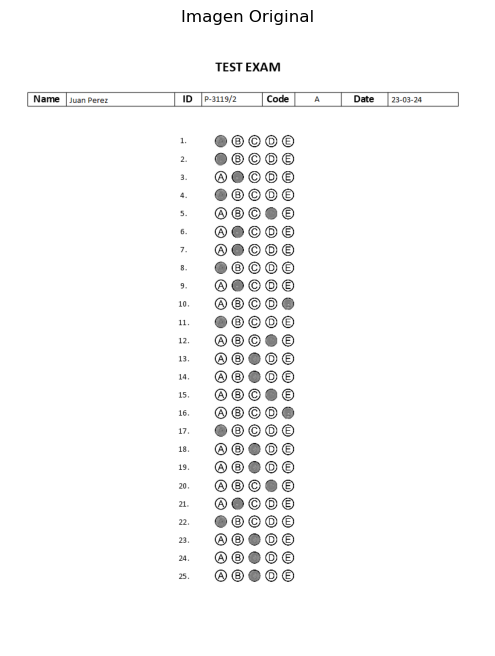

1. Obteniendo imagen binaria...


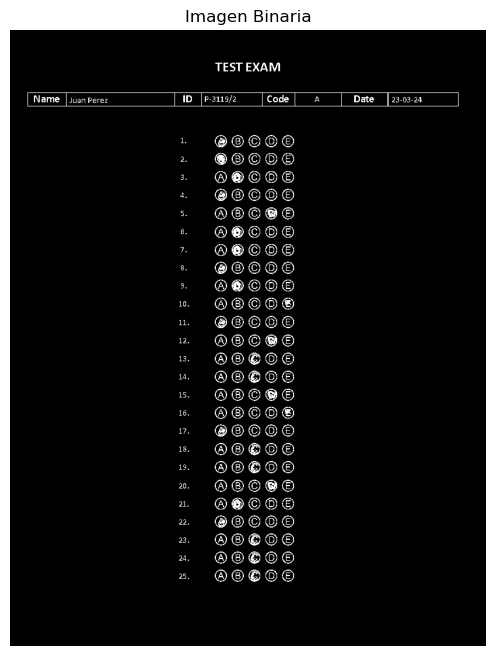

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


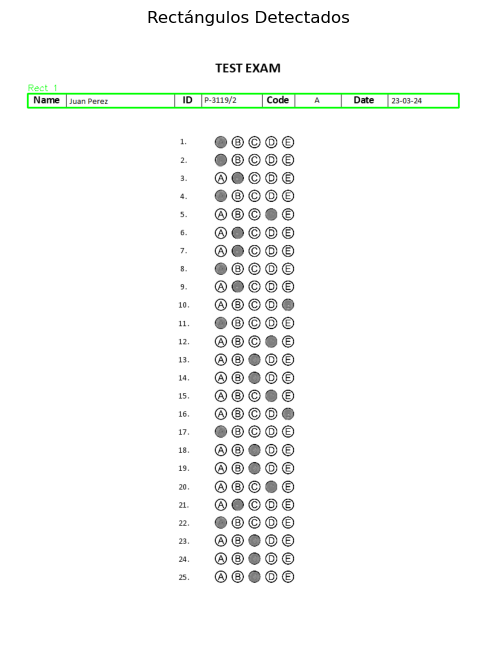

3. Dividiendo el rectángulo en celdas...


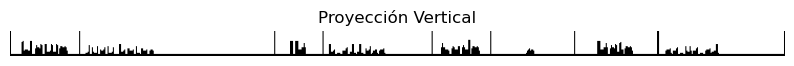

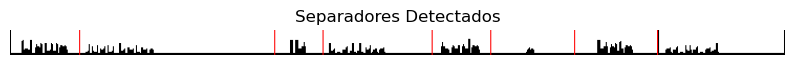

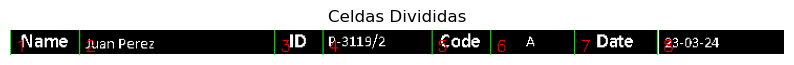

   Se dividió el rectángulo en 8 celdas


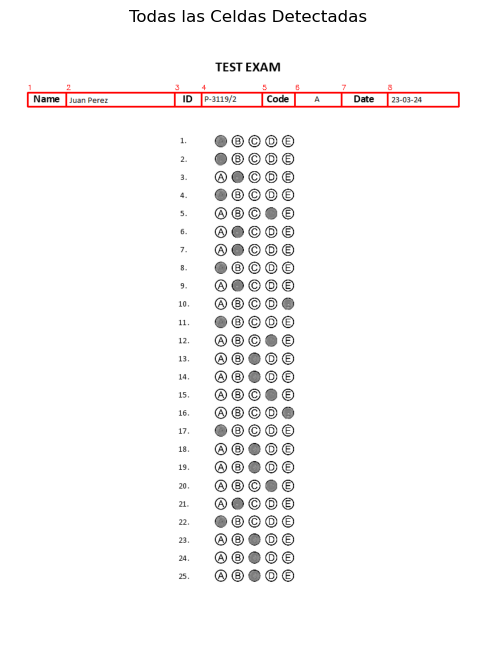

Mostrando celdas individuales:


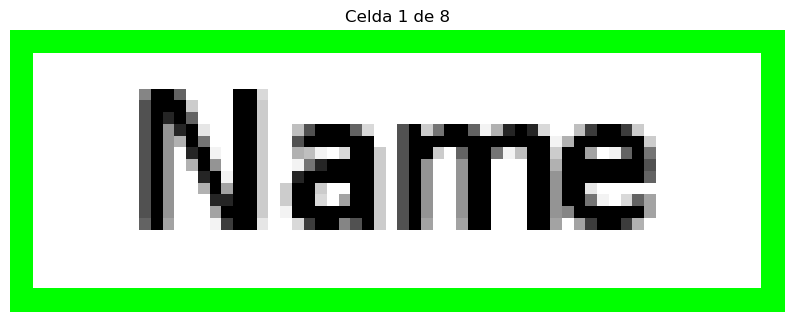

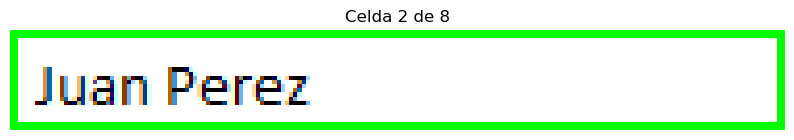

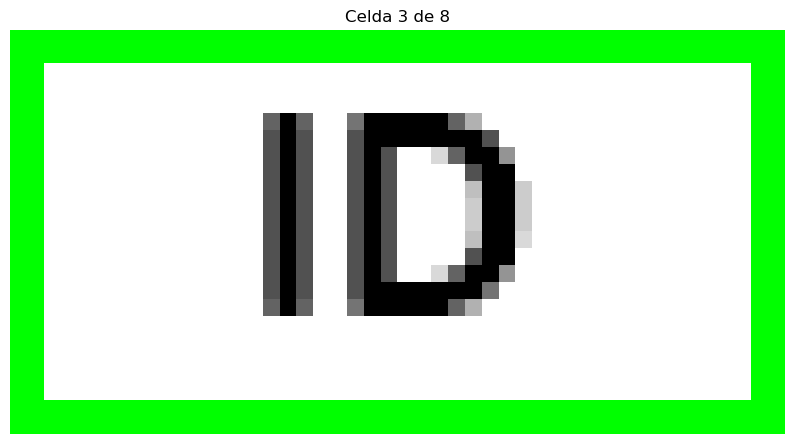

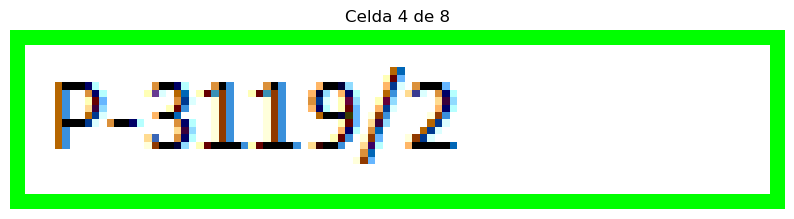

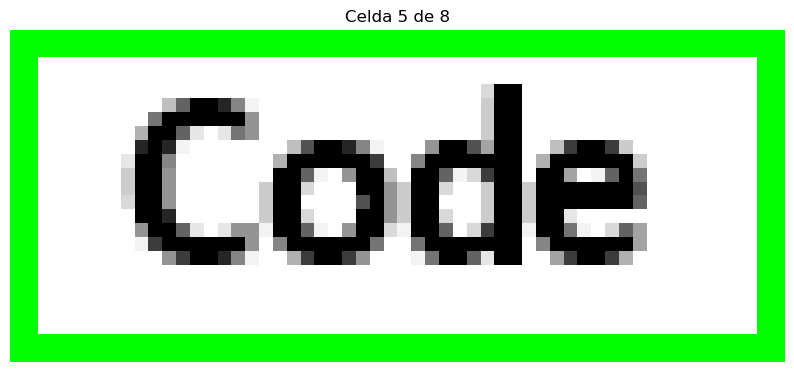

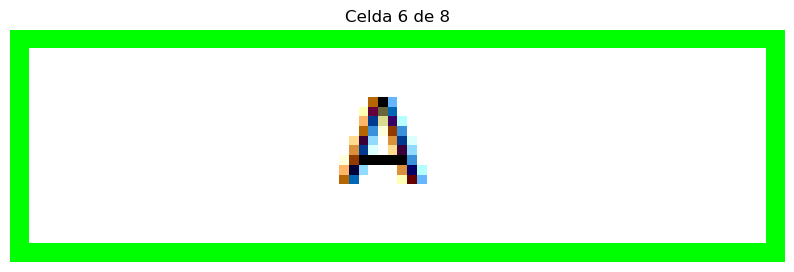

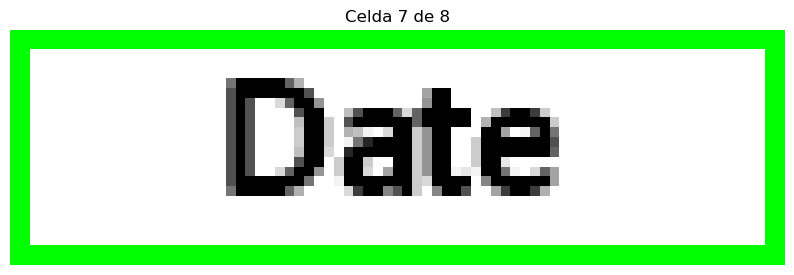

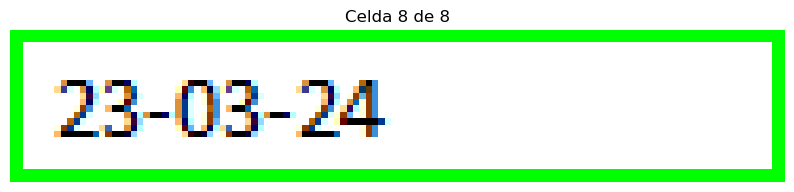

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


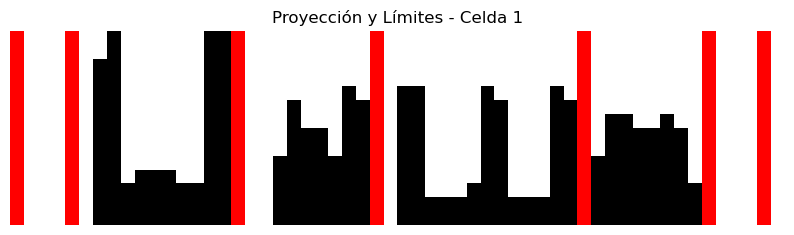

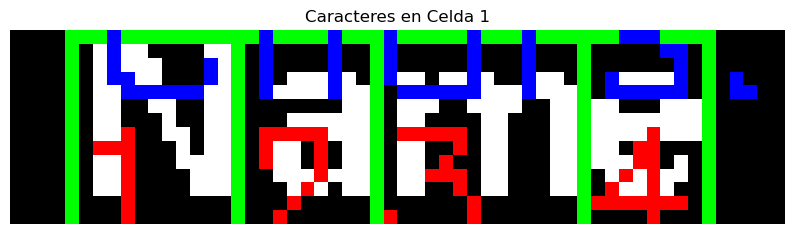

   Celda 1: 4 caracteres, 1 palabras


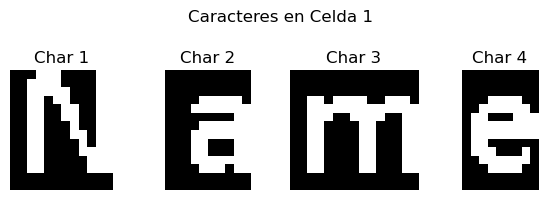


   Procesando Celda 2:


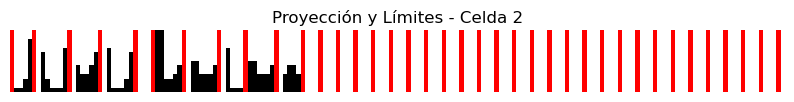

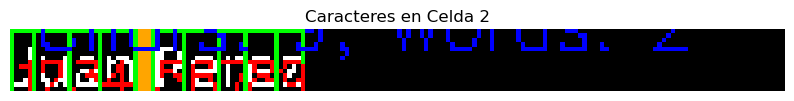

   Celda 2: 9 caracteres, 2 palabras


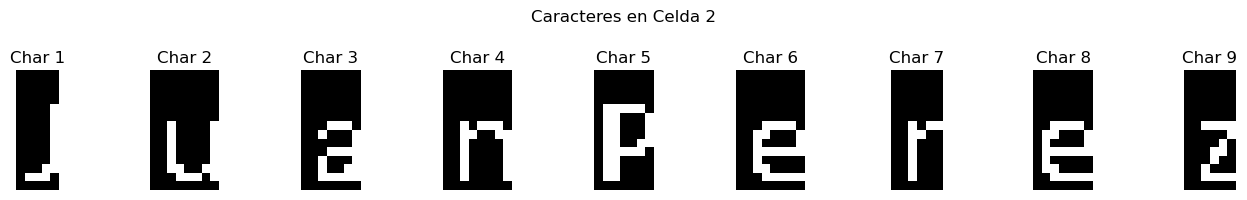


   Procesando Celda 3:


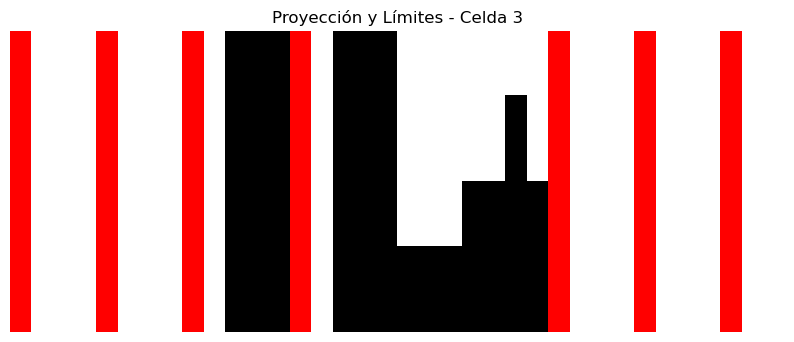

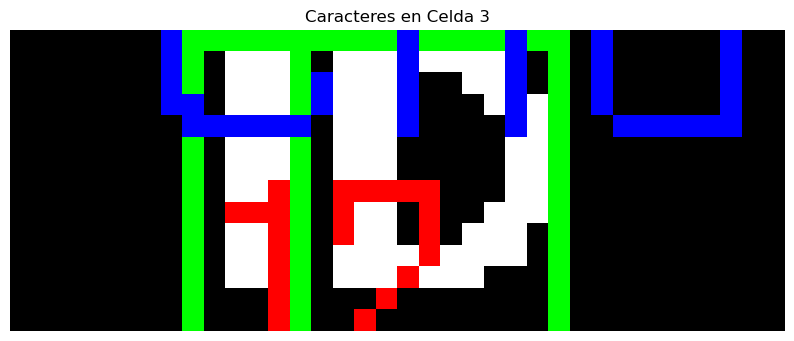

   Celda 3: 2 caracteres, 1 palabras


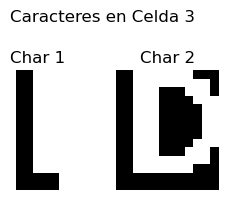


   Procesando Celda 4:


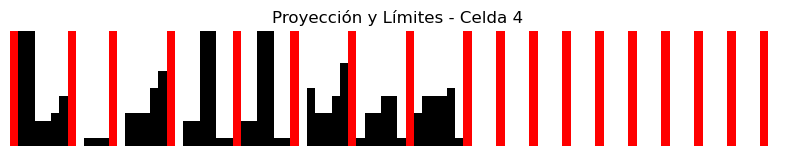

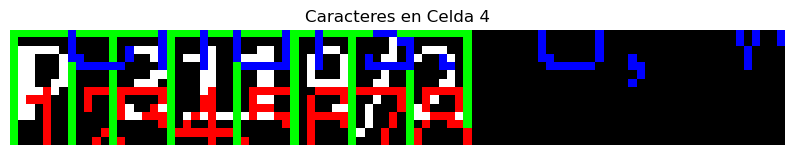

   Celda 4: 8 caracteres, 1 palabras


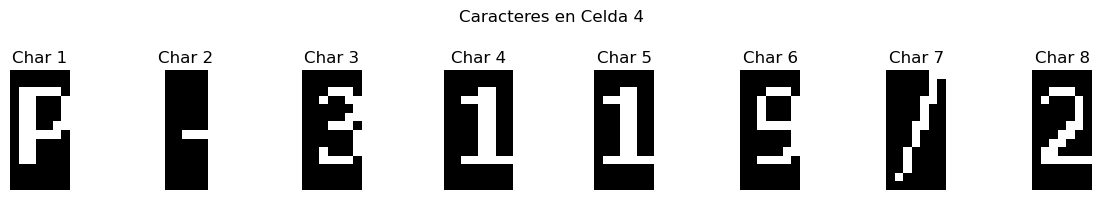


   Procesando Celda 5:


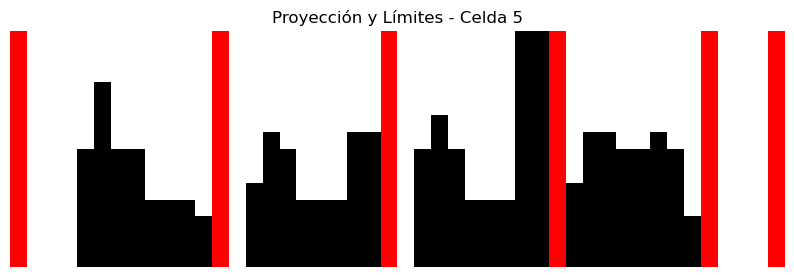

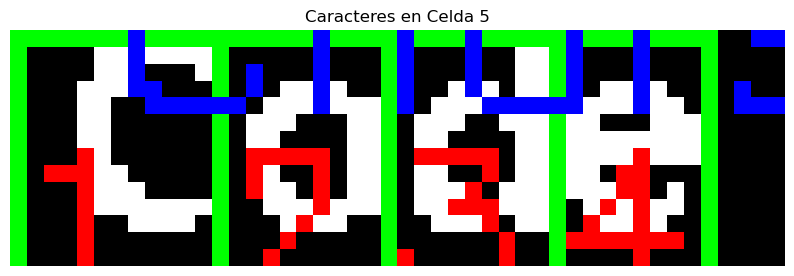

   Celda 5: 4 caracteres, 1 palabras


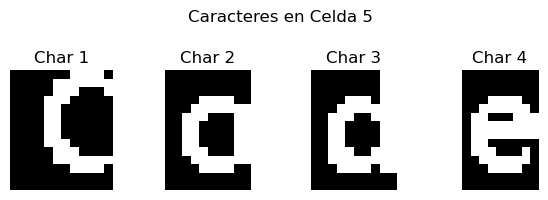


   Procesando Celda 6:


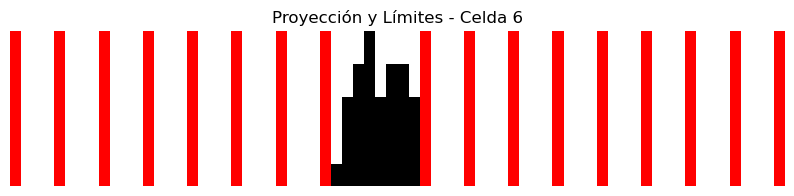

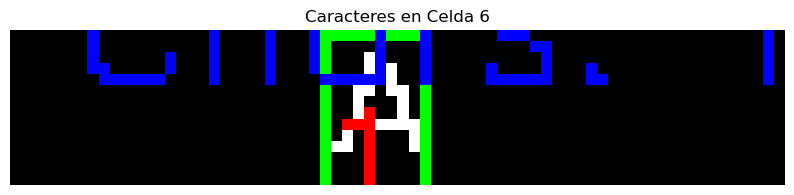

   Celda 6: 1 caracteres, 1 palabras


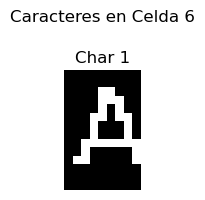


   Procesando Celda 7:


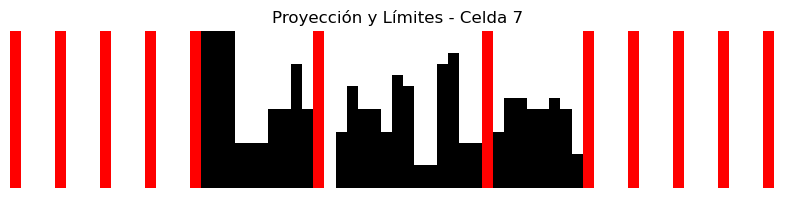

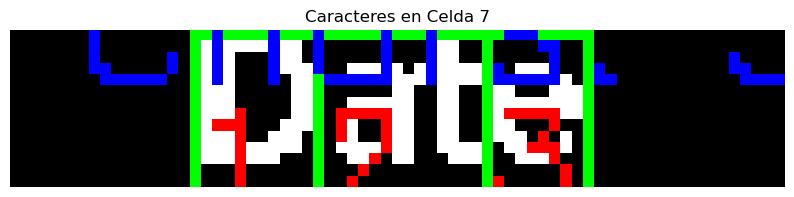

   Celda 7: 3 caracteres, 1 palabras


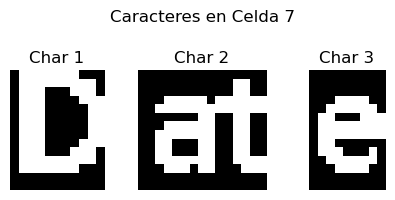


   Procesando Celda 8:


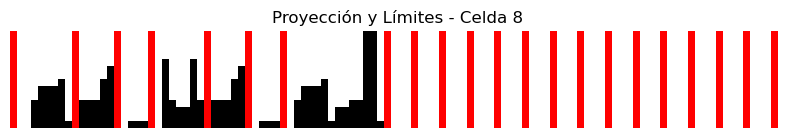

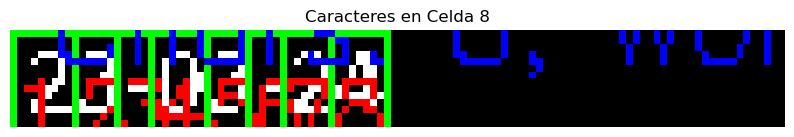

   Celda 8: 8 caracteres, 1 palabras


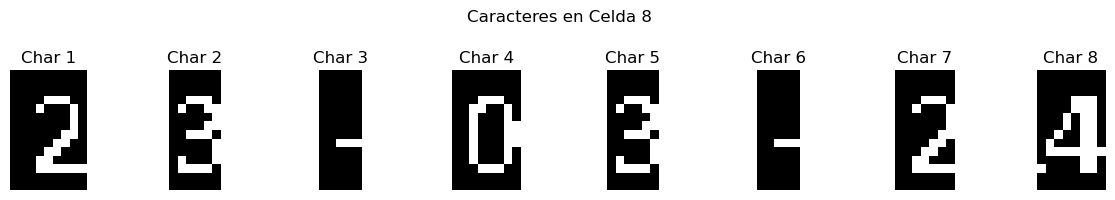

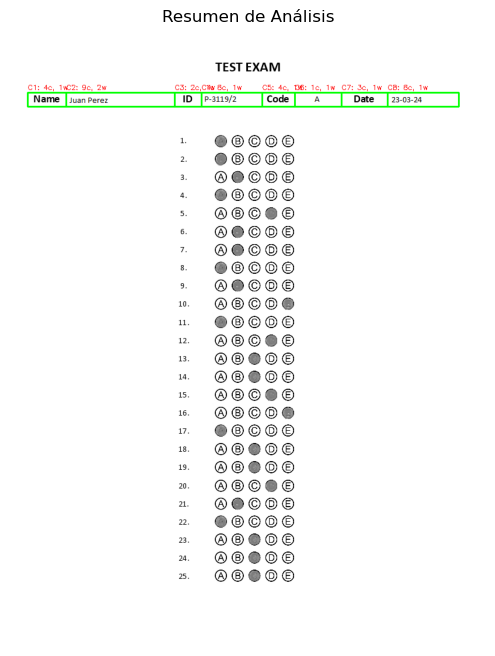


Procesamiento completado con éxito.


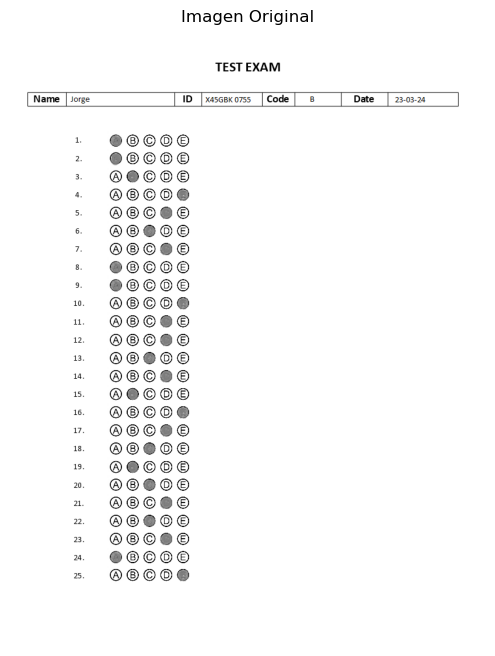

1. Obteniendo imagen binaria...


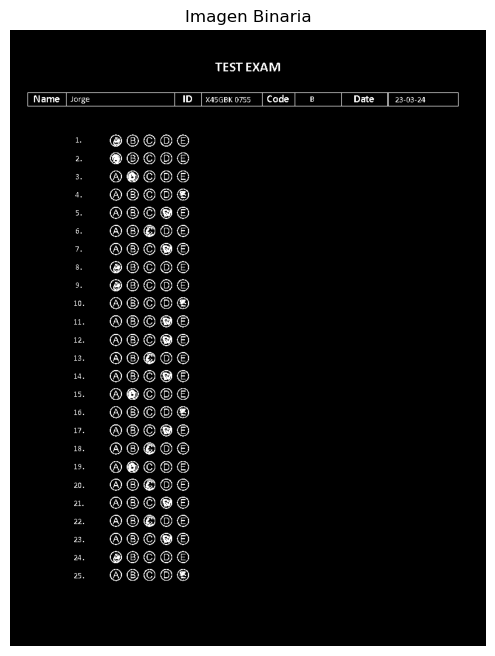

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


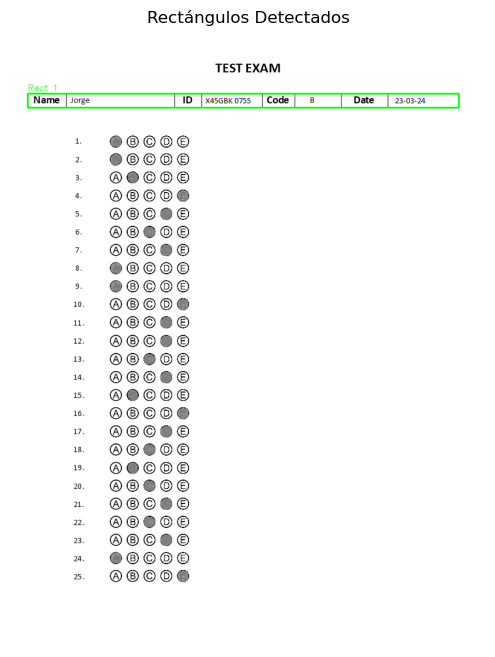

3. Dividiendo el rectángulo en celdas...


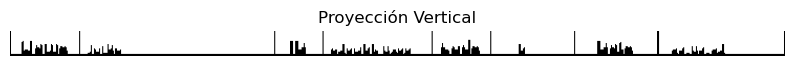

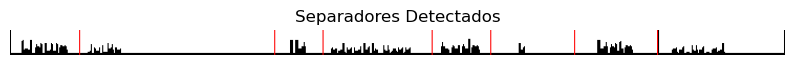

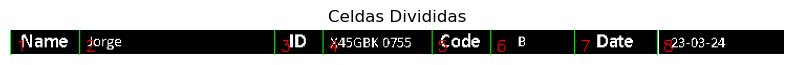

   Se dividió el rectángulo en 8 celdas


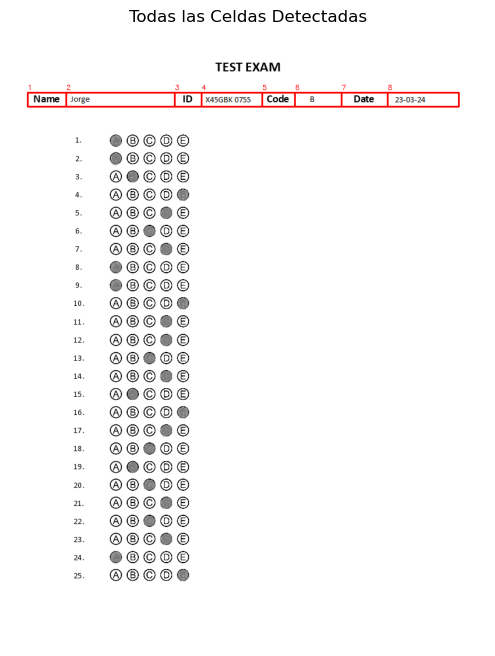

Mostrando celdas individuales:


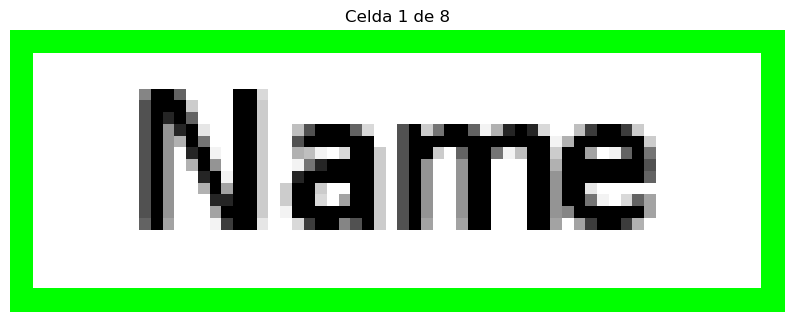

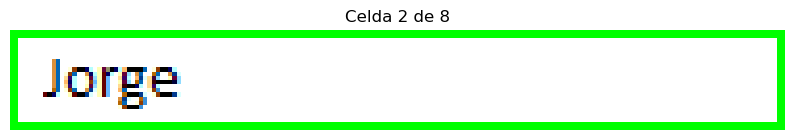

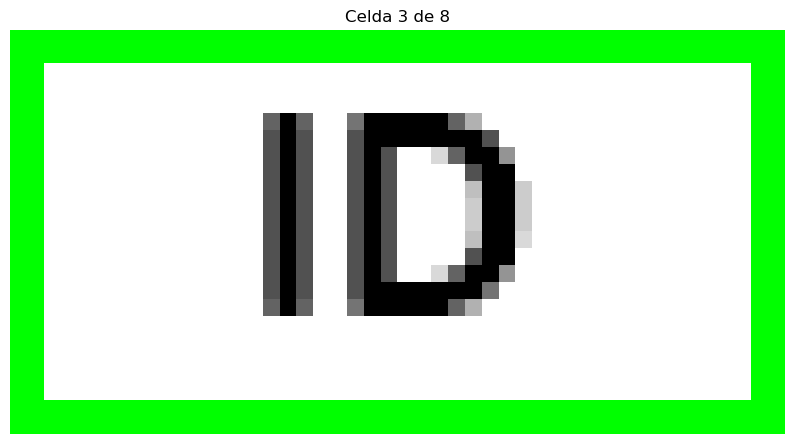

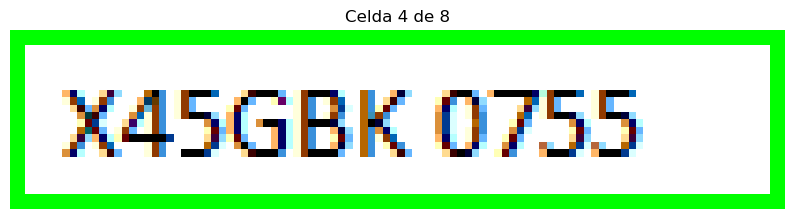

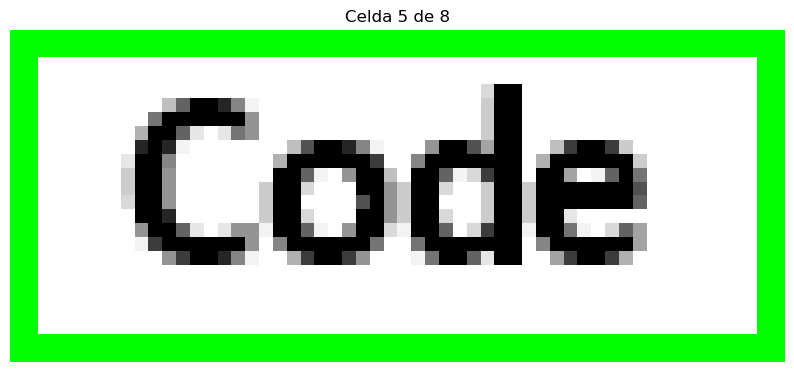

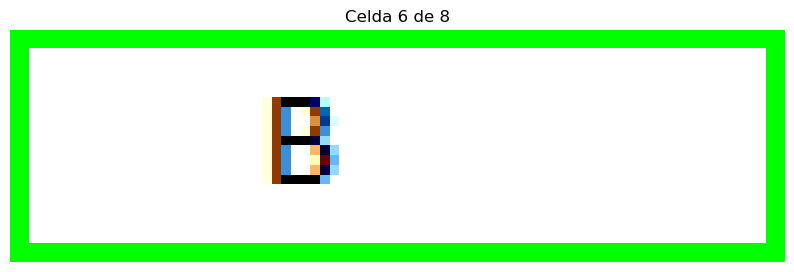

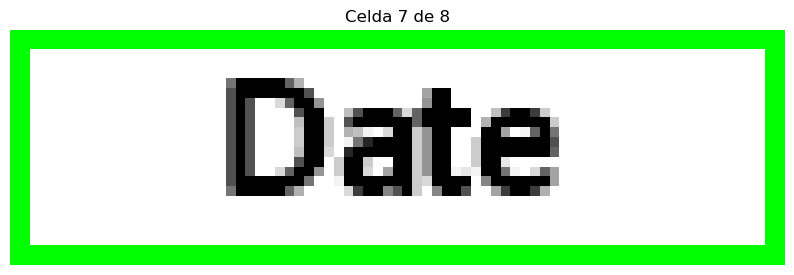

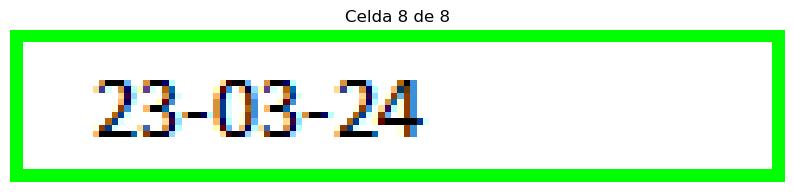

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


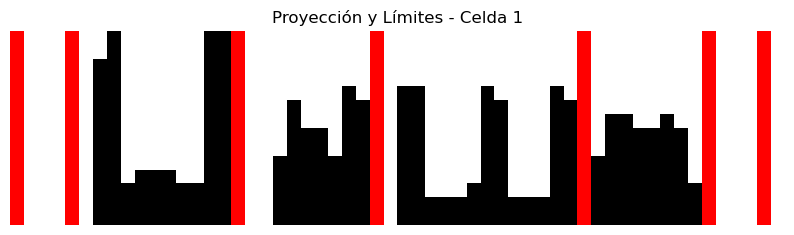

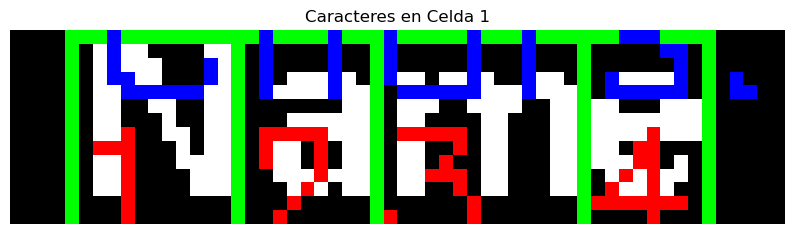

   Celda 1: 4 caracteres, 1 palabras


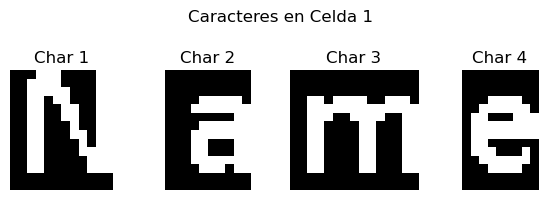


   Procesando Celda 2:


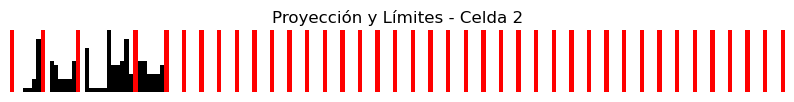

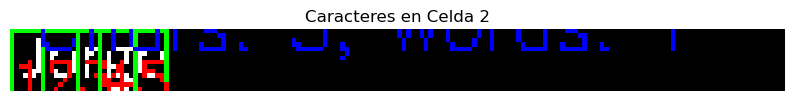

   Celda 2: 5 caracteres, 1 palabras


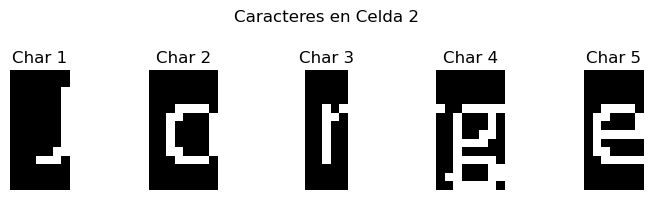


   Procesando Celda 3:


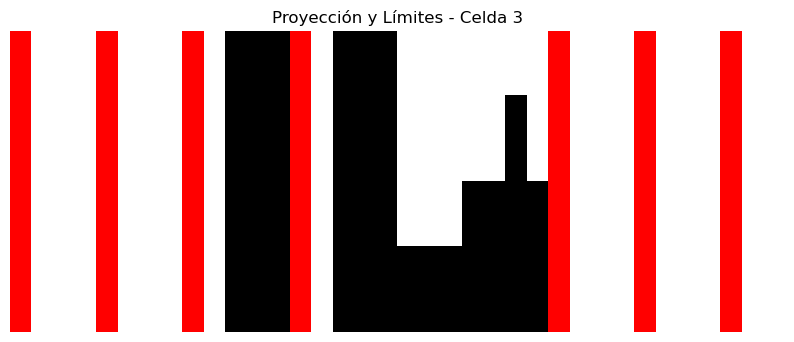

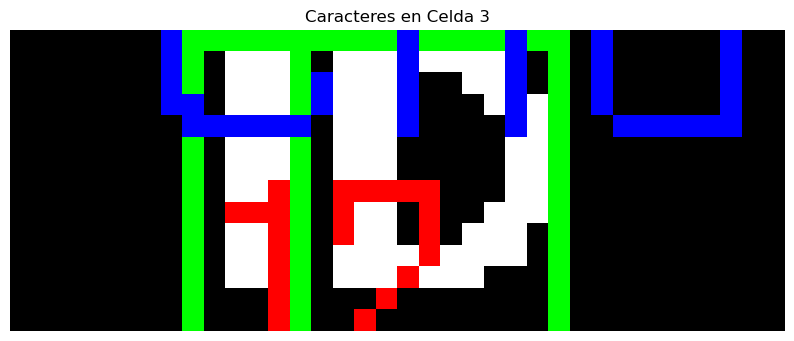

   Celda 3: 2 caracteres, 1 palabras


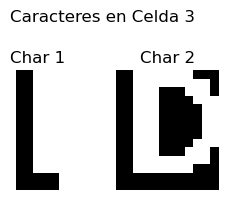


   Procesando Celda 4:


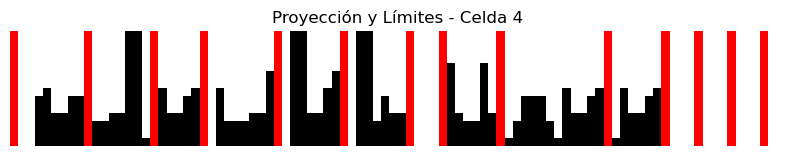

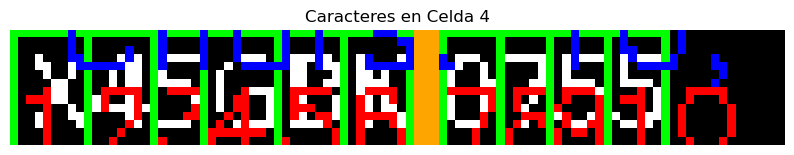

   Celda 4: 10 caracteres, 2 palabras


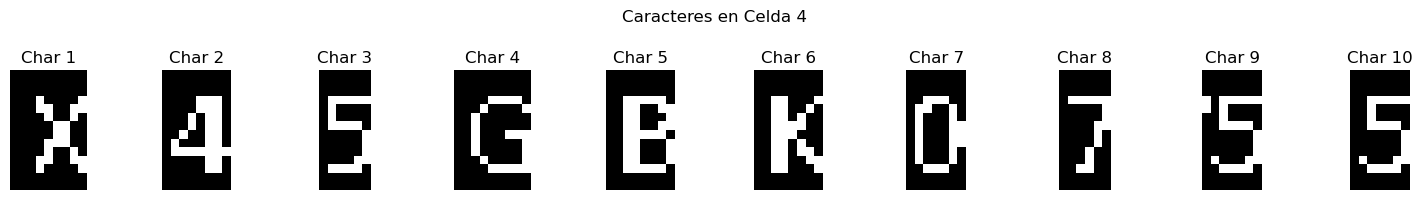


   Procesando Celda 5:


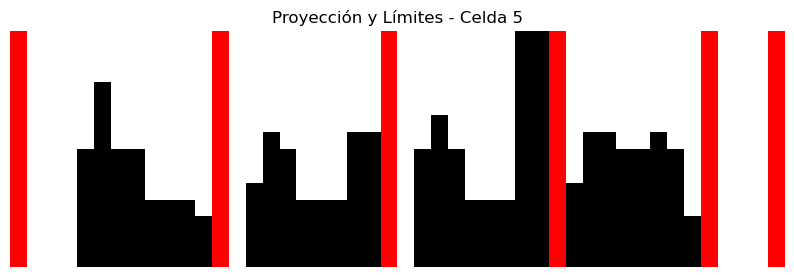

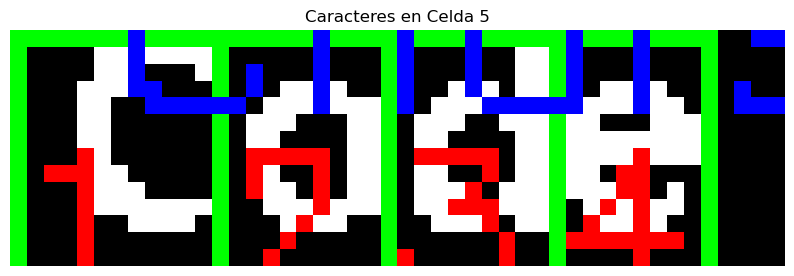

   Celda 5: 4 caracteres, 1 palabras


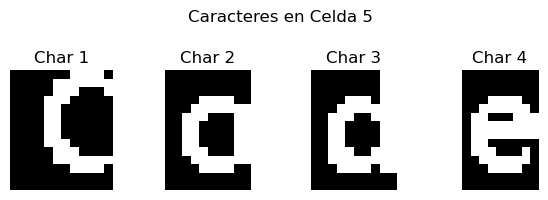


   Procesando Celda 6:


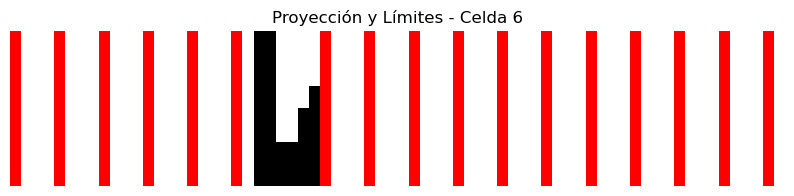

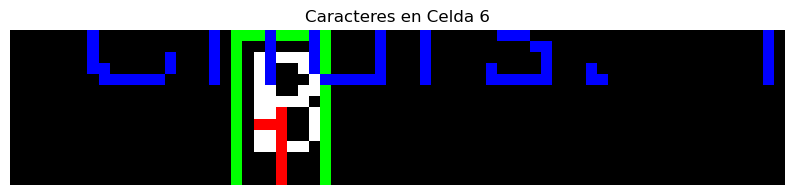

   Celda 6: 1 caracteres, 1 palabras


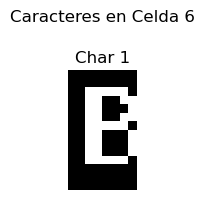


   Procesando Celda 7:


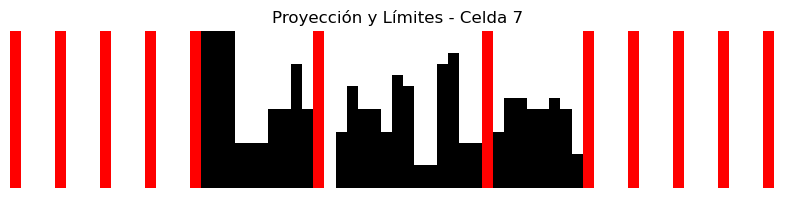

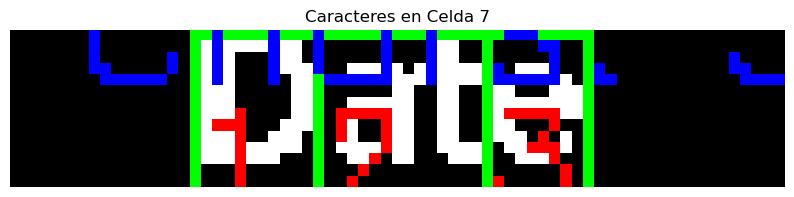

   Celda 7: 3 caracteres, 1 palabras


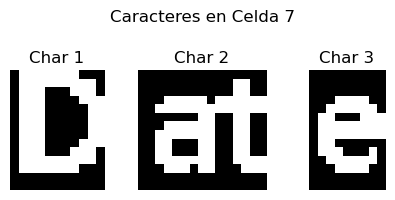


   Procesando Celda 8:


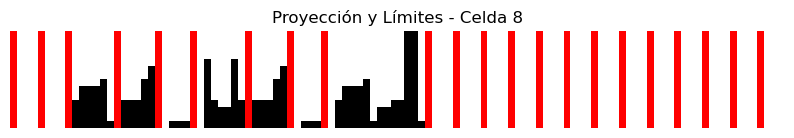

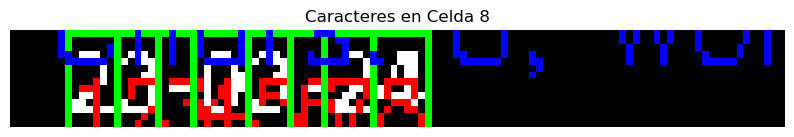

   Celda 8: 8 caracteres, 1 palabras


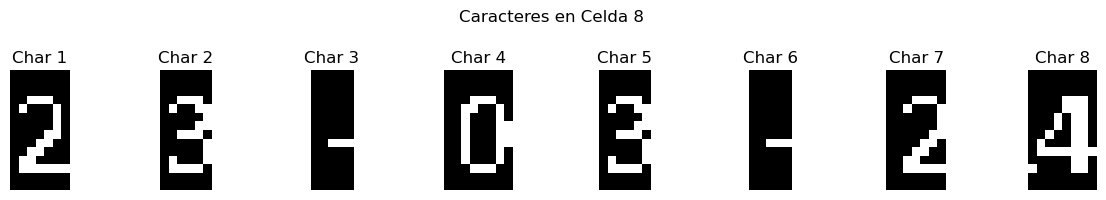

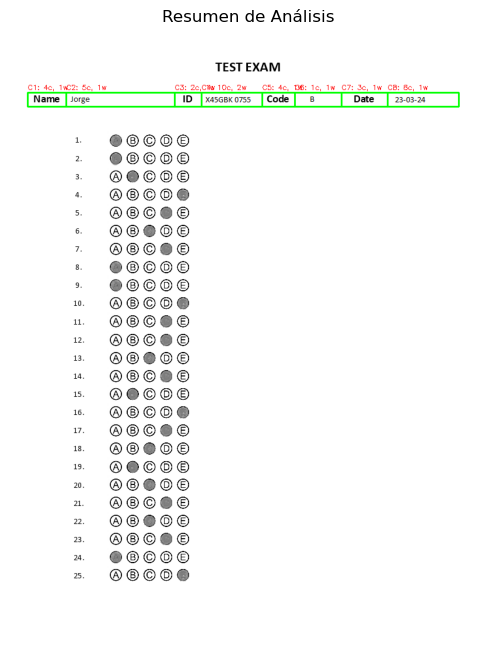


Procesamiento completado con éxito.


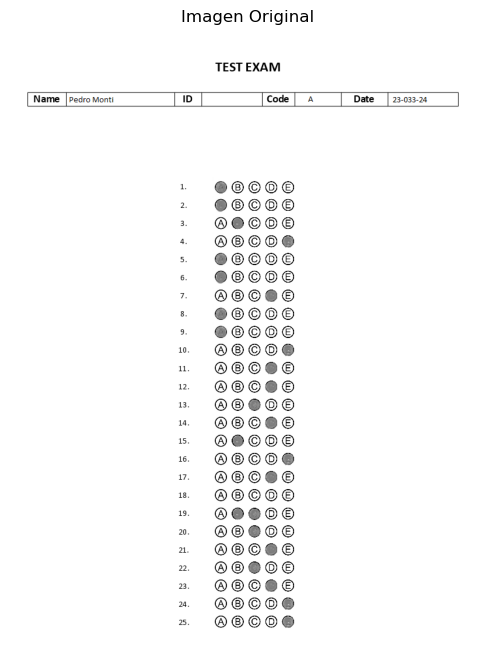

1. Obteniendo imagen binaria...


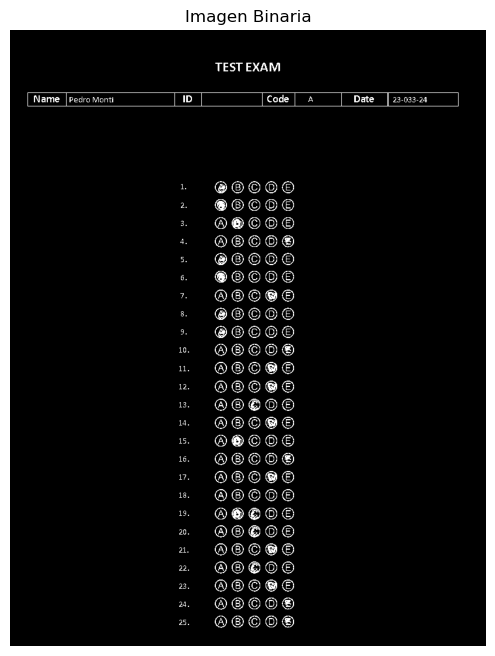

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


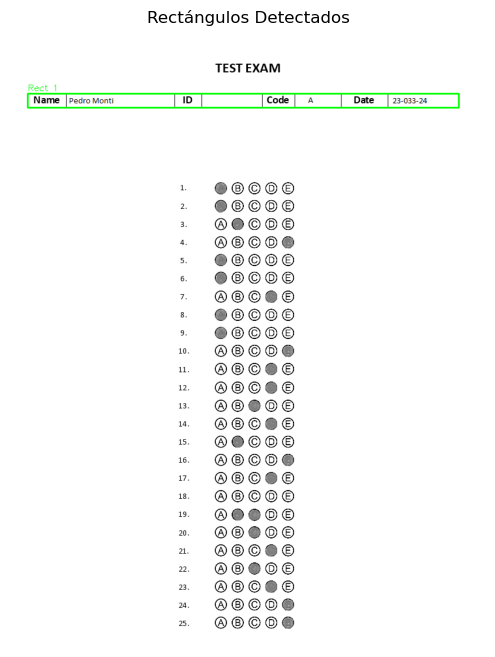

3. Dividiendo el rectángulo en celdas...


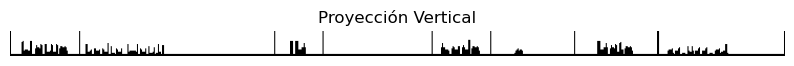

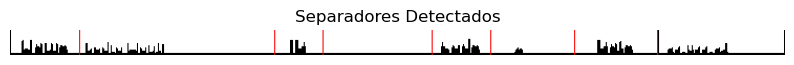

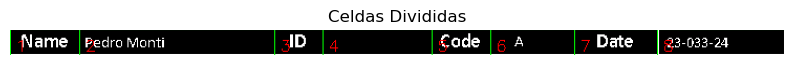

   Se dividió el rectángulo en 8 celdas


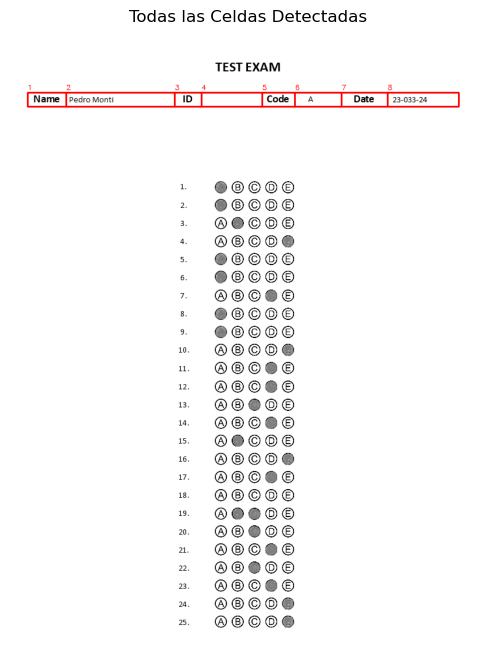

Mostrando celdas individuales:


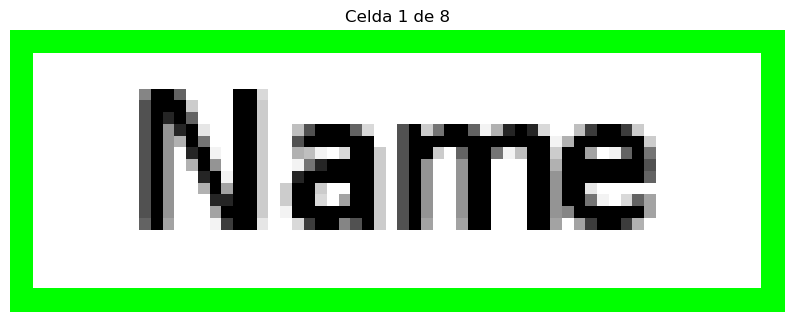

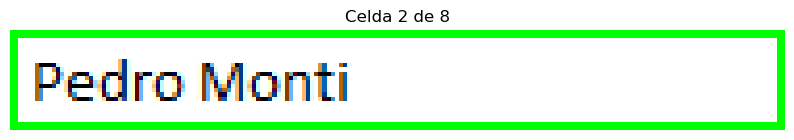

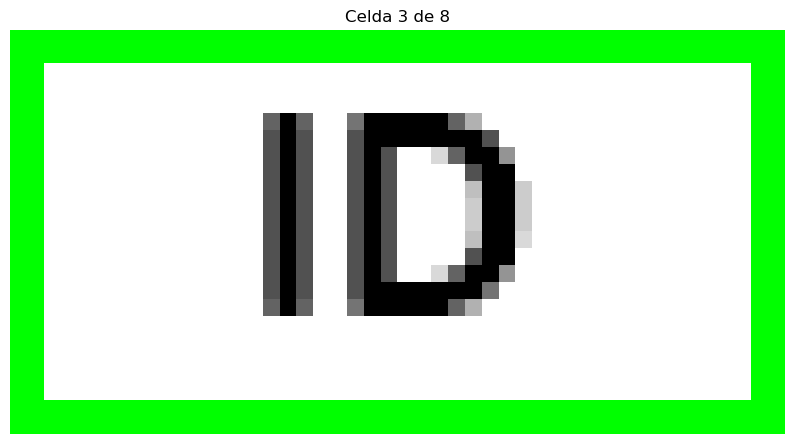

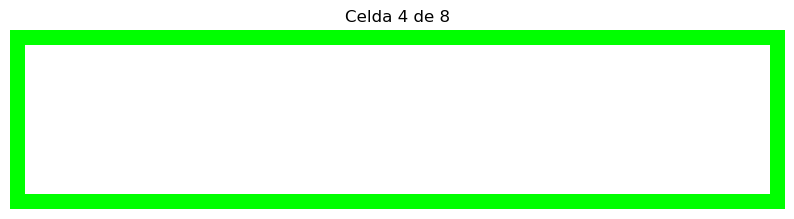

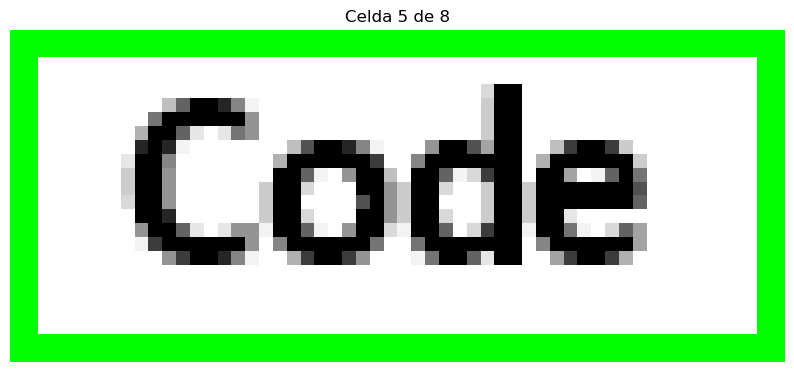

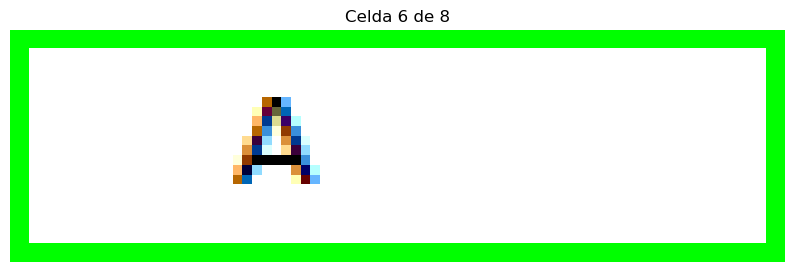

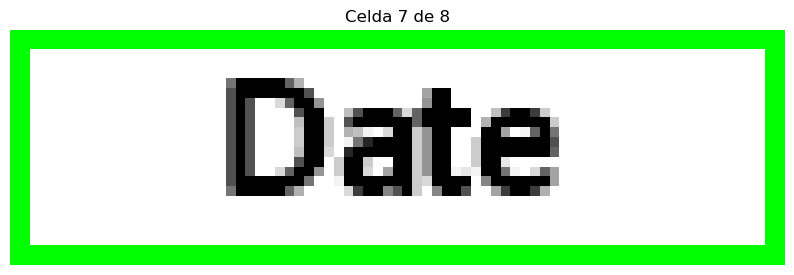

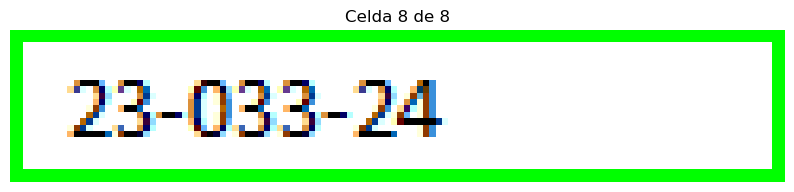

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


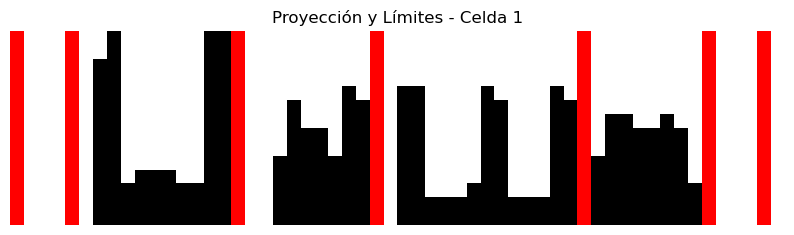

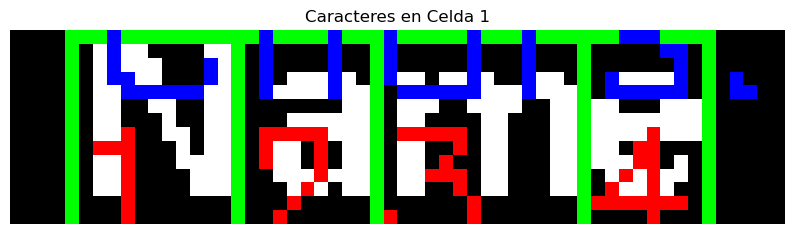

   Celda 1: 4 caracteres, 1 palabras


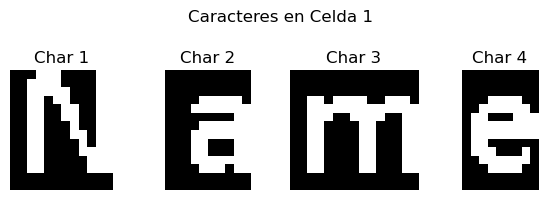


   Procesando Celda 2:


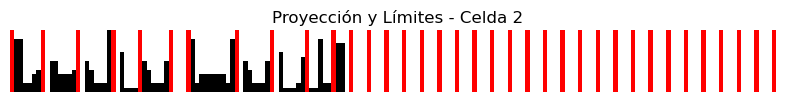

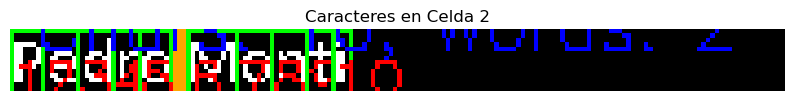

   Celda 2: 10 caracteres, 2 palabras


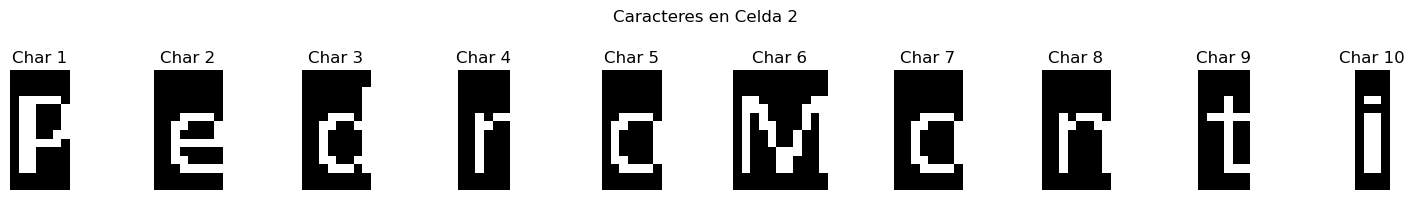


   Procesando Celda 3:


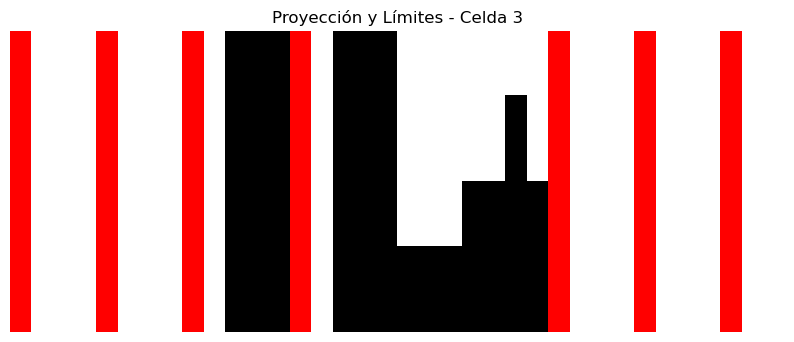

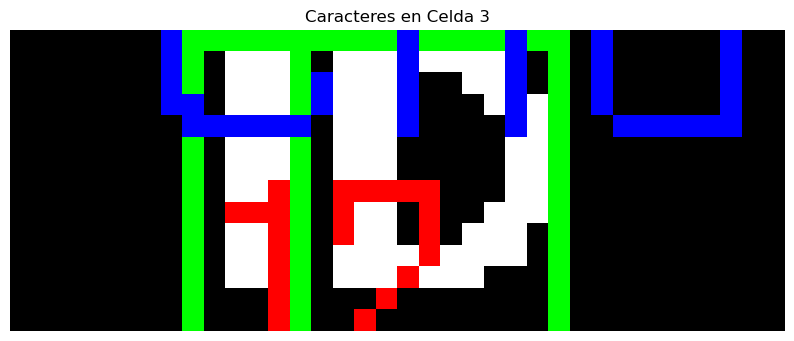

   Celda 3: 2 caracteres, 1 palabras


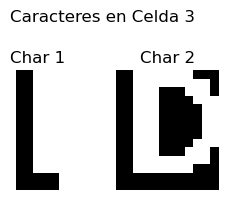


   Procesando Celda 4:


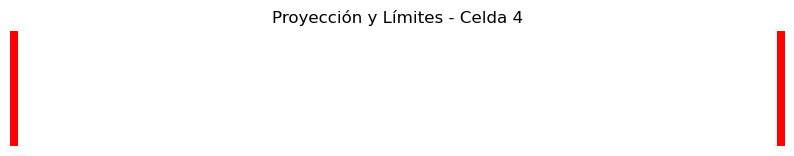

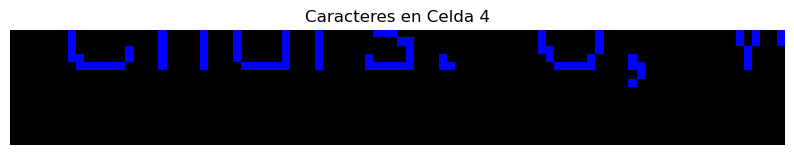

   Celda 4: 0 caracteres, 0 palabras

   Procesando Celda 5:


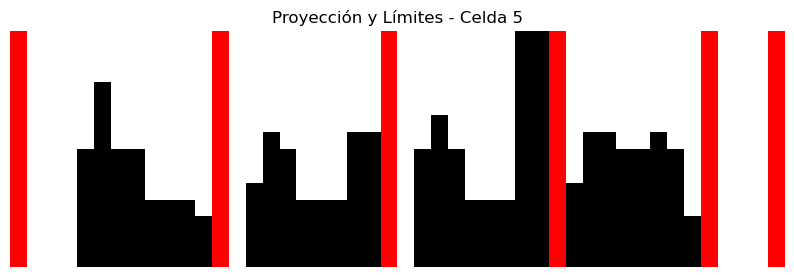

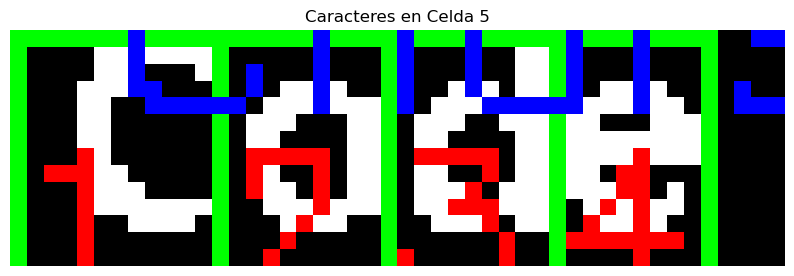

   Celda 5: 4 caracteres, 1 palabras


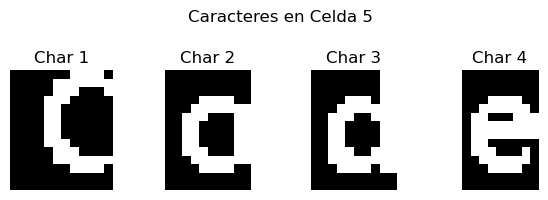


   Procesando Celda 6:


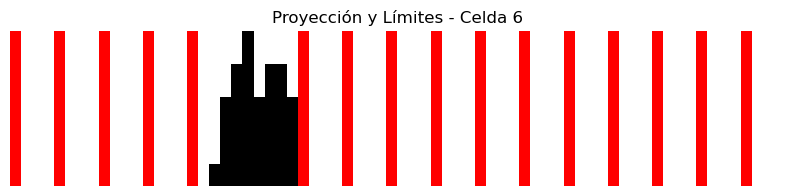

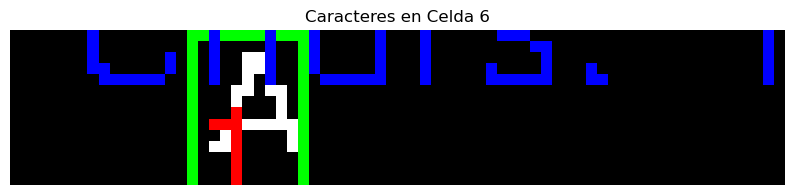

   Celda 6: 1 caracteres, 1 palabras


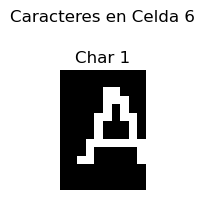


   Procesando Celda 7:


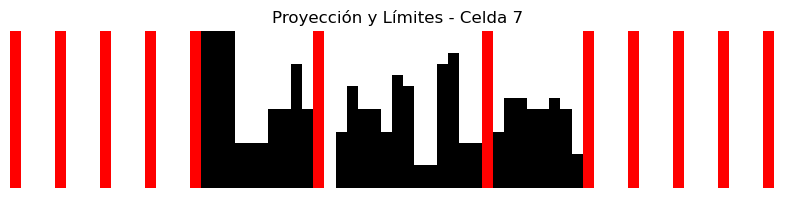

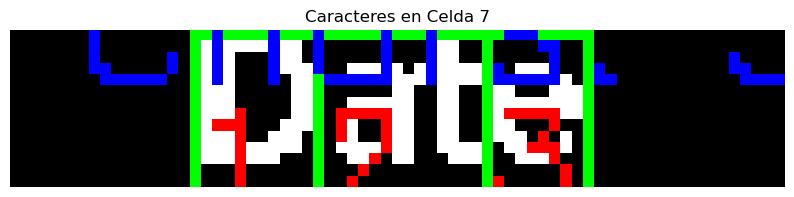

   Celda 7: 3 caracteres, 1 palabras


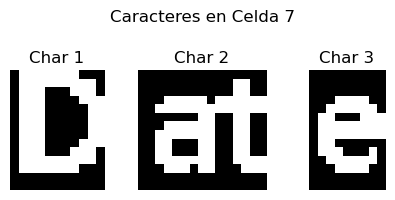


   Procesando Celda 8:


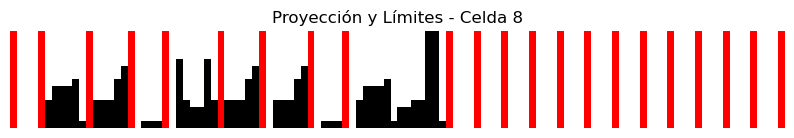

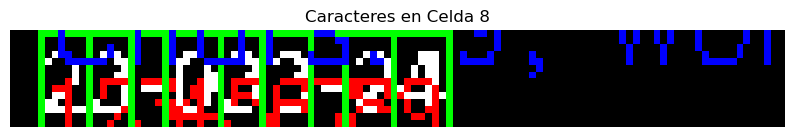

   Celda 8: 9 caracteres, 1 palabras


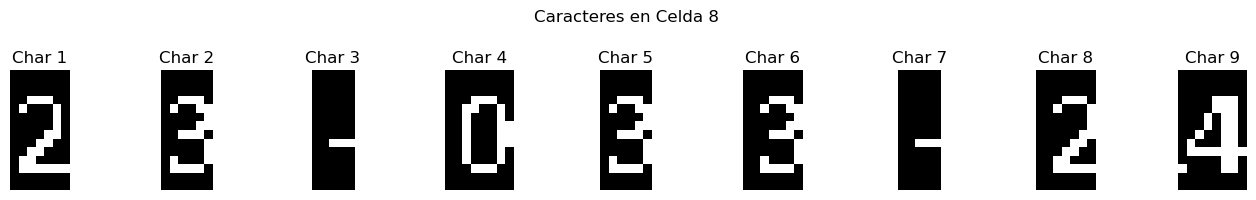

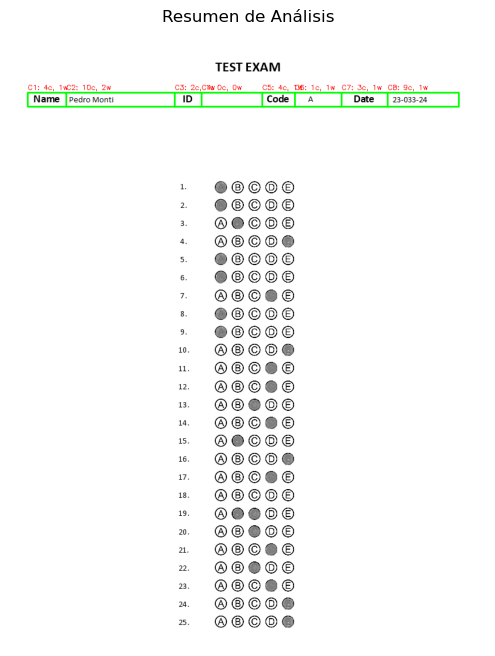


Procesamiento completado con éxito.


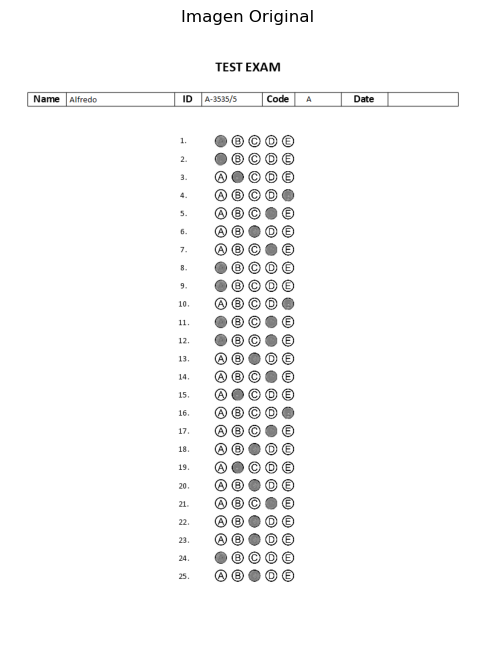

1. Obteniendo imagen binaria...


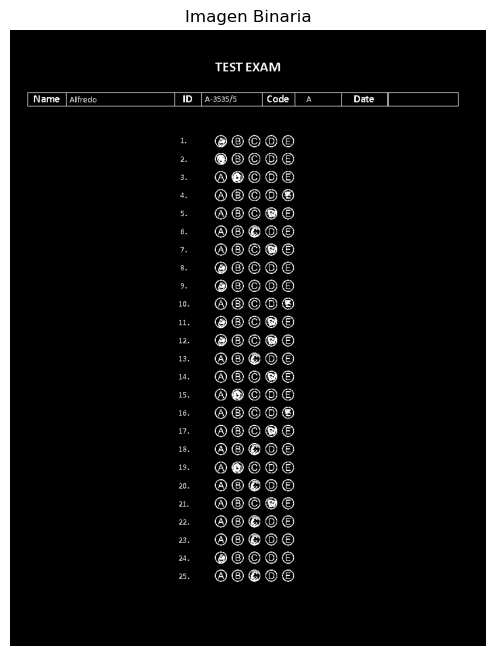

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


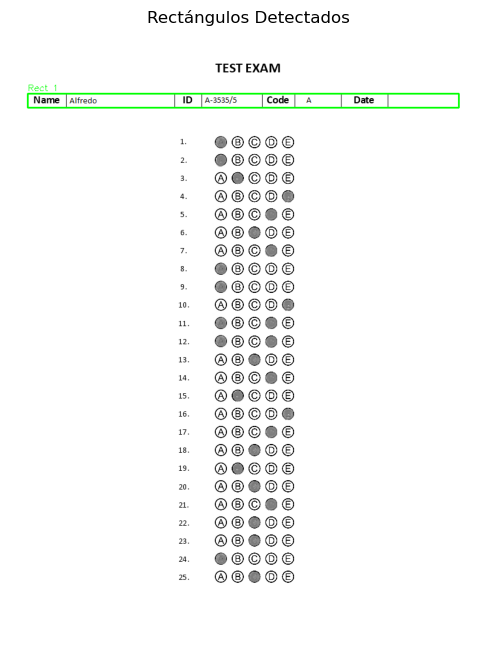

3. Dividiendo el rectángulo en celdas...


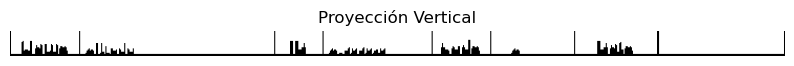

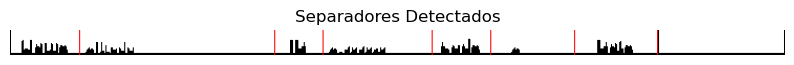

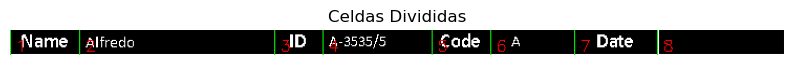

   Se dividió el rectángulo en 8 celdas


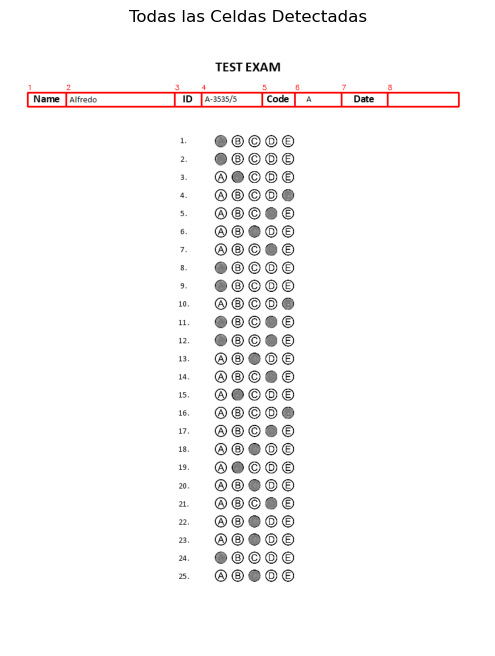

Mostrando celdas individuales:


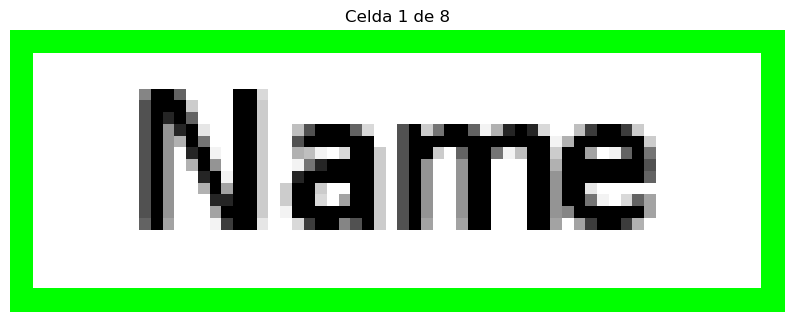

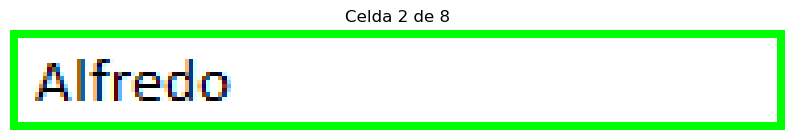

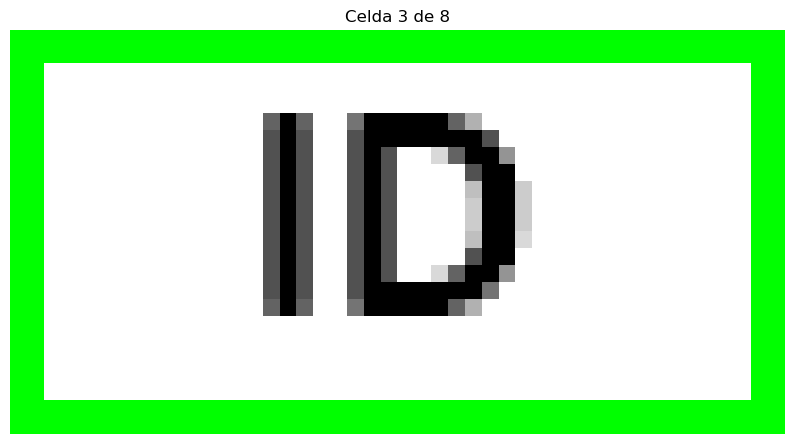

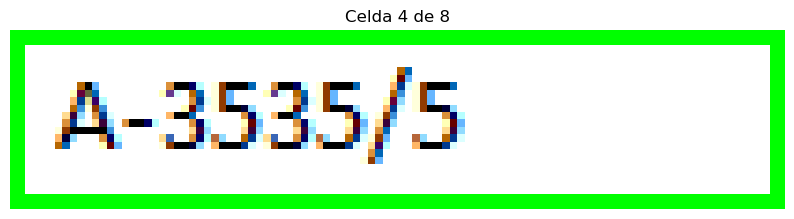

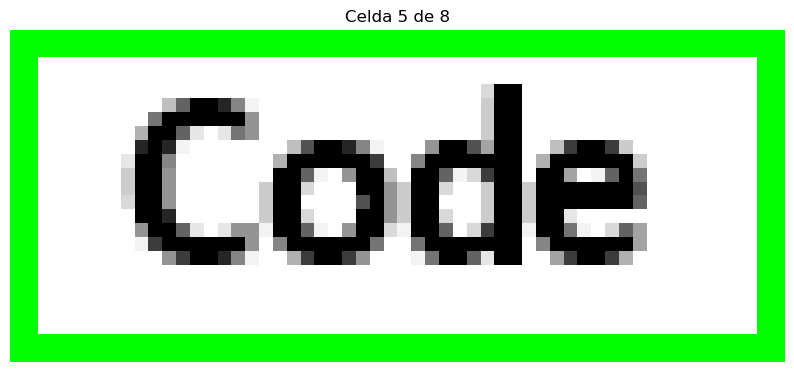

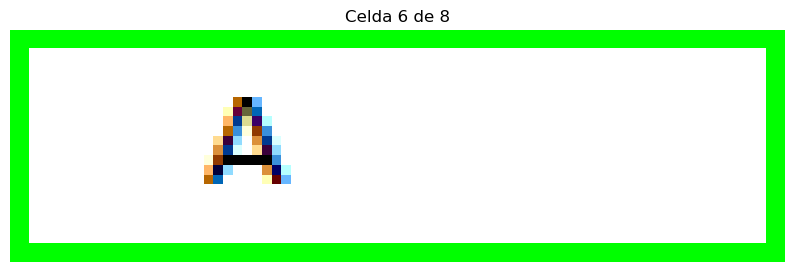

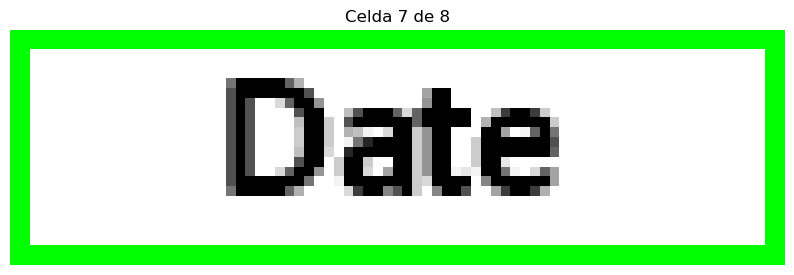

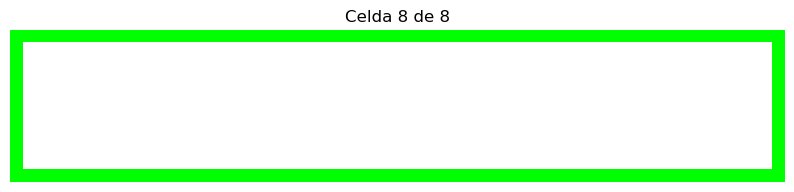

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


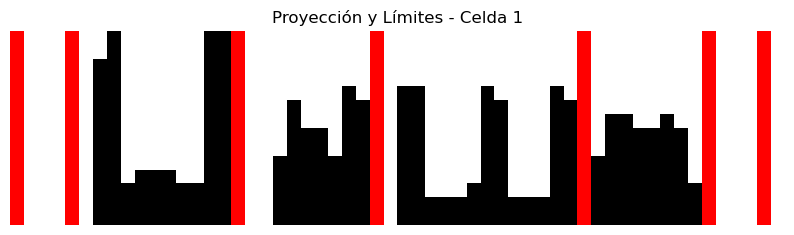

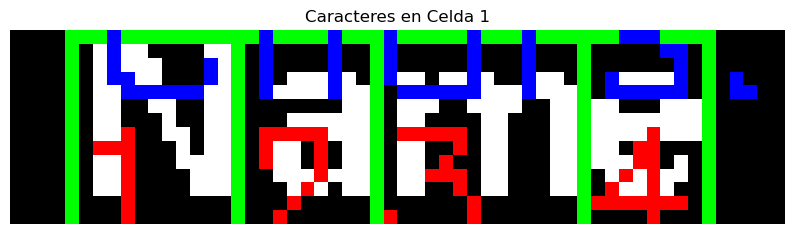

   Celda 1: 4 caracteres, 1 palabras


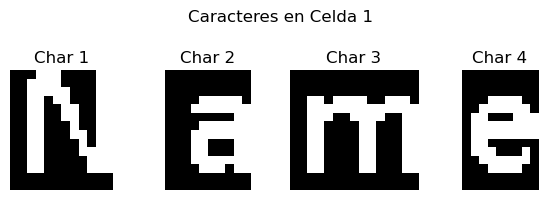


   Procesando Celda 2:


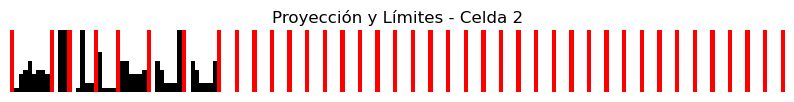

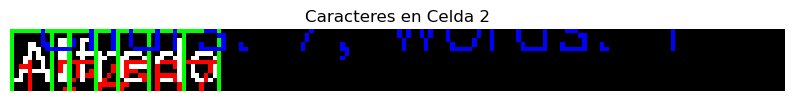

   Celda 2: 7 caracteres, 1 palabras


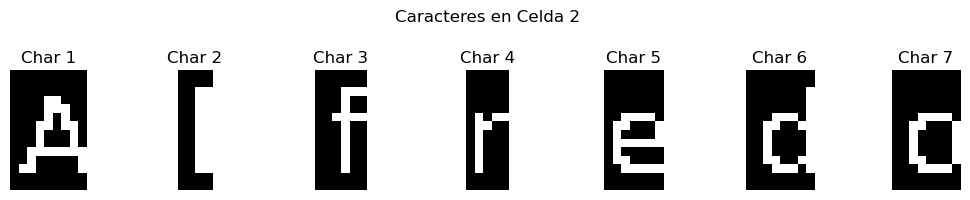


   Procesando Celda 3:


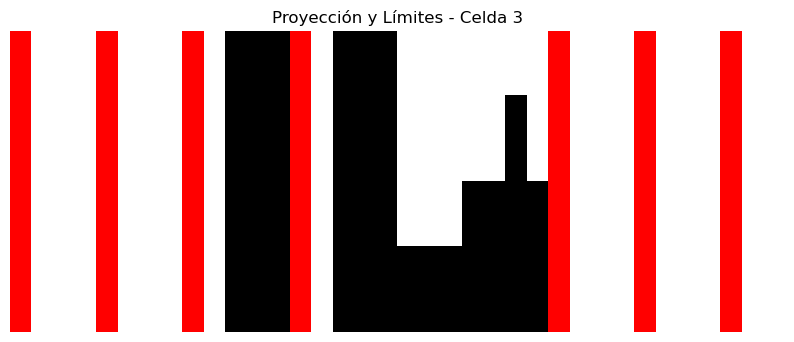

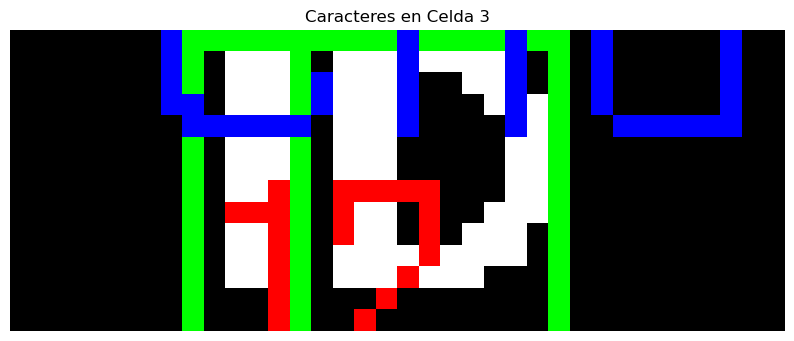

   Celda 3: 2 caracteres, 1 palabras


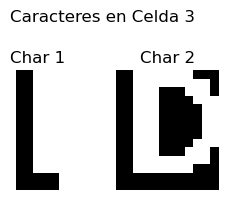


   Procesando Celda 4:


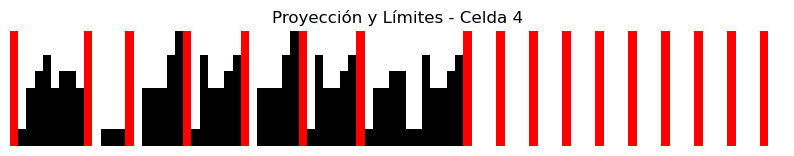

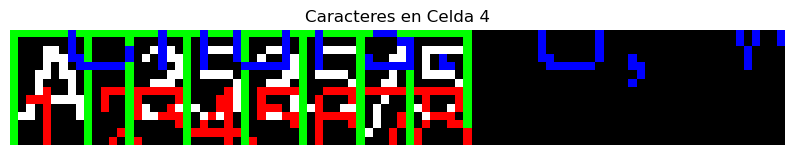

   Celda 4: 8 caracteres, 1 palabras


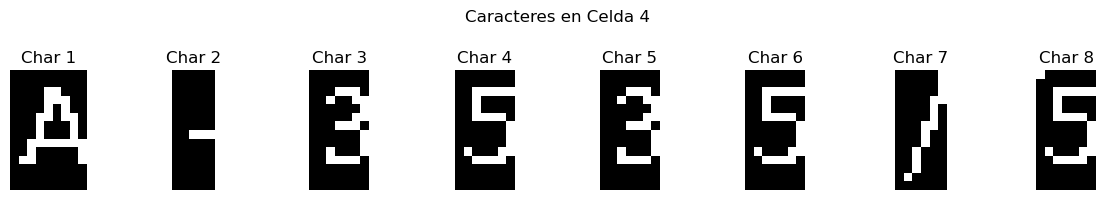


   Procesando Celda 5:


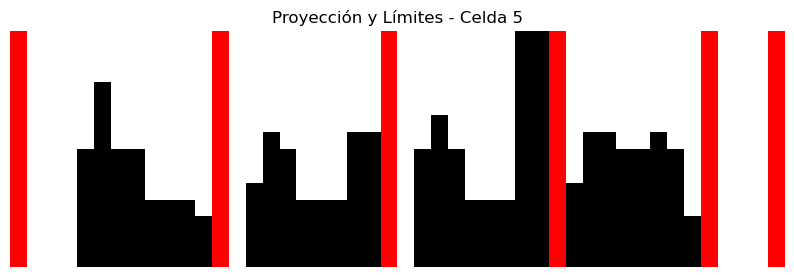

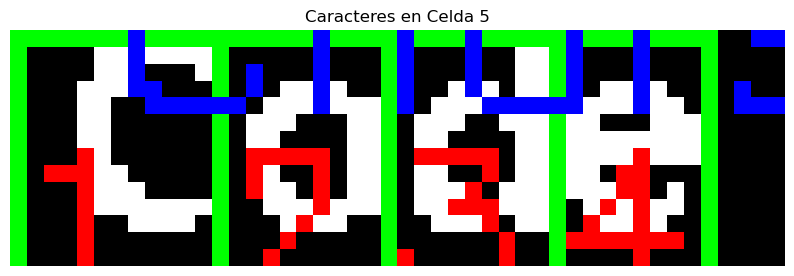

   Celda 5: 4 caracteres, 1 palabras


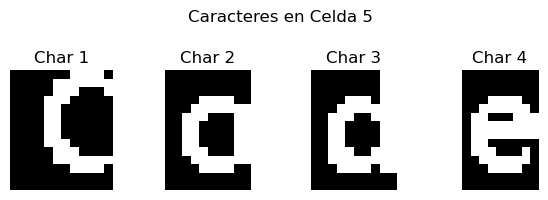


   Procesando Celda 6:


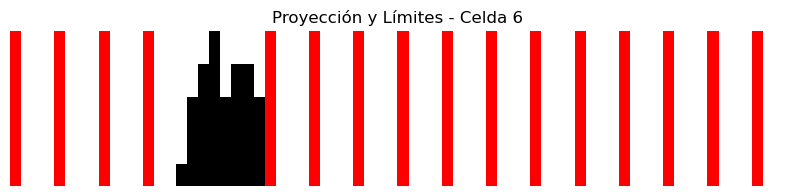

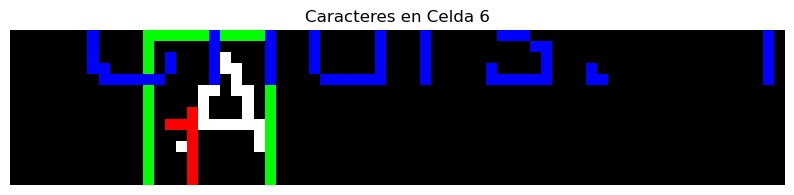

   Celda 6: 1 caracteres, 1 palabras


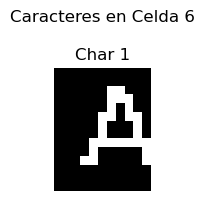


   Procesando Celda 7:


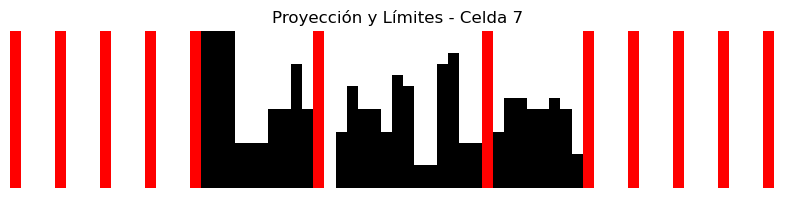

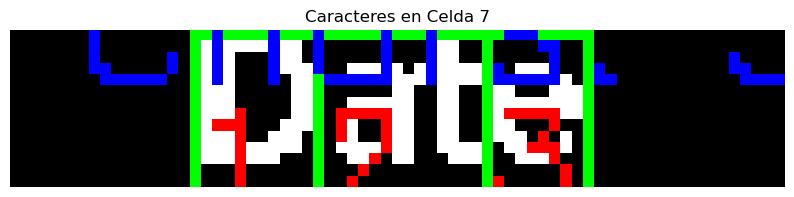

   Celda 7: 3 caracteres, 1 palabras


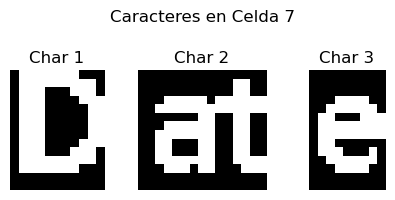


   Procesando Celda 8:


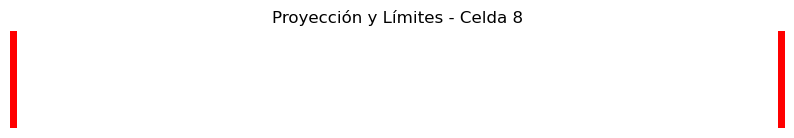

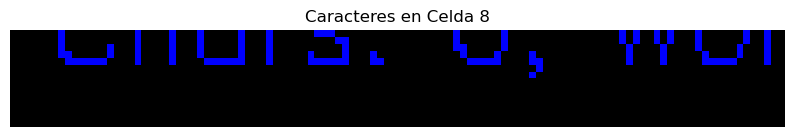

   Celda 8: 0 caracteres, 0 palabras


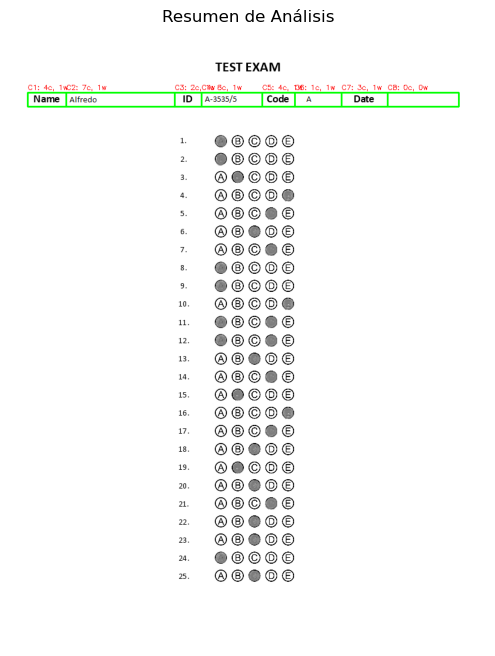


Procesamiento completado con éxito.


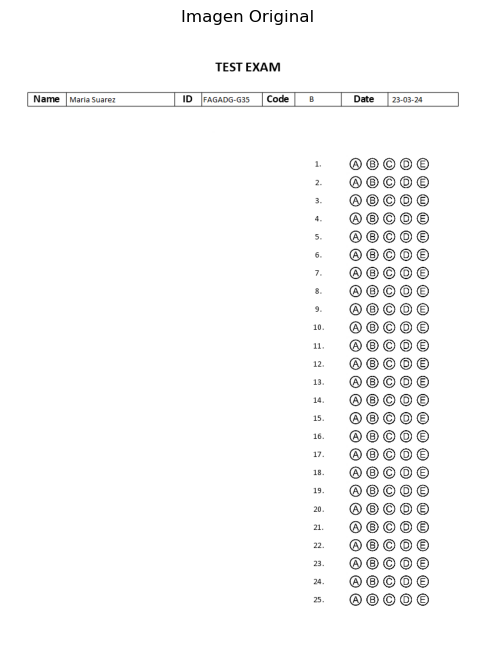

1. Obteniendo imagen binaria...


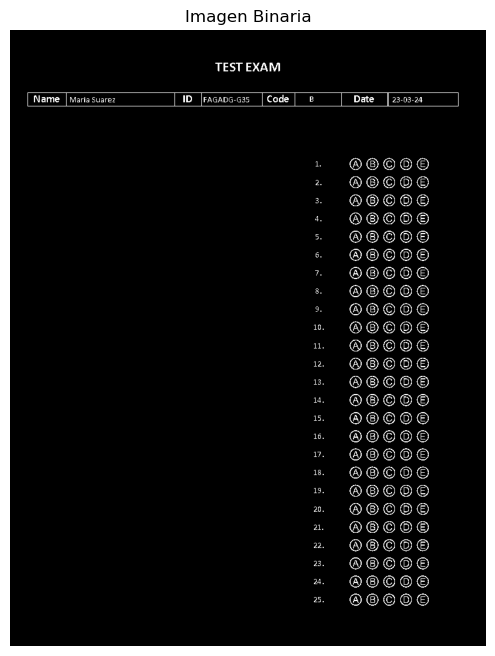

2. Detectando rectángulos...
   Se detectaron 1 rectángulos


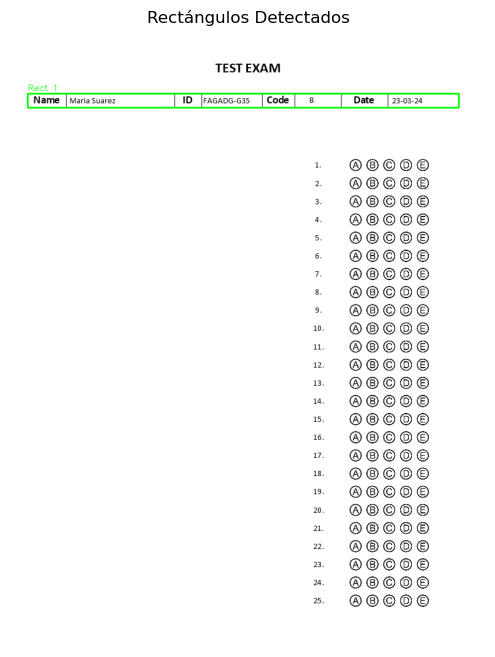

3. Dividiendo el rectángulo en celdas...


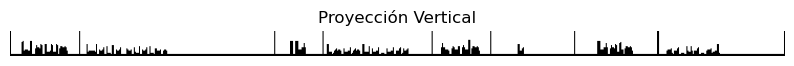

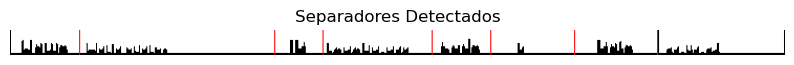

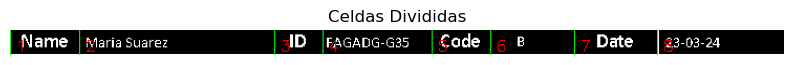

   Se dividió el rectángulo en 8 celdas


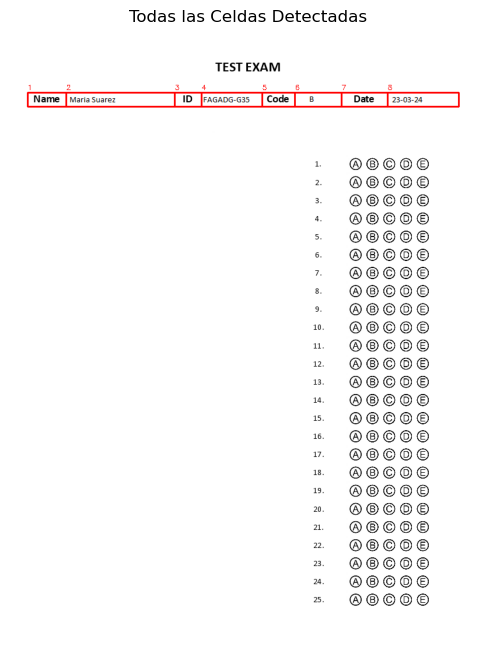

Mostrando celdas individuales:


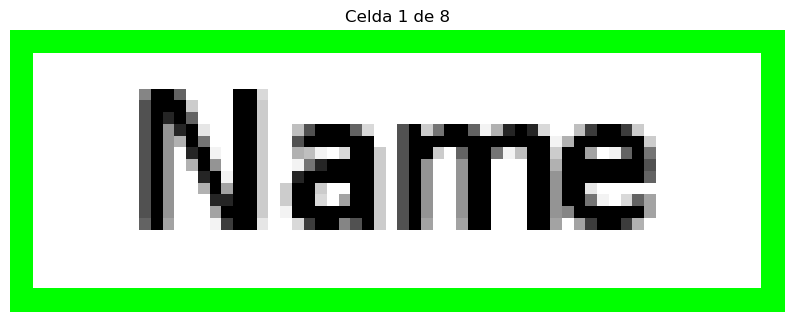

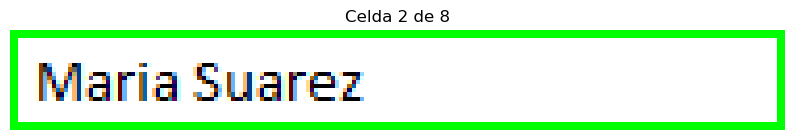

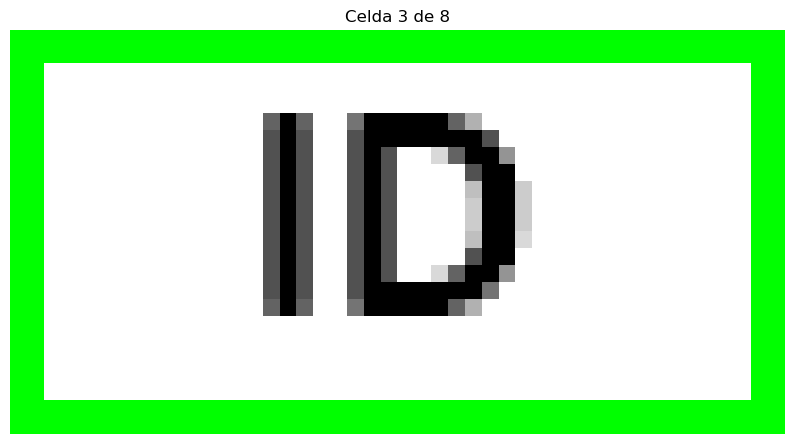

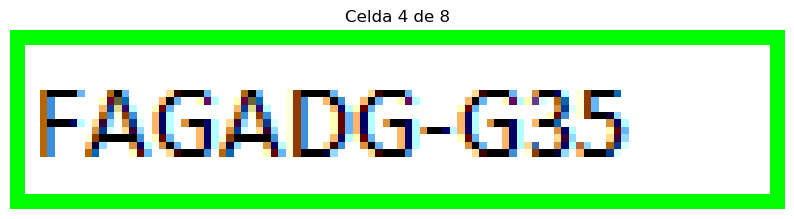

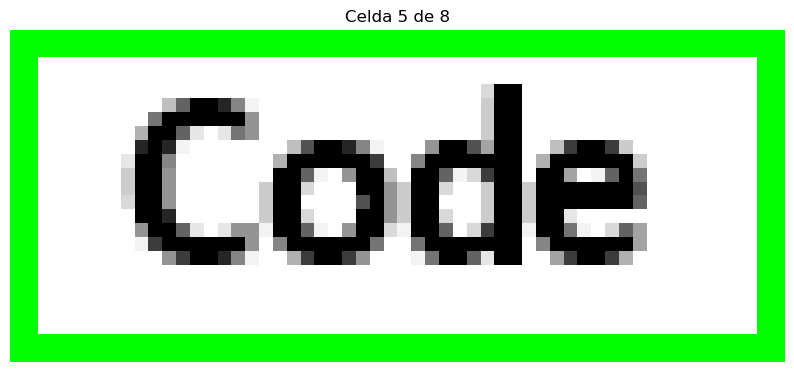

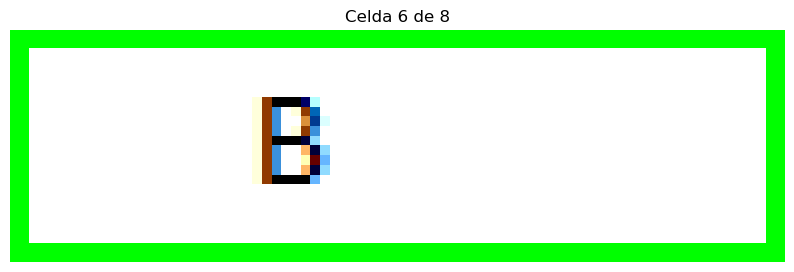

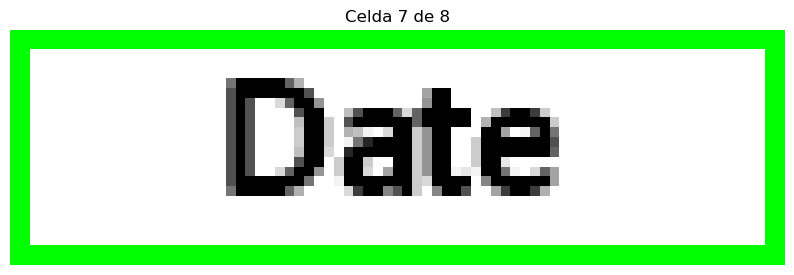

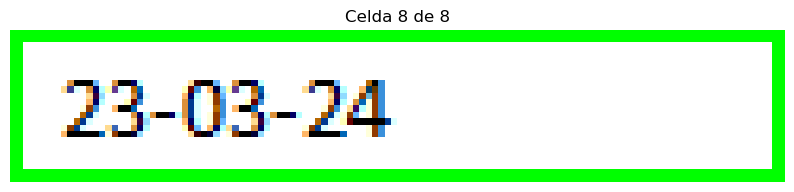

4. Analizando caracteres y palabras en cada celda...

   Procesando Celda 1:


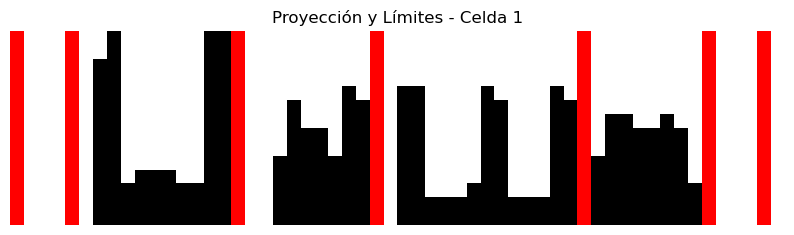

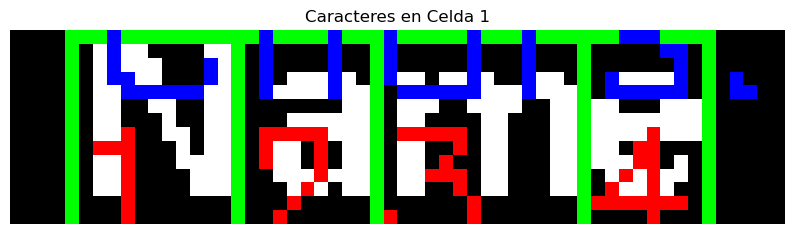

   Celda 1: 4 caracteres, 1 palabras


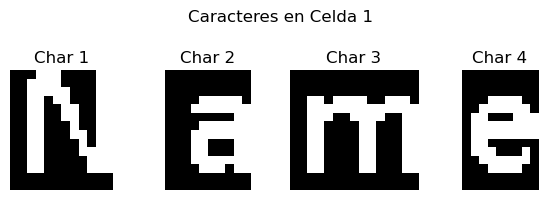


   Procesando Celda 2:


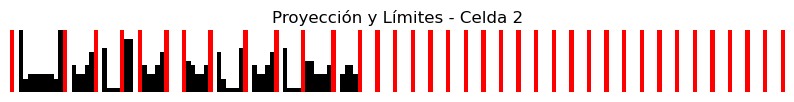

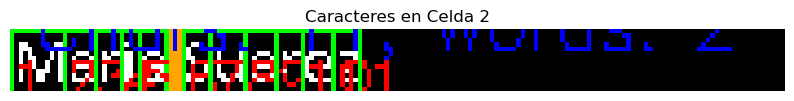

   Celda 2: 11 caracteres, 2 palabras


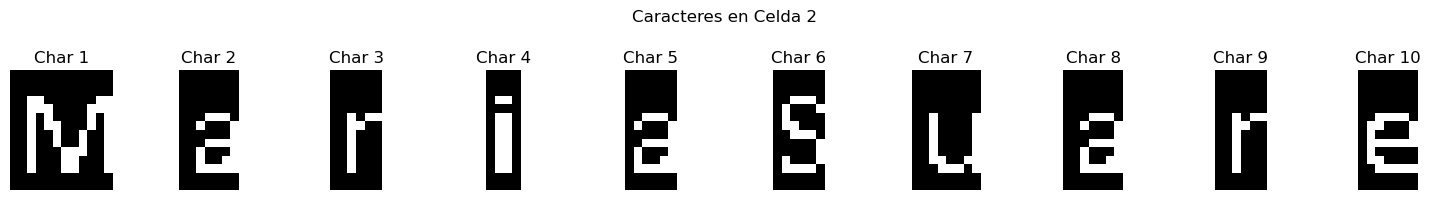


   Procesando Celda 3:


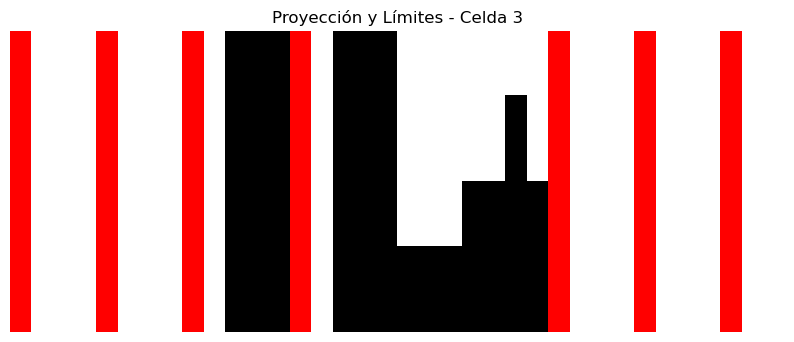

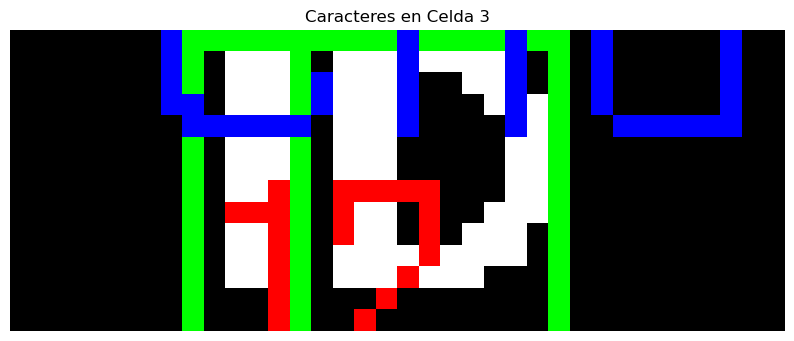

   Celda 3: 2 caracteres, 1 palabras


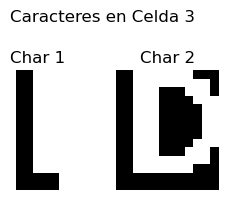


   Procesando Celda 4:


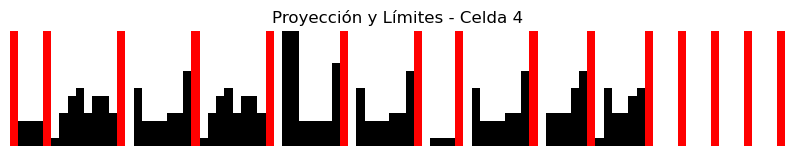

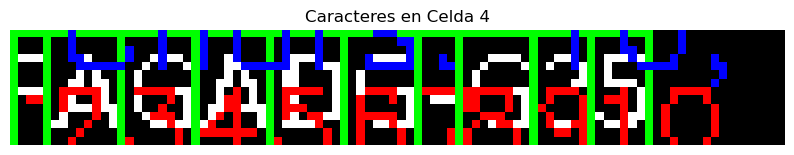

   Celda 4: 10 caracteres, 1 palabras


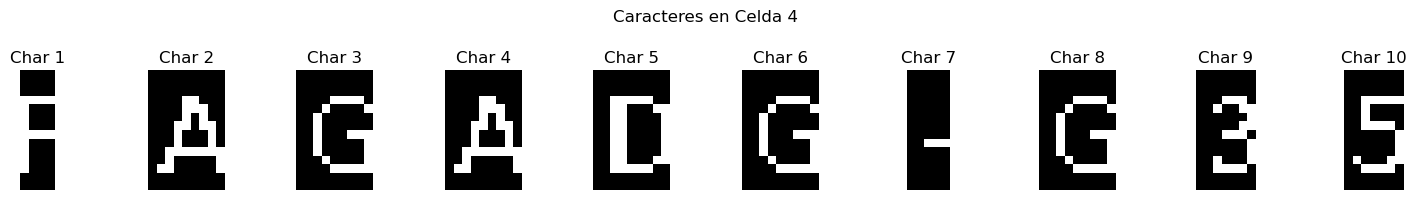


   Procesando Celda 5:


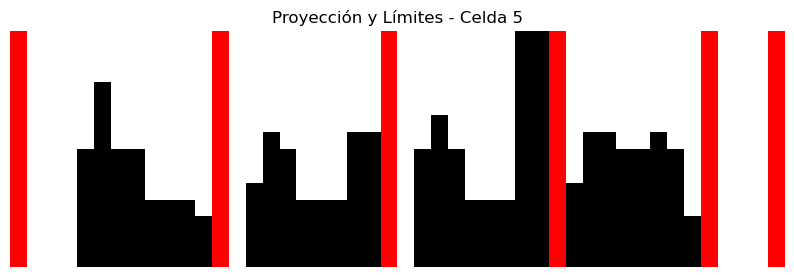

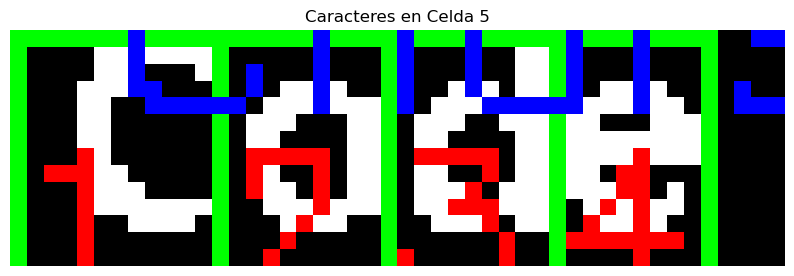

   Celda 5: 4 caracteres, 1 palabras


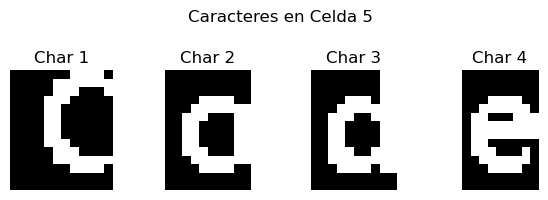


   Procesando Celda 6:


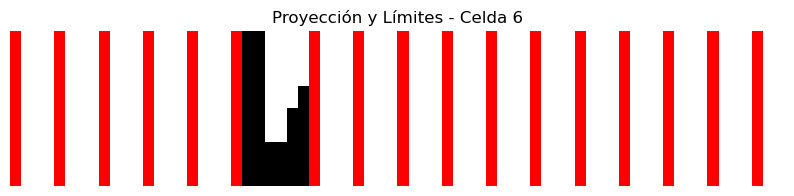

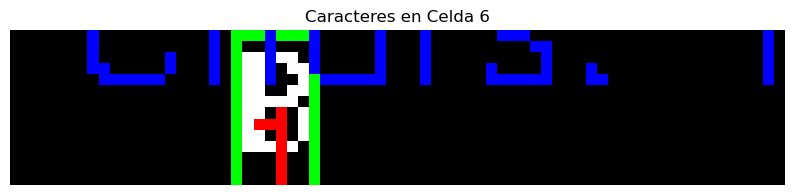

   Celda 6: 1 caracteres, 1 palabras


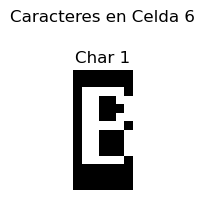


   Procesando Celda 7:


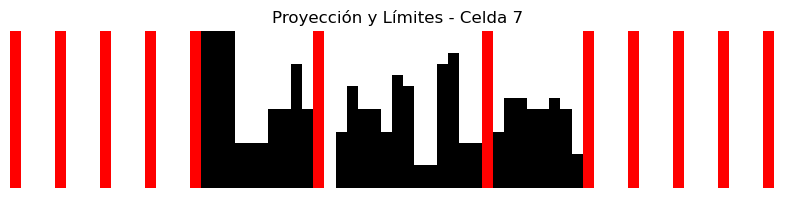

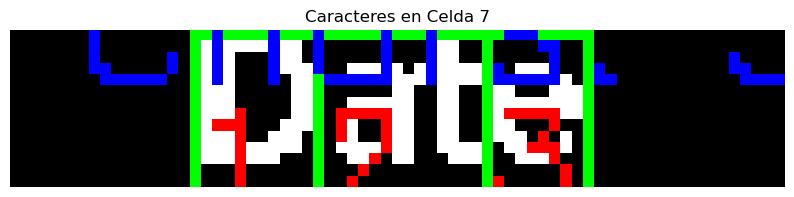

   Celda 7: 3 caracteres, 1 palabras


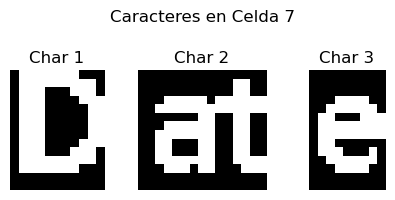


   Procesando Celda 8:


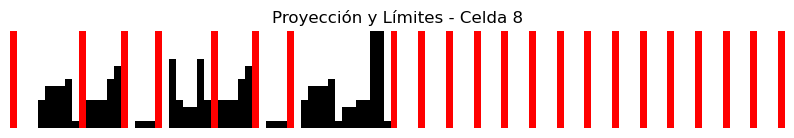

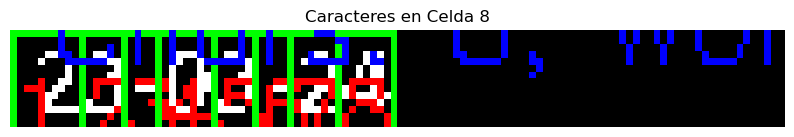

   Celda 8: 8 caracteres, 1 palabras


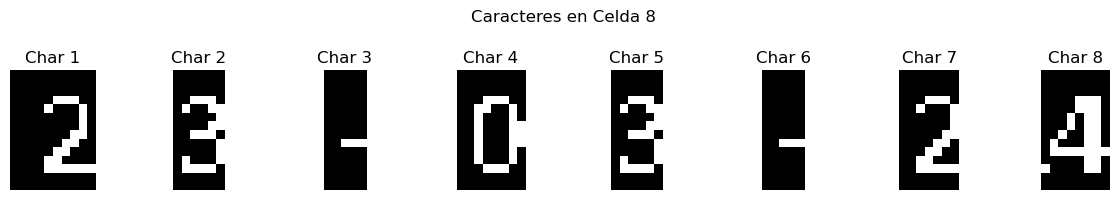

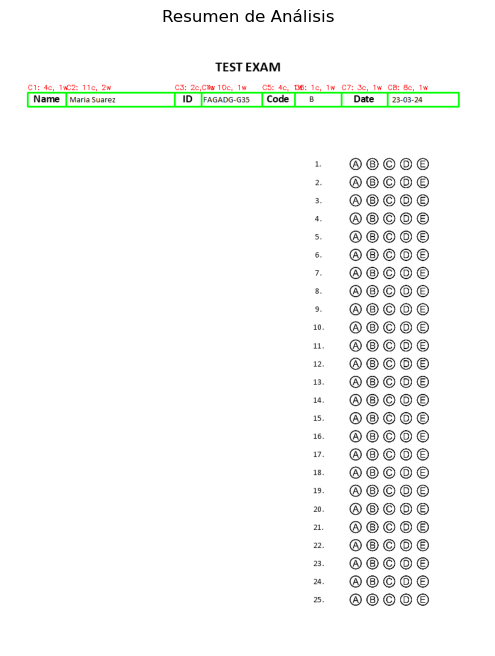


Procesamiento completado con éxito.


In [184]:
def Main(ruta_imagen):
    """
    Función principal que procesa una imagen para:
    1. Obtener la imagen binaria
    2. Encontrar los rectángulos en la imagen
    3. Dividir el rectángulo en celdas basadas en barras verticales
    4. Separar y contar caracteres y palabras en cada celda
    
    Args:
        ruta_imagen: Ruta a la imagen a procesar
    
    Returns:
        Diccionario con los resultados del procesamiento
    """
    # Verificar si la imagen existe
    if not os.path.exists(ruta_imagen):
        print(f"Error: Imagen no encontrada en {ruta_imagen}")
        return None
    
    # Leer la imagen
    imagen = cv2.imread(ruta_imagen)
    
    if imagen is None:
        print(f"Error: No se pudo leer la imagen en {ruta_imagen}")
        return None
    
    # Mostrar imagen original
    mostrar_imagen(imagen, "Imagen Original")
    
    # 1. Obtener imagen binaria
    print("1. Obteniendo imagen binaria...")
    binaria = obtener_imagen_binaria(imagen, umbral=130)
    mostrar_imagen(binaria, "Imagen Binaria")
    
    # 2. Detectar rectángulos en la imagen binaria
    print("2. Detectando rectángulos...")
    rectangulos = detectar_rectangulos(binaria)
    print(f"   Se detectaron {len(rectangulos)} rectángulos")
    
    # Verificar si se encontró al menos un rectángulo
    if not rectangulos:
        print("Error: No se detectaron rectángulos en la imagen")
        return None
    
    # Visualizar rectángulos detectados
    imagen_con_rectangulos = visualizar_rectangulos(imagen, rectangulos)
    mostrar_imagen(imagen_con_rectangulos, "Rectángulos Detectados")
    
    # Tomar el primer rectángulo (debería ser el único según el requerimiento)
    rectangulo_principal = rectangulos[0]
    
    # 3. Dividir el rectángulo en celdas basadas en barras verticales
    print("3. Dividiendo el rectángulo en celdas...")
    celdas = dividir_rectangulo_en_celdas(binaria, rectangulo_principal)
    print(f"   Se dividió el rectángulo en {len(celdas)} celdas")
        
    # Visualizar las celdas
    imagen_con_celdas = visualizar_casillas(imagen, rectangulo_principal, celdas)
    mostrar_imagen(imagen_con_celdas, "Todas las Celdas Detectadas")
    
    # Mostrar cada celda individualmente
    print("Mostrando celdas individuales:")
    for idx, celda in enumerate(celdas):
        x, y, w, h = celda
        # Extraer la región de la celda de la imagen original
        celda_img = imagen[y:y+h, x:x+w].copy()
        # Dibujar un borde para mejor visualización
        cv2.rectangle(celda_img, (0, 0), (w-1, h-1), (0, 255, 0), 2)
        # Mostrar la celda individual
        mostrar_imagen(celda_img, f"Celda {idx+1} de {len(celdas)}")


    # 4. Separar y contar caracteres y palabras en cada celda
    print("4. Analizando caracteres y palabras en cada celda...")
    resultados_celdas = {}
    
    for idx_celda, celda in enumerate(celdas):
        print(f"\n   Procesando Celda {idx_celda+1}:")
        
        # Extraer la región de interés (ROI) de la celda
        x, y, w, h = celda
        roi_binaria = binaria[y:y+h, x:x+w]
        
        # Extraer caracteres usando proyección vertical y capturar los resultados
        caracteres, coords, num_caracteres, num_palabras, roi_visual, proj_img = extract_and_count_text(roi_binaria)
        
        # Mostrar la proyección vertical con límites
        mostrar_imagen(proj_img, f"Proyección y Límites - Celda {idx_celda+1}")
        
        # Mostrar la celda con los caracteres detectados
        mostrar_imagen(roi_visual, f"Caracteres en Celda {idx_celda+1}")
        
        # Contar caracteres
        num_caracteres = len(caracteres)
        
        # Contar palabras usando espacios significativos entre caracteres
        num_palabras = 1 if num_caracteres > 0 else 0
        if len(coords) > 1:
            # Calcular distancia promedio entre caracteres
            distancias = []
            for i in range(len(coords) - 1):
                distancia = coords[i+1][0] - (coords[i][0] + coords[i][2])
                distancias.append(distancia)
            
            # Calcular distancia promedio y umbral para considerar un espacio
            if distancias:
                dist_promedio = sum(distancias) / len(distancias)
                umbral_espacio = dist_promedio * 1.5
                
                # Contar palabras basadas en espacios significativos
                for dist in distancias:
                    if dist > umbral_espacio:
                        num_palabras += 1
        
        # Guardar resultados
        resultados_celdas[idx_celda] = {
            'caracteres': caracteres,
            'coords': coords,
            'num_caracteres': num_caracteres,
            'num_palabras': num_palabras
        }
        
        # Mostrar resultados
        print(f"   Celda {idx_celda+1}: {num_caracteres} caracteres, {num_palabras} palabras")
        
        # Mostrar caracteres individuales si hay alguno
        if caracteres and len(caracteres) > 0:
            # Limitar el número de caracteres a mostrar
            max_chars_to_show = min(len(caracteres), 10)
            
            if max_chars_to_show > 0:
                fig, axes = plt.subplots(1, max_chars_to_show, figsize=(max_chars_to_show*1.5, 2))
                fig.suptitle(f"Caracteres en Celda {idx_celda+1}")
                
                # Asegurar que axes sea iterable incluso con un solo carácter
                if max_chars_to_show == 1:
                    axes = [axes]
                
                for i in range(max_chars_to_show):
                    axes[i].imshow(caracteres[i], cmap='gray')
                    axes[i].set_title(f"Char {i+1}")
                    axes[i].axis('off')
                
                plt.tight_layout()
                plt.show()
    
    # Crear una imagen resumen con los conteos
    imagen_resultados = imagen.copy()
    for idx_celda, data in resultados_celdas.items():
        if idx_celda < len(celdas):
            x, y, w, h = celdas[idx_celda]
            num_chars = data['num_caracteres']
            num_words = data['num_palabras']
            
            # Dibujar rectángulo
            cv2.rectangle(imagen_resultados, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Añadir etiqueta con conteos
            label = f"C{idx_celda+1}: {num_chars}c, {num_words}w"
            cv2.putText(imagen_resultados, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    mostrar_imagen(imagen_resultados, "Resumen de Análisis")

    print("\nProcesamiento completado con éxito.")
    
    return {
        'rectangulo': rectangulo_principal,
        'celdas': celdas,
        'resultados_celdas': resultados_celdas
    }

# Ejemplo de uso
if __name__ == "__main__":
    # Ruta a la imagen de prueba
    ruta_imagen = r"./multiple_choice_1.png"
    
    # Ejecutar la función principal
    for i in range(1,6):
        ruta_imagen = r"./multiple_choice_"+str(i)+".png"
        Main(ruta_imagen)